# Packages used

In [1]:
!conda list
!which python
!python --version
!jupyter kernelspec list

# packages in environment at /Users/douglas/anaconda3/envs/jupyter_venv:
#
# Name                    Version                   Build  Channel
adjusttext                1.2.0              pyhd8ed1ab_0    conda-forge
anyio                     4.2.0           py312hecd8cb5_0  
appnope                   0.1.3           py312hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py312h6c40b1e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
async-lru                 2.0.4           py312hecd8cb5_0  
attrs                     23.1.0          py312hecd8cb5_0  
babel                     2.11.0          py312hecd8cb5_0  
beautifulsoup4            4.12.3          py312hecd8cb5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
bottleneck                1.3.7           py312h32608ca_0  
brotli                    1.0.9                h6c40b1e_8  
br

# Change output size to fit screen

In [244]:
import pandas as pd
# Set display options for the entire session
# Set display options to 1000
pd.set_option('display.max_rows', 1000)  # Show up to 1000 rows
pd.set_option('display.max_columns', 1000)  # Show up to 1000 columns
pd.set_option('display.width', 1000)  # Set width to 1000 characters
pd.set_option('display.max_colwidth', 1000)  # Set max column width to 1000 characters


# Data
Input: Outputs from Section 8 (outputs from 'significance_analysis_of_kmeans_clusters_across_all_data_points.ipynb' and 'specified_kmeans_clustering_and_ntdata_kruskall_wallis_significance_test.ipynb'): pca_analysis_significant_results.csv, pca_analysis_results_multiple_files.csv

# Function 1: analyze_pca_kmeans_vs_median, single datapoint for clustering groups then kruskal wallis,with averages and cluster groups
This was my first function to find one at a time plots and their clusters


In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_pca_kmeans_vs_median(file_ID, n_components_pca, clusters_to_use, pc_x, pc_y, variable_to_compare, method='kmeans'):
    # Load the data
    csv_file = f'{file_ID}.csv'  # File name of the dataset
    pw_flx1 = pd.read_csv(csv_file)
    file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
    xls = pd.ExcelFile(file_path)
    df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

    # Extract the participant IDs from NutriTech data
    nutritech_ids = df_week5_before['name'].tolist()
    pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

    # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
    mapping = {}
    for nt_id in nutritech_ids:
        if nt_id in pw_flx1_ids.values:
            matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
            mapping[nt_id] = matched_column

    # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
    pca_labels = []
    nutritech_labels = []
    for column in pw_flx1.columns:
        matched_id = next((key for key, value in mapping.items() if value == column), None)
        if matched_id:
            label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
            pca_labels.append(label)
            nutritech_labels.append(matched_id)
        else:
            pca_labels.append(np.nan)  # Handle missing data
            nutritech_labels.append('Unknown')

    pca_labels = np.array(pca_labels)
    finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
    norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
    cmap = plt.cm.viridis
    colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

    # Step 2: Perform PCA
    pca = PCA(n_components=n_components_pca)
    pcaData = pca.fit_transform(pw_flx1.T)
    print(pca.explained_variance_ratio_)

    # Choose the method: 'kmeans' or 'median_split'
    if method == 'kmeans':
        # Step 3a: Perform K-Means Clustering
        kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

        # Step 4a: Visualize PCA with K-Means Clusters and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for i in range(clusters_to_use):
            cluster_indices = clusters == i
            plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
            for j in np.where(cluster_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5a: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_clusters = []
        cluster_means = []
        cluster_medians = []
        for i in range(clusters_to_use):
            cluster_values = pca_labels[clusters == i]
            cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
            if len(cluster_values) > 0:
                valid_clusters.append(cluster_values)
                cluster_means.append(np.mean(cluster_values))
                cluster_medians.append(np.median(cluster_values))

        if len(valid_clusters) > 1:
            kruskal_results = kruskal(*valid_clusters)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (K-Means): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid clusters for Kruskal-Wallis test for {variable_to_compare} (K-Means).")

    elif method == 'median_split':
        # Step 3b: Group by Median Split
        median_value = np.nanmedian(pca_labels)  # Calculate the median of the variable
        group_labels = np.array(['Bottom Half' if val <= median_value else 'Top Half' for val in pca_labels])

        # Step 4b: Visualize PCA with Median Split Groups and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for group in ['Bottom Half', 'Top Half']:
            group_indices = group_labels == group
            plt.scatter(pcaData[group_indices, pc_x], pcaData[group_indices, pc_y], label=group, alpha=0.7)
            for j in np.where(group_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'Median Split on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5b: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_groups = []
        group_means = []
        group_medians = []
        for group in ['Bottom Half', 'Top Half']:
            group_values = pca_labels[group_labels == group]
            group_values = group_values[~np.isnan(group_values)]  # Remove NaN values
            if len(group_values) > 0:
                valid_groups.append(group_values)
                group_means.append(np.mean(group_values))
                group_medians.append(np.median(group_values))

        if len(valid_groups) > 1:
            kruskal_results = kruskal(*valid_groups)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (Median Split): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid groups for Kruskal-Wallis test for {variable_to_compare} (Median Split).")

    else:
        print("Invalid method. Choose 'kmeans' or 'median_split'.")

    # Step 6: Print Group/Cluster Assignments and Statistics for Verification
    if method == 'kmeans':
        assignment_data = pd.DataFrame({
            'NutriTech ID': nutritech_labels,
            'Cluster': clusters,
            f'{variable_to_compare}': pca_labels
        })
        print(f"\nAssignments and {variable_to_compare} Values (K-Means):")
        print(assignment_data.sort_values(by='Cluster'))

        # Print mean and median for each cluster
        for i in range(clusters_to_use):
            print(f"Cluster {i+1} - Mean: {cluster_means[i]}, Median: {cluster_medians[i]}")

    elif method == 'median_split':
        assignment_data = pd.DataFrame({
            'NutriTech ID': nutritech_labels,
            'Group': group_labels,
            f'{variable_to_compare}': pca_labels
        })
        print(f"\nAssignments and {variable_to_compare} Values (Median Split):")
        print(assignment_data.sort_values(by='Group'))

        # Print mean and median for each group
        for i, group in enumerate(['Bottom Half', 'Top Half']):
            print(f"{group} - Mean: {group_means[i]}, Median: {group_medians[i]}")


[0.378123   0.19748016]


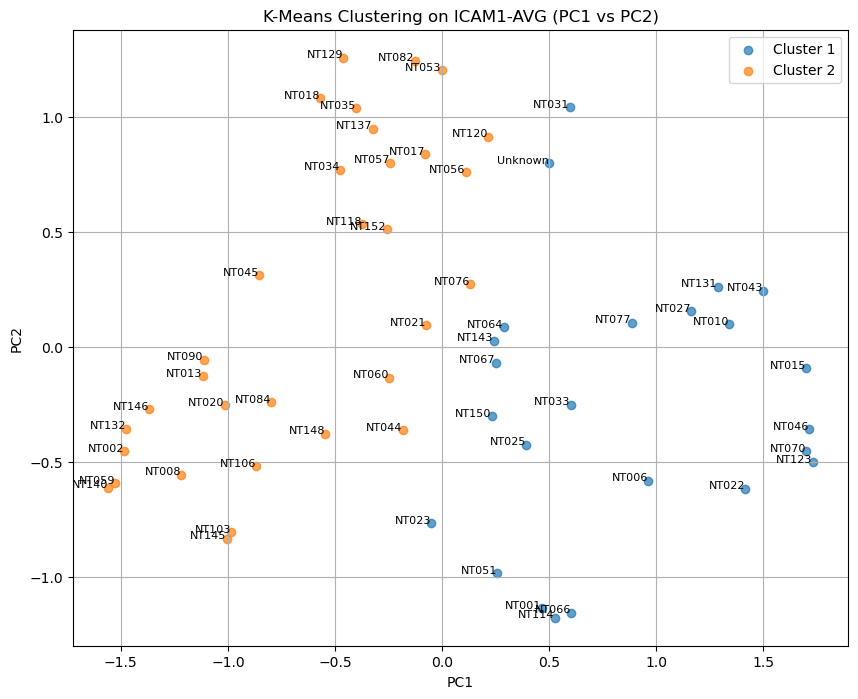

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 5.372306515364045, p-value = 0.020458906728038496

Assignments and ICAM1-AVG Values (K-Means):
   NutriTech ID  Cluster   ICAM1-AVG
3         NT150        0  253.487275
4         NT027        0  190.205499
5         NT067        0  118.807174
11      Unknown        0         NaN
13        NT043        0  226.831434
14        NT143        0  256.151366
10        NT051        0  215.183143
16        NT033        0  199.514632
27        NT064        0  124.296881
21        NT010        0  167.191012
30        NT114        0  198.776877
28        NT031        0  192.156277
17        NT066        0  207.157354
37        NT070        0  196.402812
35        NT015        0  260.817345
32        NT023        0  187.847345
40        NT077        0  220.518120
42        NT006        0  229.231839
45        NT001        0  257.048346
39        NT022        0  248.877064
36        NT025        0  247.589013
48        NT131        0 

In [4]:
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T120_',  
    n_components_pca=2,
    clusters_to_use=2,
    pc_x=0,
    pc_y=1,
    variable_to_compare='ICAM1-AVG',
    method='kmeans'
)


# Function 2: analyze_multiple_files_and_variables , with multiple parameters + table + plots option, I used 

I used this to find all P values and H statistics of all possible NT participants across all Timepoints and NT Data, this allowed multiple data to be processed at once, includes the option for plots and table to be saved as csv.

In [5]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_multiple_files_and_variables(file_IDs, n_components_pca, clusters_to_use, pc_x, pc_y, variables_to_compare, method='kmeans', show_plots=True):
    # Initialize a DataFrame to store all results
    all_results = []

    # Loop through each file_ID
    for file_ID in file_IDs:
        # Loop through each variable to compare
        for variable_to_compare in variables_to_compare:
            print(f"Analyzing {variable_to_compare} in {file_ID}...")

            # Load the data
            csv_file = f'{file_ID}.csv'  # File name of the dataset
            pw_flx1 = pd.read_csv(csv_file)
            file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
            xls = pd.ExcelFile(file_path)
            df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

            # Extract the participant IDs from NutriTech data
            nutritech_ids = df_week5_before['name'].tolist()
            pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

            # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
            mapping = {}
            for nt_id in nutritech_ids:
                if nt_id in pw_flx1_ids.values:
                    matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                    mapping[nt_id] = matched_column

            # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
            pca_labels = []
            nutritech_labels = []
            for column in pw_flx1.columns:
                matched_id = next((key for key, value in mapping.items() if value == column), None)
                if matched_id:
                    label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                    pca_labels.append(label)
                    nutritech_labels.append(matched_id)
                else:
                    pca_labels.append(np.nan)  # Handle missing data
                    nutritech_labels.append('Unknown')

            pca_labels = np.array(pca_labels)
            finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
            norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
            cmap = plt.cm.viridis
            colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

            # Step 2: Perform PCA
            pca = PCA(n_components=n_components_pca)
            pcaData = pca.fit_transform(pw_flx1.T)
            explained_variance_ratio = pca.explained_variance_ratio_

            # Choose the method: 'kmeans' or 'median_split'
            if method == 'kmeans':
                # Step 3a: Perform K-Means Clustering
                kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
                clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

                # Calculate mean and median for each cluster
                cluster_means = []
                cluster_medians = []
                for i in range(clusters_to_use):
                    cluster_values = pca_labels[clusters == i]
                    cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
                    if len(cluster_values) > 0:
                        cluster_means.append(np.mean(cluster_values))
                        cluster_medians.append(np.median(cluster_values))
                    else:
                        cluster_means.append(np.nan)
                        cluster_medians.append(np.nan)

                # Perform Kruskal-Wallis Test
                valid_clusters = [pca_labels[clusters == i][~np.isnan(pca_labels[clusters == i]) & (pca_labels[clusters == i] > 0)] for i in range(clusters_to_use)]
                if len([vc for vc in valid_clusters if len(vc) > 0]) > 1:
                    kruskal_results = kruskal(*valid_clusters)
                    h_statistic = kruskal_results.statistic
                    p_value = kruskal_results.pvalue
                else:
                    h_statistic = np.nan
                    p_value = np.nan

                # Step 4a: Display the table at the start before plotting
                cluster_data = pd.DataFrame({
                    'File ID': file_ID,
                    'Variable': variable_to_compare,
                    'Cluster': [f'Cluster {i+1}' for i in range(clusters_to_use)],
                    'Mean': cluster_means,
                    'Median': cluster_medians,
                    'H-Statistic': h_statistic,
                    'P-Value': p_value
                })
                print(f"\n{file_ID} - {variable_to_compare} Results:")
                print(cluster_data)

                # Plot PCA with K-Means Clusters and NutriTech IDs
                if show_plots:
                    plt.figure(figsize=(10, 8))
                    for i in range(clusters_to_use):
                        cluster_indices = clusters == i
                        plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
                        for j in np.where(cluster_indices)[0]:
                            plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

                    plt.xlabel(f'PC{pc_x+1}: {explained_variance_ratio[pc_x]*100:.2f}% variance')
                    plt.ylabel(f'PC{pc_y+1}: {explained_variance_ratio[pc_y]*100:.2f}% variance')
                    plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
                    plt.legend()
                    plt.grid(True)
                    plt.show()

            elif method == 'median_split':
                # Step 3b: Group by Median Split
                median_value = np.nanmedian(pca_labels)
                group_labels = np.array(['Bottom Half' if val <= median_value else 'Top Half' for val in pca_labels])

                # Calculate mean and median for each group
                group_means = []
                group_medians = []
                for group in ['Bottom Half', 'Top Half']:
                    group_values = pca_labels[group_labels == group]
                    group_values = group_values[~np.isnan(group_values)]
                    if len(group_values) > 0:
                        group_means.append(np.mean(group_values))
                        group_medians.append(np.median(group_values))
                    else:
                        group_means.append(np.nan)
                        group_medians.append(np.nan)

                # Perform Kruskal-Wallis Test
                valid_groups = [pca_labels[group_labels == group][~np.isnan(pca_labels[group_labels == group])] for group in ['Bottom Half', 'Top Half']]
                if len([vg for vg in valid_groups if len(vg) > 0]) > 1:
                    kruskal_results = kruskal(*valid_groups)
                    h_statistic = kruskal_results.statistic
                    p_value = kruskal_results.pvalue
                else:
                    h_statistic = np.nan
                    p_value = np.nan

                # Step 4b: Display the table at the start before plotting
                group_data = pd.DataFrame({
                    'File ID': file_ID,
                    'Variable': variable_to_compare,
                    'Group': ['Bottom Half', 'Top Half'],
                    'Mean': group_means,
                    'Median': group_medians,
                    'H-Statistic': h_statistic,
                    'P-Value': p_value
                })
                print(f"\n{file_ID} - {variable_to_compare} Results:")
                print(group_data)

                # Plot PCA with Median Split Groups and NutriTech IDs
                if show_plots:
                    plt.figure(figsize=(10, 8))
                    for group in ['Bottom Half', 'Top Half']:
                        group_indices = group_labels == group
                        plt.scatter(pcaData[group_indices, pc_x], pcaData[group_indices, pc_y], label=group, alpha=0.7)
                        for j in np.where(group_indices)[0]:
                            plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

                    plt.xlabel(f'PC{pc_x+1}: {explained_variance_ratio[pc_x]*100:.2f}% variance')
                    plt.ylabel(f'PC{pc_y+1}: {explained_variance_ratio[pc_y]*100:.2f}% variance')
                    plt.title(f'Median Split on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
                    plt.legend()
                    plt.grid(True)
                    plt.show()

            else:
                print("Invalid method. Choose 'kmeans' or 'median_split'.")
                continue

            # Save results for this variable and file_ID
            for i in range(clusters_to_use):
                all_results.append({
                    'File ID': file_ID,
                    'Variable': variable_to_compare,
                    'Method': method,
                    'Cluster': f'Cluster {i+1}' if method == 'kmeans' else ['Bottom Half', 'Top Half'][i],
                    'Mean': cluster_means[i] if method == 'kmeans' else group_means[i],
                    'Median': cluster_medians[i] if method == 'kmeans' else group_medians[i],
                    'H-Statistic': h_statistic,
                    'P-Value': p_value
                })

    # Convert all results into a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df


In [6]:
# Example usage
'''Index(['name', 'Age', 'Gender', 'Body weight ', 'Body height ', 'BMI ',
       'Start group', 'fasting glucose', '2hr glucose', 'fasting insulin',
       'fasting triglyceride', 'HOMA-IR', 'Matsuda', 'IGI', 'CRP-D1',
       'E-Selectin-D1', 'IL18-D1', 'IL1b-D1', 'TNF-alpha-D1', 'VCAM-1-D1',
       'adiponectin-D1','IL1-AVG', 'IL6-AVG', 'IL10-AVG', 'IL8-AVG', 'MCP1-AVG', 'ICAM1-AVG']'''

file_IDs = [ 'W5D2T0_', 'W5D2T120_', 'W5D3T0_','W5D3T120_','W5D3T240_']  # Add more file IDs as needed
variables_to_compare = ['BMI ', 'Age', 'Body weight ', 
       'fasting glucose', '2hr glucose', 'fasting insulin',
       'fasting triglyceride', 'HOMA-IR', 'Matsuda', 'IGI', 'CRP-D1',
       'E-Selectin-D1', 'IL18-D1', 'IL1b-D1', 'TNF-alpha-D1', 'VCAM-1-D1',
       'adiponectin-D1','IL1-AVG', 'IL6-AVG', 'IL10-AVG', 'IL8-AVG', 'MCP1-AVG', 'ICAM1-AVG']  # Add more variables as needed
results_df = analyze_multiple_files_and_variables(
    file_IDs=file_IDs,
    n_components_pca=2,
    clusters_to_use=2,
    pc_x=0, # 0 based, +1
    pc_y=1, # 0 based, +1
    variables_to_compare=variables_to_compare,
    method='kmeans',  # Can be 'kmeans' or 'median_split'
    show_plots=False  # Set to True to view plots, False to skip them
)

# Save the results to a CSV file
results_df.to_csv('pca_analysis_results_multiple_files.csv', index=False)

# Display the results
print(results_df)

Analyzing BMI  in W5D2T0_...

W5D2T0_ - BMI  Results:
   File ID Variable    Cluster       Mean     Median  H-Statistic   P-Value
0  W5D2T0_     BMI   Cluster 1  28.908525  29.291951     0.752856  0.385574
1  W5D2T0_     BMI   Cluster 2  29.412829  28.664143     0.752856  0.385574
Analyzing Age in W5D2T0_...

W5D2T0_ - Age Results:
   File ID Variable    Cluster       Mean  Median  H-Statistic   P-Value
0  W5D2T0_      Age  Cluster 1  58.606061    59.0     0.969517  0.324801
1  W5D2T0_      Age  Cluster 2  59.931034    61.0     0.969517  0.324801
Analyzing Body weight  in W5D2T0_...

W5D2T0_ - Body weight  Results:
   File ID      Variable    Cluster       Mean  Median  H-Statistic   P-Value
0  W5D2T0_  Body weight   Cluster 1  84.639394    85.1     0.064492  0.799532
1  W5D2T0_  Body weight   Cluster 2  83.634483    82.0     0.064492  0.799532
Analyzing fasting glucose in W5D2T0_...

W5D2T0_ - fasting glucose Results:
   File ID         Variable    Cluster      Mean  Median  H-Statist

## Function 2 part 2, updated function with custom clusters

In [36]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_multiple_files_and_variables2(file_IDs, n_components_pca, clusters_to_use, pc_x, pc_y, variables_to_compare, method='kmeans', custom_cluster_file=None, show_plots=True):
    # Initialize a DataFrame to store all results
    all_results = []

    # Load custom cluster assignments if provided
    if custom_cluster_file:
        custom_clusters_df = pd.read_csv(custom_cluster_file)
        custom_clusters_df.set_index('NutriTech ID', inplace=True)

    # Loop through each file_ID
    for file_ID in file_IDs:
        # Loop through each variable to compare
        for variable_to_compare in variables_to_compare:
            print(f"Analyzing {variable_to_compare} in {file_ID}...")

            # Load the data
            csv_file = f'{file_ID}.csv'  # File name of the dataset
            pw_flx1 = pd.read_csv(csv_file)
            file_path = 'NutriTech_otherdata_AVG.xlsx'
            xls = pd.ExcelFile(file_path)
            df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

            # Extract the participant IDs from NutriTech data
            nutritech_ids = df_week5_before['name'].tolist()
            pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

            # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
            mapping = {}
            original_columns = {}
            for nt_id in nutritech_ids:
                if nt_id in pw_flx1_ids.values:
                    matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                    mapping[nt_id] = matched_column
                    original_columns[nt_id] = matched_column  # Store the original column name

            # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
            pca_labels = []
            nutritech_labels = []
            original_column_names = []
            for column in pw_flx1.columns:
                matched_id = next((key for key, value in mapping.items() if value == column), None)
                if matched_id:
                    label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                    pca_labels.append(label)
                    nutritech_labels.append(matched_id)
                    original_column_names.append(original_columns[matched_id])
                else:
                    pca_labels.append(np.nan)  # Handle missing data
                    nutritech_labels.append('Unknown')
                    original_column_names.append(column)  # Keep original name for unknowns

            pca_labels = np.array(pca_labels)
            finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
            norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
            cmap = plt.cm.viridis
            colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

            # Step 2: Perform PCA
            pca = PCA(n_components=n_components_pca)
            pcaData = pca.fit_transform(pw_flx1.T)
            explained_variance_ratio = pca.explained_variance_ratio_

            # Custom cluster handling
            if method == 'custom' and custom_cluster_file:
                clusters = []
                for nutri_id in nutritech_labels:
                    if nutri_id in custom_clusters_df.index:
                        clusters.append(custom_clusters_df.loc[nutri_id, 'Cluster'])
                    else:
                        clusters.append(2)  # Assign NaN/Unknown to cluster 2

            elif method == 'kmeans':
                # Step 3a: Perform K-Means Clustering
                kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
                clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

            clusters = np.array([c if isinstance(c, (int, float, np.integer, np.floating)) else 2 for c in clusters])  # Assign NaN/Unknown to cluster 2

            # Calculate mean and median for each cluster, excluding NaN values
            cluster_means = []
            cluster_medians = []
            for i in range(clusters_to_use):
                cluster_values = pca_labels[clusters == i]
                cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
                if len(cluster_values) > 0:
                    cluster_means.append(np.mean(cluster_values))
                    cluster_medians.append(np.median(cluster_values))
                else:
                    cluster_means.append(np.nan)
                    cluster_medians.append(np.nan)

            # Perform Kruskal-Wallis Test, excluding cluster 2 (NaN/Unknown)
            valid_clusters = [pca_labels[clusters == i][~np.isnan(pca_labels[clusters == i]) & (pca_labels[clusters == i] > 0)] for i in range(clusters_to_use) if i != 2]
            if len([vc for vc in valid_clusters if len(vc) > 0]) > 1:
                kruskal_results = kruskal(*valid_clusters)
                h_statistic = kruskal_results.statistic
                p_value = kruskal_results.pvalue
            else:
                h_statistic = np.nan
                p_value = np.nan

            # Step 6: Prepare Group/Cluster Assignments for Saving
            assignment_data = pd.DataFrame({
                'NutriTech ID': nutritech_labels,
                #'model_id': original_column_names,  # Include original column names
                'Cluster': clusters,
                f'{variable_to_compare}': pca_labels
            })

            print(f"\nAssignments and {variable_to_compare} Values ({method.capitalize()}):")
            print(assignment_data)

            # Save results for this variable and file_ID
            for i in range(clusters_to_use + 1):  # Include NaN/Unknown cluster
                if i != 2:  # Skip cluster 2 (NaN/Unknown) for mean/median calculations
                    all_results.append({
                        'File ID': file_ID,
                        'Variable': variable_to_compare,
                        'Method': method,
                        'Cluster': i if i != 2 else np.nan,
                        'Mean': cluster_means[i] if i < clusters_to_use else np.nan,
                        'Median': cluster_medians[i] if i < clusters_to_use else np.nan,
                        'H-Statistic': h_statistic if i != 2 else np.nan,
                        'P-Value': p_value if i != 2 else np.nan
                    })

            # Plot PCA with Clusters and NutriTech IDs
            if show_plots:
                plt.figure(figsize=(10, 8))
                for i in range(clusters_to_use + 1):  # Include NaN/Unknown cluster
                    cluster_indices = clusters == i
                    plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i}' if i != 2 else 'Unknown(2)', alpha=0.7)
                    for j in np.where(cluster_indices)[0]:
                        plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

                plt.xlabel(f'PC{pc_x+1}: {explained_variance_ratio[pc_x]*100:.2f}% variance')
                plt.ylabel(f'PC{pc_y+1}: {explained_variance_ratio[pc_y]*100:.2f}% variance')
                plt.title(f'{method.capitalize()} Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
                plt.legend()
                plt.grid(True)
                plt.show()

    # Convert all results into a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df




In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_multiple_files_and_variables2(file_IDs, n_components_pca, clusters_to_use, pc_x, pc_y, variables_to_compare, method='kmeans', custom_cluster_file=None, show_plots=True):
    # Initialize a DataFrame to store all results
    all_results = []

    # Load custom cluster assignments if provided
    if custom_cluster_file:
        custom_clusters_df = pd.read_csv(custom_cluster_file)
        custom_clusters_df.set_index('NutriTech ID', inplace=True)

    # Loop through each file_ID
    for file_ID in file_IDs:
        # Loop through each variable to compare
        for variable_to_compare in variables_to_compare:
            print(f"Analyzing {variable_to_compare} in {file_ID}...")

            # Load the data
            csv_file = f'{file_ID}.csv'  # File name of the dataset
            pw_flx1 = pd.read_csv(csv_file)
            file_path = 'NutriTech_otherdata_AVG.xlsx'
            xls = pd.ExcelFile(file_path)
            df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

            # Extract the participant IDs from NutriTech data
            nutritech_ids = df_week5_before['name'].tolist()
            pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

            # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
            mapping = {}
            original_columns = {}
            for nt_id in nutritech_ids:
                if nt_id in pw_flx1_ids.values:
                    matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                    mapping[nt_id] = matched_column
                    original_columns[nt_id] = matched_column  # Store the original column name

            # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
            pca_labels = []
            nutritech_labels = []
            original_column_names = []
            for column in pw_flx1.columns:
                matched_id = next((key for key, value in mapping.items() if value == column), None)
                if matched_id:
                    label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                    pca_labels.append(label)
                    nutritech_labels.append(matched_id)
                    original_column_names.append(original_columns[matched_id])
                else:
                    pca_labels.append(np.nan)  # Handle missing data
                    nutritech_labels.append('Unknown')
                    original_column_names.append(column)  # Keep original name for unknowns

            pca_labels = np.array(pca_labels)
            finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
            norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
            cmap = plt.cm.viridis
            colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

            # Step 2: Perform PCA
            pca = PCA(n_components=n_components_pca)
            pcaData = pca.fit_transform(pw_flx1.T)
            explained_variance_ratio = pca.explained_variance_ratio_

            # Custom cluster handling
            if method == 'custom' and custom_cluster_file:
                clusters = []
                for nutri_id in nutritech_labels:
                    if nutri_id in custom_clusters_df.index:
                        clusters.append(custom_clusters_df.loc[nutri_id, 'Cluster'])
                    else:
                        clusters.append(2)  # Assign NaN/Unknown to cluster 2

            elif method == 'kmeans':
                # Step 3a: Perform K-Means Clustering
                kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
                clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

            clusters = np.array([c if isinstance(c, (int, float, np.integer, np.floating)) else 2 for c in clusters])  # Assign NaN/Unknown to cluster 2

            # Calculate mean and median for each cluster, excluding NaN values
            cluster_means = []
            cluster_medians = []
            for i in range(clusters_to_use):
                cluster_values = pca_labels[clusters == i]
                cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
                if len(cluster_values) > 0:
                    cluster_means.append(np.mean(cluster_values))
                    cluster_medians.append(np.median(cluster_values))
                else:
                    cluster_means.append(np.nan)
                    cluster_medians.append(np.nan)

            # Perform Kruskal-Wallis Test, excluding cluster 2 (NaN/Unknown)
            valid_clusters = [pca_labels[clusters == i][~np.isnan(pca_labels[clusters == i]) & (pca_labels[clusters == i] > 0)] for i in range(clusters_to_use) if i != 2]
            if len([vc for vc in valid_clusters if len(vc) > 0]) > 1:
                kruskal_results = kruskal(*valid_clusters)
                h_statistic = kruskal_results.statistic
                p_value = kruskal_results.pvalue
            else:
                h_statistic = np.nan
                p_value = np.nan

            # Step 6: Prepare Group/Cluster Assignments for Saving
            assignment_data = pd.DataFrame({
                'NutriTech ID': nutritech_labels,
                'Cluster': clusters,
                f'{variable_to_compare}': pca_labels
            })

            # Only print cluster assignments if show_plots is True
            if show_plots:
                print(f"\nAssignments and {variable_to_compare} Values ({method.capitalize()}):")
                print(assignment_data)

            # Save results for this variable and file_ID
            for i in range(clusters_to_use + 1):  # Include NaN/Unknown cluster
                if i != 2:  # Skip cluster 2 (NaN/Unknown) for mean/median calculations
                    all_results.append({
                        'File ID': file_ID,
                        'Variable': variable_to_compare,
                        'Method': method,
                        'Cluster': i if i != 2 else np.nan,
                        'Mean': cluster_means[i] if i < clusters_to_use else np.nan,
                        'Median': cluster_medians[i] if i < clusters_to_use else np.nan,
                        'H-Statistic': h_statistic if i != 2 else np.nan,
                        'P-Value': p_value if i != 2 else np.nan
                    })

            # Plot PCA with Clusters and NutriTech IDs if show_plots is True
            if show_plots:
                plt.figure(figsize=(10, 8))
                for i in range(clusters_to_use + 1):  # Include NaN/Unknown cluster
                    cluster_indices = clusters == i
                    plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i}' if i != 2 else 'Unknown(2)', alpha=0.7)
                    for j in np.where(cluster_indices)[0]:
                        plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

                plt.xlabel(f'PC{pc_x+1}: {explained_variance_ratio[pc_x]*100:.2f}% variance')
                plt.ylabel(f'PC{pc_y+1}: {explained_variance_ratio[pc_y]*100:.2f}% variance')
                plt.title(f'{method.capitalize()} Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
                plt.legend()
                plt.grid(True)
                plt.show()

    # Convert all results into a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

In [47]:
file_IDs = [ 'W5D2T0_', 'W5D2T120_', 'W5D3T0_','W5D3T120_','W5D3T240_']  # Add more file IDs as needed
variables_to_compare = ['BMI ', 'Age', 'Body weight ', 
       'fasting glucose', '2hr glucose', 'fasting insulin',
       'fasting triglyceride', 'HOMA-IR', 'Matsuda', 'IGI', 'CRP-D1',
       'E-Selectin-D1', 'IL18-D1', 'IL1b-D1', 'TNF-alpha-D1', 'VCAM-1-D1',
       'adiponectin-D1','IL1-AVG', 'IL6-AVG', 'IL10-AVG', 'IL8-AVG', 'MCP1-AVG', 'ICAM1-AVG']  # Add more variables as needed
#analyze_multiple_files_and_variables2(file_IDs, n_components_pca=2, clusters_to_use=2, pc_x=0, pc_y=1, variables_to_compare=variables_to_compare, method='custom', custom_cluster_file='W5D3T120__ICAM1-AVG_kmean2_PC1v2_cluster_output.csv', show_plots=False)

# Save the results to a CSV file
#results_df.to_csv('pca_analysis_results_multiple_files.csv', index=False)

# Display the results
#print(results_df)

In [48]:
import os
file_IDs = [ 'W5D2T0_', 'W5D2T120_', 'W5D3T0_','W5D3T120_','W5D3T240_']  # Add more file IDs as needed
variables_to_compare = ['BMI ', 'Age', 'Body weight ', 
       'fasting glucose', '2hr glucose', 'fasting insulin',
       'fasting triglyceride', 'HOMA-IR', 'Matsuda', 'IGI', 'CRP-D1',
       'E-Selectin-D1', 'IL18-D1', 'IL1b-D1', 'TNF-alpha-D1', 'VCAM-1-D1',
       'adiponectin-D1','IL1-AVG', 'IL6-AVG', 'IL10-AVG', 'IL8-AVG', 'MCP1-AVG', 'ICAM1-AVG']  # Add more variables as needed

def process_all_cluster_files2():
    # Get the current directory
    current_directory = os.getcwd()

    # Loop through all files in the directory
    for file_name in os.listdir(current_directory):
        # Check if the file ends with 'kmean2_PC1v2_cluster_output.csv'
        if file_name.endswith('kmean2_PC1v2_cluster_output.csv'):
            # Call the analyze_clusters_and_reactions function with the file name
            results_df = analyze_multiple_files_and_variables2(file_IDs, n_components_pca=2, clusters_to_use=2, pc_x=0, pc_y=1, variables_to_compare=variables_to_compare, method='custom', custom_cluster_file=f'{file_name}', show_plots=False)
            # Save the results to a CSV file
            results_df.to_csv(f'{file_name}>pca_analysis_results_multiple_files.csv', index=False)

# Display the results
            print(results_df)

# Example usage: Call the function to process all relevant files in the directory
process_all_cluster_files2()


Analyzing BMI  in W5D2T0_...
Analyzing Age in W5D2T0_...
Analyzing Body weight  in W5D2T0_...
Analyzing fasting glucose in W5D2T0_...
Analyzing 2hr glucose in W5D2T0_...
Analyzing fasting insulin in W5D2T0_...
Analyzing fasting triglyceride in W5D2T0_...
Analyzing HOMA-IR in W5D2T0_...
Analyzing Matsuda in W5D2T0_...
Analyzing IGI in W5D2T0_...
Analyzing CRP-D1 in W5D2T0_...
Analyzing E-Selectin-D1 in W5D2T0_...
Analyzing IL18-D1 in W5D2T0_...
Analyzing IL1b-D1 in W5D2T0_...
Analyzing TNF-alpha-D1 in W5D2T0_...
Analyzing VCAM-1-D1 in W5D2T0_...
Analyzing adiponectin-D1 in W5D2T0_...
Analyzing IL1-AVG in W5D2T0_...
Analyzing IL6-AVG in W5D2T0_...
Analyzing IL10-AVG in W5D2T0_...
Analyzing IL8-AVG in W5D2T0_...
Analyzing MCP1-AVG in W5D2T0_...
Analyzing ICAM1-AVG in W5D2T0_...
Analyzing BMI  in W5D2T120_...
Analyzing Age in W5D2T120_...
Analyzing Body weight  in W5D2T120_...
Analyzing fasting glucose in W5D2T120_...
Analyzing 2hr glucose in W5D2T120_...
Analyzing fasting insulin in W5D2T

# Function 3: analyze_significant_results_from_csv , read csv file for function 2, finds significant results, option to show their plots

This processes the csv table from function 2 and finds all the significant results, then gives an option to see their plots

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import LogNorm

def analyze_significant_results_from_csv(csv_file, significance_level=0.05, show_plots=True):
    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Filter for significant results based on p-value
    significant_results = results_df[results_df['P-Value'] <= significance_level]

    # Display the significant results table
    print("Significant Results (P-Value <= {}):".format(significance_level))
    print(significant_results)

    # Initialize a list to store plot details
    plot_details = []

    # Loop through each significant result and plot
    for _, row in significant_results.iterrows():
        file_ID = row['File ID']
        variable_to_compare = row['Variable']
        cluster = row['Cluster']
        method = row['Method']
        mean = row['Mean']
        median = row['Median']
        h_statistic = row['H-Statistic']
        p_value = row['P-Value']

        if show_plots:
            print(f"Plotting {variable_to_compare} for {file_ID} with {cluster}...")

        # Load the data again based on file_ID
        csv_file = f'{file_ID}.csv'  # File name of the dataset
        pw_flx1 = pd.read_csv(csv_file)
        file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
        xls = pd.ExcelFile(file_path)
        df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

        # Extract the participant IDs from NutriTech data
        nutritech_ids = df_week5_before['name'].tolist()
        pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

        # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
        mapping = {}
        for nt_id in nutritech_ids:
            if nt_id in pw_flx1_ids.values:
                matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                mapping[nt_id] = matched_column

        # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
        pca_labels = []
        nutritech_labels = []
        for column in pw_flx1.columns:
            matched_id = next((key for key, value in mapping.items() if value == column), None)
            if matched_id:
                label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                pca_labels.append(label)
                nutritech_labels.append(matched_id)
            else:
                pca_labels.append(np.nan)  # Handle missing data
                nutritech_labels.append('Unknown')

        pca_labels = np.array(pca_labels)
        finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
        norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
        cmap = plt.cm.viridis
        colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

        # Perform PCA
        pca = PCA(n_components=4)
        pcaData = pca.fit_transform(pw_flx1.T)
        explained_variance_ratio = pca.explained_variance_ratio_

        # Re-run K-Means clustering for plotting
        kmeans = KMeans(n_clusters=2, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [0, 1]])  # Re-using PC1 vs PC2

        # Plot PCA with K-Means Clusters and NutriTech IDs
        if show_plots:
            plt.figure(figsize=(10, 8))
            for i in range(2):
                cluster_indices = clusters == i
                plt.scatter(pcaData[cluster_indices, 0], pcaData[cluster_indices, 1], label=f'Cluster {i+1}', alpha=0.7)
                for j in np.where(cluster_indices)[0]:
                    plt.text(pcaData[j, 0], pcaData[j, 1], nutritech_labels[j], fontsize=8, ha='right')

            plt.xlabel(f'PC1: {explained_variance_ratio[0]*100:.2f}% variance')
            plt.ylabel(f'PC2: {explained_variance_ratio[1]*100:.2f}% variance')
            plt.title(f'K-Means Clustering on {variable_to_compare} for {file_ID} (PC1 vs PC2)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Append the details of the plot to plot_details
        plot_details.append({
            'File ID': file_ID,
            'Variable': variable_to_compare,
            'Method': method,
            'Cluster': cluster,
            'Mean': mean,
            'Median': median,
            'H-Statistic': h_statistic,
            'P-Value': p_value
        })

    # Convert plot details to a DataFrame for record-keeping
    plots_df = pd.DataFrame(plot_details)
    return plots_df

In [8]:
# Example usage
significant_results_df = analyze_significant_results_from_csv(
    csv_file='pca_analysis_results_multiple_files.csv',  # Path to the previously saved CSV
    significance_level=0.05,  # Set significance threshold
    show_plots=False  # Set to True to generate plots
)

# Display the results
print(significant_results_df)

significant_results_df.to_csv('pca_analysis_significant_results.csv', index=False)


Significant Results (P-Value <= 0.05):
       File ID              Variable  Method    Cluster        Mean      Median  H-Statistic   P-Value
12     W5D2T0_  fasting triglyceride  kmeans  Cluster 1    1.157224    1.030000     4.128223  0.042174
13     W5D2T0_  fasting triglyceride  kmeans  Cluster 2    1.419310    1.200000     4.128223  0.042174
20     W5D2T0_                CRP-D1  kmeans  Cluster 1  782.639389  503.515526     5.785988  0.016154
21     W5D2T0_                CRP-D1  kmeans  Cluster 2  679.260428  225.793610     5.785988  0.016154
42     W5D2T0_              MCP1-AVG  kmeans  Cluster 1  203.939877  153.556805     3.857620  0.049521
43     W5D2T0_              MCP1-AVG  kmeans  Cluster 2  173.035184  171.031818     3.857620  0.049521
70   W5D2T120_               IL18-D1  kmeans  Cluster 1  275.443734  251.087205     4.494890  0.033996
71   W5D2T120_               IL18-D1  kmeans  Cluster 2  218.941931  202.654606     4.494890  0.033996
182  W5D3T120_             ICAM1-A

#### Reads in all custom clusters from function analyze_multiple_files_and_variables2 to find significant results

In [56]:
def process_all_cluster_files3():
    # Get the current directory
    current_directory = os.getcwd()

    # Loop through all files in the directory
    for file_name in os.listdir(current_directory):
        # Check if the file ends with 'kmean2_PC1v2_cluster_output.csv'
        if file_name.endswith('kmean2_PC1v2_cluster_output.csv>pca_analysis_results_multiple_files.csv'):
            print(f'{file_name}')
            # Call the analyze_clusters_and_reactions function with the file name
            significant_results_df = analyze_significant_results_from_csv(
                csv_file=f'{file_name}',  # Path to the previously saved CSV
                significance_level=0.05,  # Set significance threshold
                show_plots=False  # Set to True to generate plots, this doesnt work for custom clusters on other timepoints due to redoing kmeans
            )
            #print(f'{file_name}>SIGNIFICAN_RESULTS.csv')
            
            # Save the results to a CSV file
            significant_results_df.to_csv(f'{file_name}>SIGNIFICAN_RESULTS.csv', index=False)

# Display the results 
            #print(significant_results_df)

# Example usage: Call the function to process all relevant files in the directory
process_all_cluster_files3()

W5D2T0__MCP1-AVG_kmean2_PC1v2_cluster_output.csv>pca_analysis_results_multiple_files.csv
Significant Results (P-Value <= 0.05):
       File ID              Variable  Method  Cluster        Mean      Median  H-Statistic   P-Value
12     W5D2T0_  fasting triglyceride  custom        0    1.157224    1.030000     4.128223  0.042174
13     W5D2T0_  fasting triglyceride  custom        1    1.419310    1.200000     4.128223  0.042174
20     W5D2T0_                CRP-D1  custom        0  782.639389  503.515526     5.785988  0.016154
21     W5D2T0_                CRP-D1  custom        1  679.260428  225.793610     5.785988  0.016154
42     W5D2T0_              MCP1-AVG  custom        0  203.939877  153.556805     3.857620  0.049521
43     W5D2T0_              MCP1-AVG  custom        1  173.035184  171.031818     3.857620  0.049521
58   W5D2T120_  fasting triglyceride  custom        0    1.157224    1.030000     4.128223  0.042174
59   W5D2T120_  fasting triglyceride  custom        1    1.41931

# Function 4, DONT USE, save_cluster_data_to_csv, adding cluster option

This function ouputs all cluster data, however it was too complicated to use for the next steps, so this is not used, however i have its ouputfile as a backup and i kept this function in for reference

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import LogNorm

def save_cluster_data_to_csv(csv_file, output_file, significance_level=0.05):
    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Filter for significant results based on p-value
    significant_results = results_df[results_df['P-Value'] <= significance_level]

    # Initialize a list to store all cluster data
    cluster_data_list = []

    # Loop through each significant result
    for _, row in significant_results.iterrows():
        file_ID = row['File ID']
        variable_to_compare = row['Variable']
        method = row['Method']

        # Load the data again based on file_ID
        csv_file = f'{file_ID}.csv'  # File name of the dataset
        pw_flx1 = pd.read_csv(csv_file)
        file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
        xls = pd.ExcelFile(file_path)
        df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

        # Extract the participant IDs from NutriTech data
        nutritech_ids = df_week5_before['name'].tolist()
        pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

        # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
        mapping = {}
        for nt_id in nutritech_ids:
            if nt_id in pw_flx1_ids.values:
                matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                mapping[nt_id] = matched_column

        # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
        pca_labels = []
        nutritech_labels = []
        original_columns = []
        for column in pw_flx1.columns:
            matched_id = next((key for key, value in mapping.items() if value == column), None)
            if matched_id:
                label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                pca_labels.append(label)
                nutritech_labels.append(matched_id)
                original_columns.append(column)
            else:
                pca_labels.append(np.nan)  # Handle missing data
                nutritech_labels.append('Unknown')
                original_columns.append(column)

        pca_labels = np.array(pca_labels)

        # Perform PCA
        pca = PCA(n_components=4)
        pcaData = pca.fit_transform(pw_flx1.T)
        
        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=2, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [0, 1]])  # Re-using PC1 vs PC2

        # Save cluster data to the list
        for i in range(len(clusters)):
            cluster_data_list.append({
                'File ID': file_ID,
                'Variable': variable_to_compare,
                'Method': method,
                'Cluster': clusters[i] + 1,  # Cluster index starts from 1
                'Original Column': original_columns[i],
                'NutriTech ID': nutritech_labels[i],
                'Amount': pca_labels[i],
                'PC1': pcaData[i, 0],
                'PC2': pcaData[i, 1],
                'Label': pca_labels[i]
            })

    # Convert the cluster data list to a DataFrame
    cluster_data_df = pd.DataFrame(cluster_data_list)

    # Save the DataFrame to a CSV file
    cluster_data_df.to_csv(output_file, index=False)
    print(f"Cluster data saved to {output_file}")

# Example usage
save_cluster_data_to_csv(
    csv_file='pca_analysis_results_multiple_files.csv',  # Path to the previously saved CSV
    output_file='cluster_data_results.csv',  # Output file to save cluster data
    significance_level=0.05  # Set significance threshold
)


Cluster data saved to cluster_data_results.csv


# Reaction Analysis code

###   possible packages

In [ ]:
#possible packages
import os
import cobra
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import kruskal
from scipy.spatial.distance import pdist, jaccard, cosine, squareform

# Load Clusters single file 

# Function 5 (modified Function 1), analyze_pca_kmeans_vs_median2, expands cluster output with model ID and is saveable
Input: .csv file output of function 3, put in significant result

Output: a csv file into the cluster_files directory for each significant result that has all cluster information which can be used in function 6, generates cluster information with NTID and modelid and if they belong to cluster 0 or 1 for a certain variable

```python
# Step 6: Prepare Group/Cluster Assignments for Saving
        assignment_data = pd.DataFrame({
            'Cluster': clusters,
            'NutriTech ID': nutritech_labels,
            'model_id': original_column_names,  # Include original column names
            f'{variable_to_compare}': pca_labels
        })

# Example usage
analyze_pca_kmeans_vs_median2(
    file_ID='W5D3T120_',
    n_components_pca=2,
    clusters_to_use=2,
    pc_x=0,
    pc_y=1,
    variable_to_compare='ICAM1-AVG',
    method='kmeans'
)
```

[0.37824503 0.32473143]
Cluster 1 - Mean: 1.1572244180939835, Median: 1.03
Cluster 2 - Mean: 1.4193103448275863, Median: 1.2


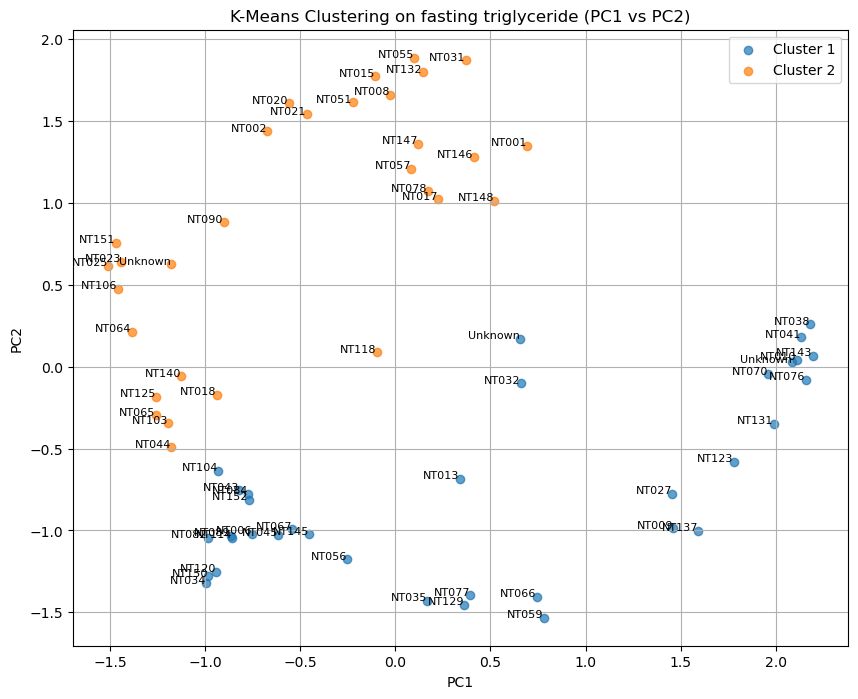

Kruskal-Wallis test result for fasting triglyceride (K-Means): H-statistic = 4.128222728216306, p-value = 0.04217362089147567
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T0__fasting triglyceride_kmean2_PC1v2_cluster_output.csv
[0.37824503 0.32473143]
Cluster 1 - Mean: 1.1572244180939835, Median: 1.03
Cluster 2 - Mean: 1.4193103448275863, Median: 1.2


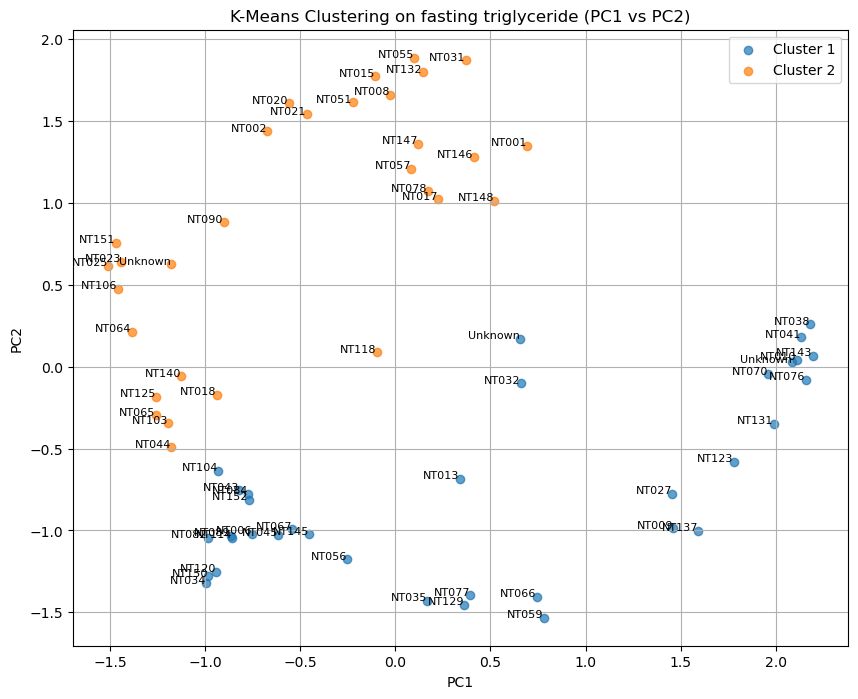

Kruskal-Wallis test result for fasting triglyceride (K-Means): H-statistic = 4.128222728216306, p-value = 0.04217362089147567
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T0__fasting triglyceride_kmean2_PC1v2_cluster_output.csv
[0.37824503 0.32473143]
Cluster 1 - Mean: 782.6393887242425, Median: 503.515526
Cluster 2 - Mean: 679.2604283865519, Median: 225.7936104


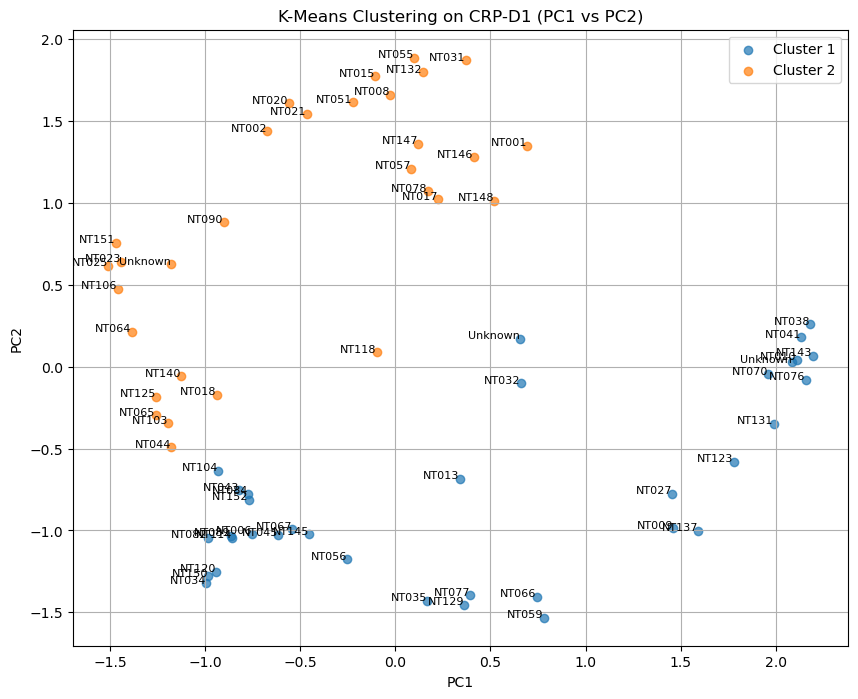

Kruskal-Wallis test result for CRP-D1 (K-Means): H-statistic = 5.785987958401762, p-value = 0.01615441603938217
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T0__CRP-D1_kmean2_PC1v2_cluster_output.csv
[0.37824503 0.32473143]
Cluster 1 - Mean: 782.6393887242425, Median: 503.515526
Cluster 2 - Mean: 679.2604283865519, Median: 225.7936104


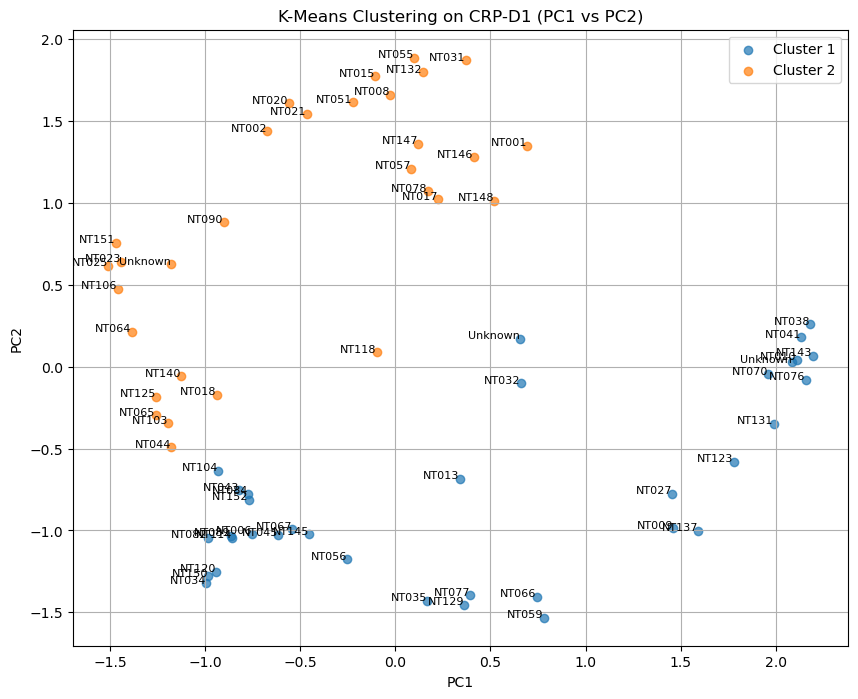

Kruskal-Wallis test result for CRP-D1 (K-Means): H-statistic = 5.785987958401762, p-value = 0.01615441603938217
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T0__CRP-D1_kmean2_PC1v2_cluster_output.csv
[0.37824503 0.32473143]
Cluster 1 - Mean: 203.93987694203128, Median: 153.55680497499998
Cluster 2 - Mean: 173.0351840424138, Median: 171.03181819999998


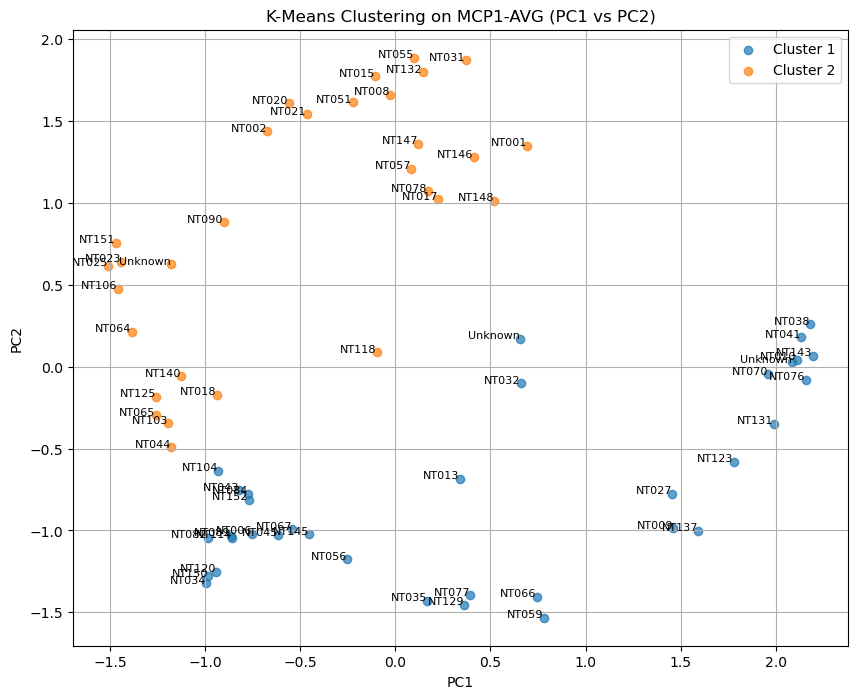

Kruskal-Wallis test result for MCP1-AVG (K-Means): H-statistic = 3.857619577308128, p-value = 0.049520539757273295
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T0__MCP1-AVG_kmean2_PC1v2_cluster_output.csv
[0.37824503 0.32473143]
Cluster 1 - Mean: 203.93987694203128, Median: 153.55680497499998
Cluster 2 - Mean: 173.0351840424138, Median: 171.03181819999998


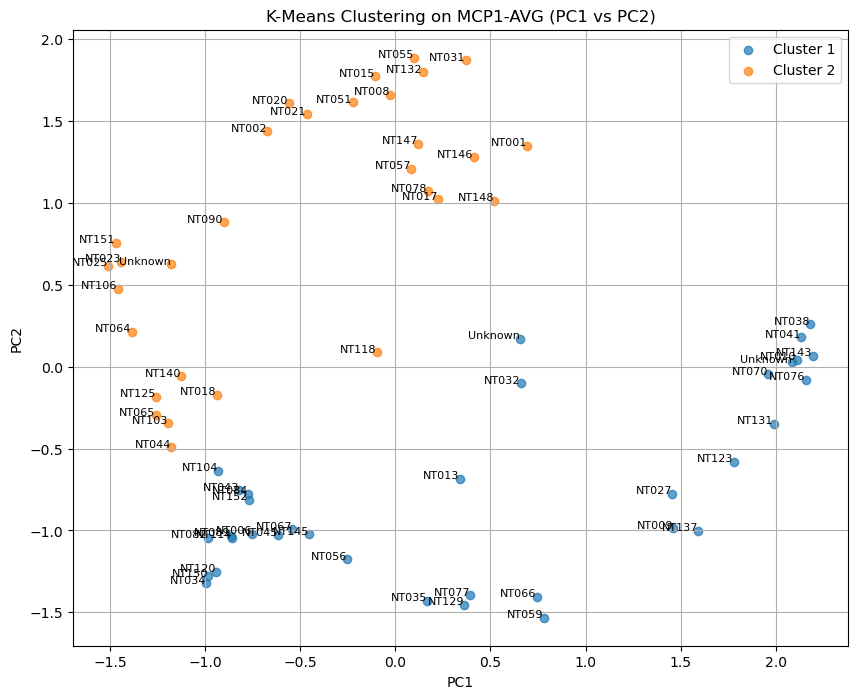

Kruskal-Wallis test result for MCP1-AVG (K-Means): H-statistic = 3.857619577308128, p-value = 0.049520539757273295
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T0__MCP1-AVG_kmean2_PC1v2_cluster_output.csv
[0.54239113 0.16269086]
Cluster 1 - Mean: 275.443733946875, Median: 251.08720485
Cluster 2 - Mean: 218.9419307063333, Median: 202.6546055


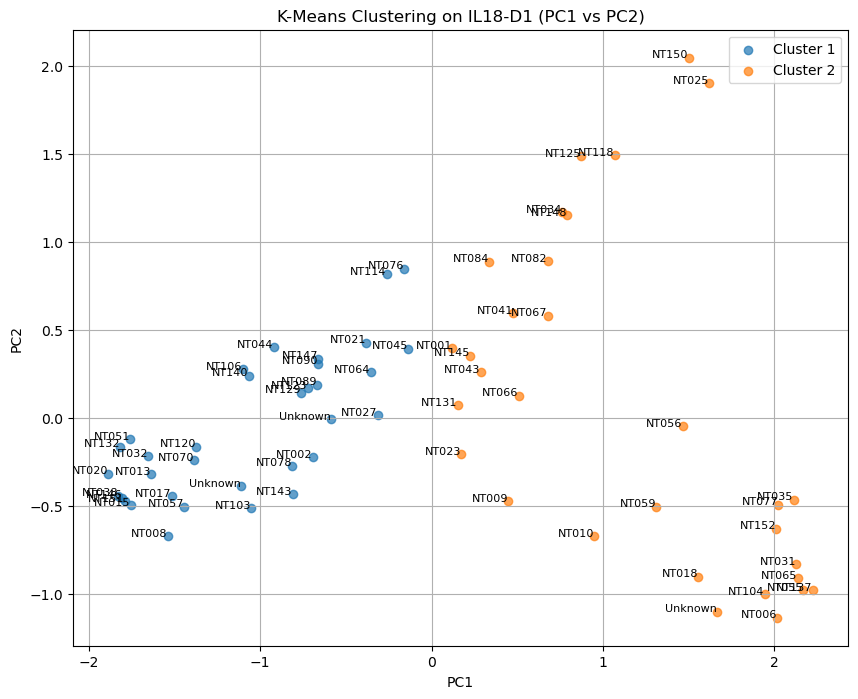

Kruskal-Wallis test result for IL18-D1 (K-Means): H-statistic = 4.49488955248002, p-value = 0.0339963097131697
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T120__IL18-D1_kmean2_PC1v2_cluster_output.csv
[0.54239113 0.16269086]
Cluster 1 - Mean: 275.443733946875, Median: 251.08720485
Cluster 2 - Mean: 218.9419307063333, Median: 202.6546055


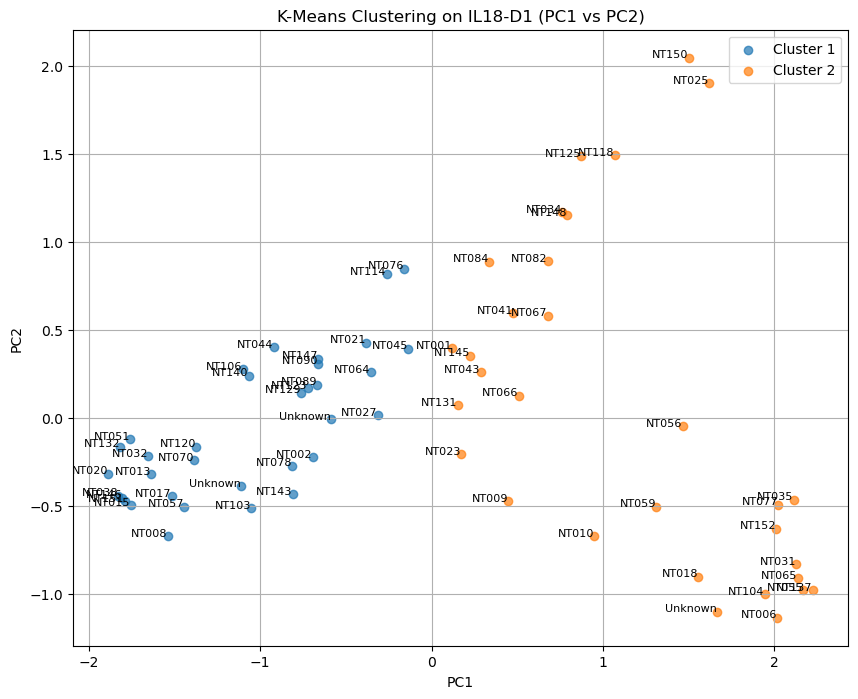

Kruskal-Wallis test result for IL18-D1 (K-Means): H-statistic = 4.49488955248002, p-value = 0.0339963097131697
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D2T120__IL18-D1_kmean2_PC1v2_cluster_output.csv
[0.378123   0.19748016]
Cluster 1 - Mean: 218.39980341282603, Median: 218.62408525
Cluster 2 - Mean: 260.4591388574193, Median: 251.15284300000002


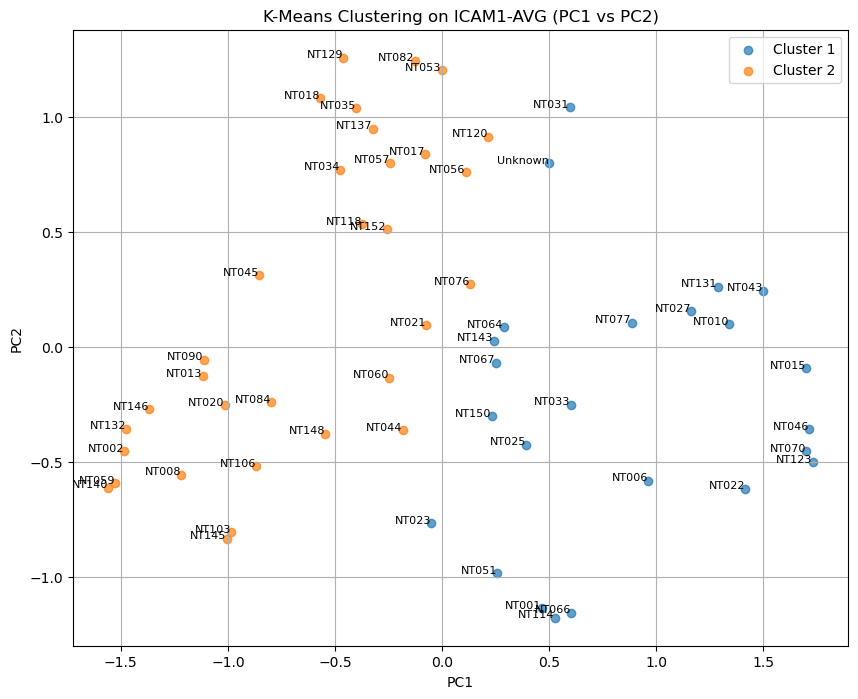

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 5.372306515364045, p-value = 0.020458906728038496
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D3T120__ICAM1-AVG_kmean2_PC1v2_cluster_output.csv
[0.378123   0.19748016]
Cluster 1 - Mean: 218.39980341282603, Median: 218.62408525
Cluster 2 - Mean: 260.4591388574193, Median: 251.15284300000002


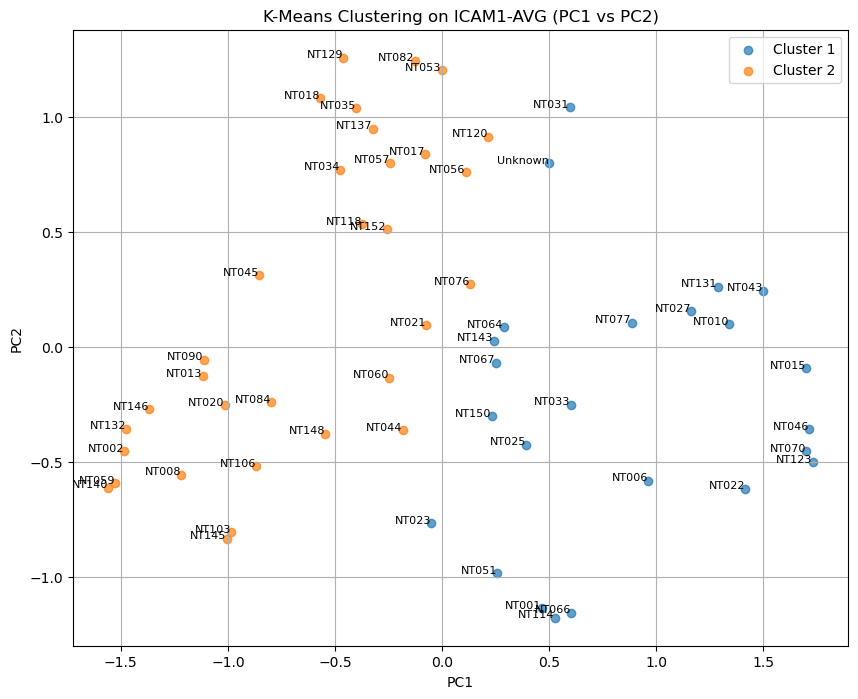

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 5.372306515364045, p-value = 0.020458906728038496
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D3T120__ICAM1-AVG_kmean2_PC1v2_cluster_output.csv
[0.48191545 0.23733323]
Cluster 1 - Mean: 978.1184472144188, Median: 501.1702419
Cluster 2 - Mean: 296.2411667625001, Median: 178.47868465


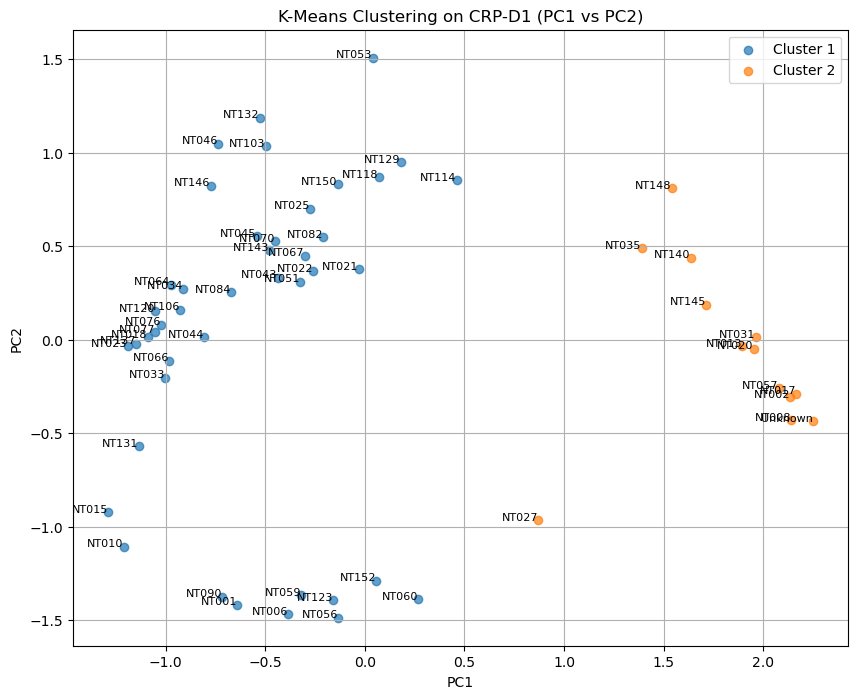

Kruskal-Wallis test result for CRP-D1 (K-Means): H-statistic = 7.456810631229246, p-value = 0.00631968782676081
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D3T240__CRP-D1_kmean2_PC1v2_cluster_output.csv
[0.48191545 0.23733323]
Cluster 1 - Mean: 978.1184472144188, Median: 501.1702419
Cluster 2 - Mean: 296.2411667625001, Median: 178.47868465


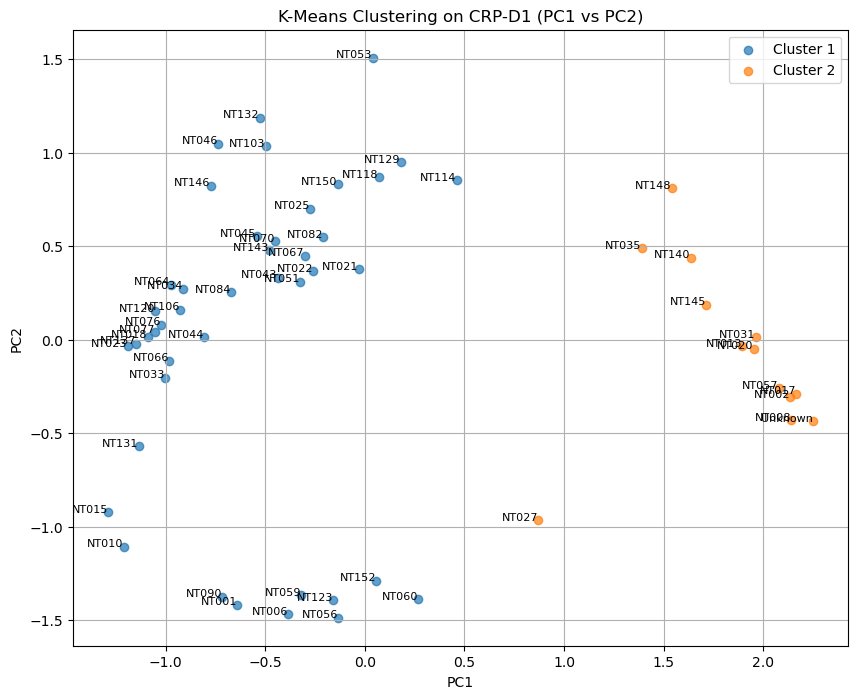

Kruskal-Wallis test result for CRP-D1 (K-Means): H-statistic = 7.456810631229246, p-value = 0.00631968782676081
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D3T240__CRP-D1_kmean2_PC1v2_cluster_output.csv
[0.48191545 0.23733323]
Cluster 1 - Mean: 242.79123864162793, Median: 228.4554831
Cluster 2 - Mean: 321.3177254083334, Median: 311.4471986


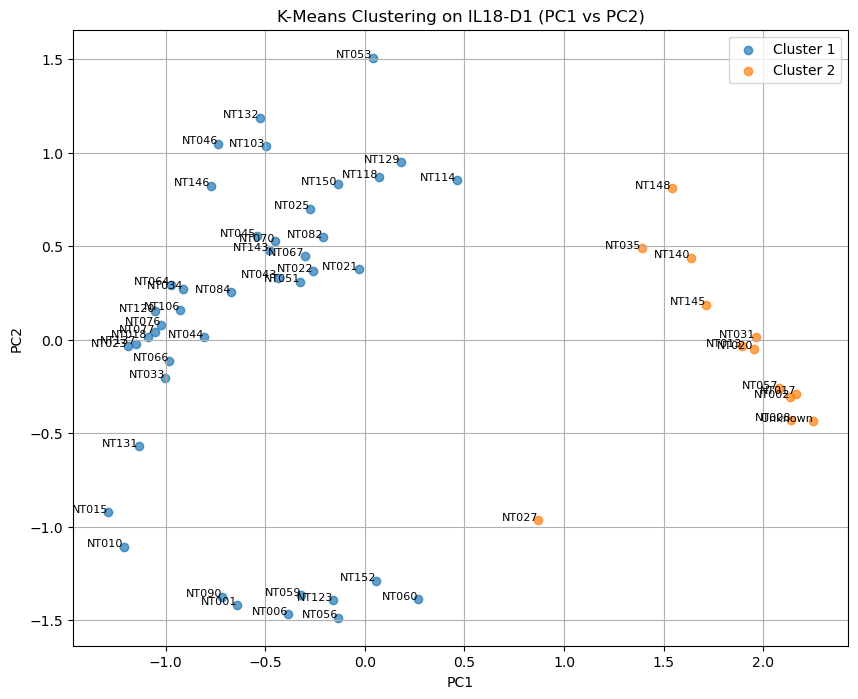

Kruskal-Wallis test result for IL18-D1 (K-Means): H-statistic = 5.931834316696298, p-value = 0.014869755768967497
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D3T240__IL18-D1_kmean2_PC1v2_cluster_output.csv
[0.48191545 0.23733323]
Cluster 1 - Mean: 242.79123864162793, Median: 228.4554831
Cluster 2 - Mean: 321.3177254083334, Median: 311.4471986


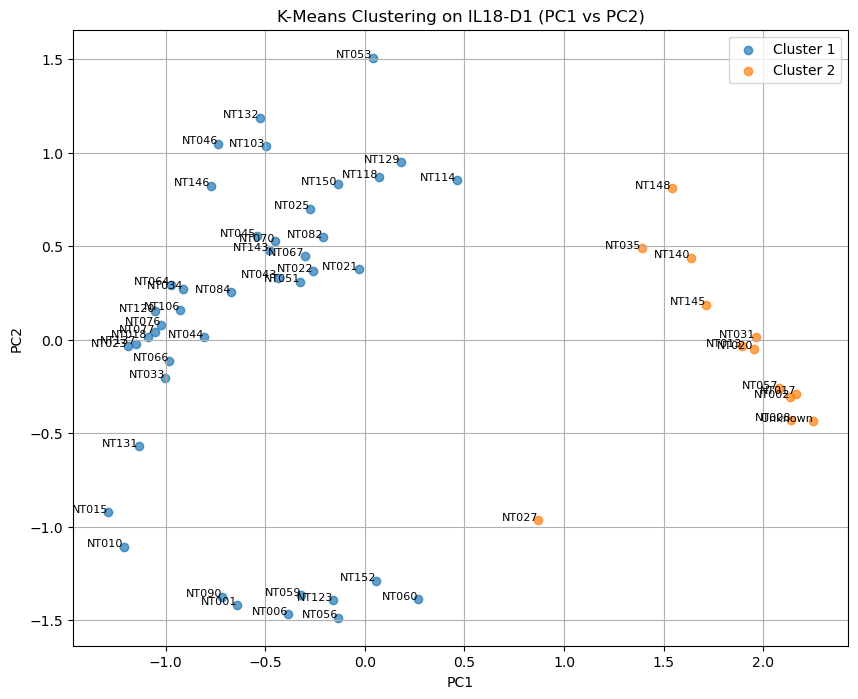

Kruskal-Wallis test result for IL18-D1 (K-Means): H-statistic = 5.931834316696298, p-value = 0.014869755768967497
Output saved to /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14/W5D3T240__IL18-D1_kmean2_PC1v2_cluster_output.csv


In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_pca_from_csv(csv_file_path):
    # Load the CSV file containing significant results
    results_df = pd.read_csv(csv_file_path)

    # Output directory
    output_dir = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 14'

    # Loop through each row of the CSV file and call analyze_pca_kmeans_vs_median2
    for index, row in results_df.iterrows():
        file_ID = row['File ID']  # Replace with the correct column name in your CSV
        variable_to_compare = row['Variable']  # Replace with the correct column name in your CSV

        # Call the analyze_pca_kmeans_vs_median2 function with the parameters from the current row
        analyze_pca_kmeans_vs_median2(
            file_ID=file_ID,
            n_components_pca=2,  # Assuming 2 components; modify if needed
            clusters_to_use=2,  # Assuming 2 clusters; modify if needed
            pc_x=0,  # PC1 (0-based index)
            pc_y=1,  # PC2 (0-based index)
            variable_to_compare=variable_to_compare,
            method='kmeans',  # Assuming k-means; modify if needed
            output_dir=output_dir  # Specify the output directory
        )

def analyze_pca_kmeans_vs_median2(file_ID, n_components_pca, clusters_to_use, pc_x, pc_y, variable_to_compare, method='kmeans', output_dir=''):
    # Load the data
    csv_file = f'{file_ID}.csv'  # File name of the dataset
    pw_flx1 = pd.read_csv(csv_file)
    file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
    xls = pd.ExcelFile(file_path)
    df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

    # Extract the participant IDs from NutriTech data
    nutritech_ids = df_week5_before['name'].tolist()
    pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

    # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv and retain original column names
    mapping = {}
    original_columns = {}
    for nt_id in nutritech_ids:
        if nt_id in pw_flx1_ids.values:
            matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
            mapping[nt_id] = matched_column
            original_columns[nt_id] = matched_column  # Store the original column name

    # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
    pca_labels = []
    nutritech_labels = []
    original_column_names = []
    for column in pw_flx1.columns:
        matched_id = next((key for key, value in mapping.items() if value == column), None)
        if matched_id:
            label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
            pca_labels.append(label)
            nutritech_labels.append(matched_id)
            original_column_names.append(original_columns[matched_id])
        else:
            pca_labels.append(np.nan)  # Handle missing data
            nutritech_labels.append('Unknown')
            original_column_names.append(column)  # Keep original name for unknowns

    pca_labels = np.array(pca_labels)
    finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
    norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())

    cmap = plt.cm.viridis
    colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

    # Step 2: Perform PCA
    pca = PCA(n_components=n_components_pca)
    pcaData = pca.fit_transform(pw_flx1.T)
    print(pca.explained_variance_ratio_)

    # Choose the method: 'kmeans' or 'median_split'
    if method == 'kmeans':
        # Step 3a: Perform K-Means Clustering
        kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

        # Calculate mean and median for each cluster
        for i in range(clusters_to_use):
            cluster_values = pca_labels[clusters == i]
            cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
            if len(cluster_values) > 0:
                cluster_mean = np.mean(cluster_values)
                cluster_median = np.median(cluster_values)
                print(f"Cluster {i+1} - Mean: {cluster_mean}, Median: {cluster_median}")
            else:
                print(f"Cluster {i+1} has no valid data.")

        # Step 4a: Visualize PCA with K-Means Clusters and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for i in range(clusters_to_use):
            cluster_indices = clusters == i
            plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
            for j in np.where(cluster_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5a: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_clusters = []
        for i in range(clusters_to_use):
            cluster_values = pca_labels[clusters == i]
            cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
            if len(cluster_values) > 0:
                valid_clusters.append(cluster_values)

        if len(valid_clusters) > 1:
            kruskal_results = kruskal(*valid_clusters)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (K-Means): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid clusters for Kruskal-Wallis test for {variable_to_compare} (K-Means).")

        # Step 6: Prepare Group/Cluster Assignments for Saving
        assignment_data = pd.DataFrame({
            'Cluster': clusters,
            'NutriTech ID': nutritech_labels,
            'model_id': original_column_names,  # Include original column names
            f'{variable_to_compare}': pca_labels
        })

        # Step 7: Sort the data by Cluster and NutriTech ID
        assignment_data = assignment_data.sort_values(by=['Cluster', 'NutriTech ID'])

        # Save to a CSV file in the specified output directory
        output_file = f'{output_dir}/{file_ID}_{variable_to_compare}_kmean2_PC1v2_cluster_output.csv'
        assignment_data.to_csv(output_file, index=False)
        print(f"Output saved to {output_file}")

    else:
        print("Invalid method. Choose 'kmeans' or 'median_split'.")

# Example usage
analyze_pca_from_csv(csv_file_path='pca_analysis_significant_results.csv')


## Function 5 part 2 (modified Function 1), analyze_pca_kmeans_vs_median2, expands cluster output with model ID and is saveable

this needs to be modified, funciton 5 read in clusters as Cluster 1 or Cluster 2, my input file will be 0 or 1, that needs to change 

Input: .csv file output of function 3,def process_all_cluster_files3():if file_name.endswith('kmean2_PC1v2_cluster_output.csv>pca_analysis_results_multiple_files.csv'):
significant_results_df.to_csv(f'{file_name}>SIGNIFICAN_RESULTS.csv', index=False)

Output: a csv file into the cluster_files directory for each significant result that has all cluster information which can be used in function 6, generates cluster information with NTID and modelid and if they belong to cluster 0 or 1 for a certain variable

```python
# Step 6: Prepare Group/Cluster Assignments for Saving
        assignment_data = pd.DataFrame({
            'Cluster': clusters,
            'NutriTech ID': nutritech_labels,
            'model_id': original_column_names,  # Include original column names
            f'{variable_to_compare}': pca_labels
        })

# Example usage
analyze_pca_kmeans_vs_median2(
    file_ID='W5D3T120_',
    n_components_pca=2,
    clusters_to_use=2,
    pc_x=0,
    pc_y=1,
    variable_to_compare='ICAM1-AVG',
    method='kmeans'
)
```

### Code i need to get around to that will help with ninas code

In [ ]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")



In [ ]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



In [ ]:
#%% Perform flux correlation between pairs of models
pw_flx2 = flux_DM(flx_df)
pw_flx2
# Save pw_flx1 as a CSV file
pw_flx2.to_csv('pw_flx2.csv', index=False)

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

In [ ]:
# ninas code 
def discr_rxns_analysis(flx, label):
    p = []
    s = []
    flx = flx.fillna(0)

    for reaction in range(flx.values[:, 0].size):
        flx_0 = flx.values[reaction, label[0]]
        flx_1 = flx.values[reaction, label[1]]
        try:
            stat, pval = stats.mstats.kruskalwallis(flx_0, flx_1)
            p.append(pval)
            s.append(stat)
        except ValueError:
            p.append(1)
            pass
    return p
    print(s)

'''####### I have this in my flx files, eg. W5D3T0_.csv
# %% Load the context-specific models
path_lib = []
for p in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
'21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
'41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
'61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']:
    path_lib.append('/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteCSM/models/csm_Monocyte_ ' + p + '.mat')

path_ref = '/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteNina.mat'

ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)
#######'''

####### Not sure what this does yet, not needed yet anyway , where does rxnsSub come form etc?
# %% Load the pathways of reactions
with open('/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteCSM/distanceMetrics/reactions/rxnsSub.json') as f:
    rxnsSub = json.load(f)

with open('/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteCSM/distanceMetrics/reactions/rxnsDes.json') as f:
    rxnsDes = json.load(f)

with open('/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteCSM/distanceMetrics/reactions/rxns.json') as f:
    reactions = json.load(f)

reactions = reactions[0]
rxnsSub = rxnsSub[0]
rxnsDes = rxnsDes[0]
######## 

##### These are to be change to  my cluster 0 and 1
# %% Model group numbers
#Model numbers for BMI classes
ov_index = []
for i in [29, 22, 11, 8, 37, 13, 9, 52, 57, 12, 47, 67, 14, 19, 25, 60, 31,
         16, 21, 1, 3, 62, 17, 56, 54, 15, 6, 71, 45, 66, 7, 70, 28, 48, 65, 36, 20, 5]:
    ov_index.append(i-1)
ob_index = []
for i in [24, 63, 53, 35, 44, 46, 30, 42, 39, 41, 58, 64, 26, 32, 2, 51, 33, 40,
          34, 18, 27, 61, 49, 38, 10, 50, 4, 43, 59, 69, 3, 55, 68]:
    ob_index.append(i-1)
######


###### Dont need this yet anyway , where does keys and values come from?
'''#%% Plots bar chart of all significantly changed pathways

plt.figure
plt.barh(keys, values, 0.5)
title_font = {
'weight' : 'medium',
'size'   : 12,
}

axis_font = {
'weight' : 'normal',
'size'   : 10,
}

#Change titles accordingly
plt.title('Fasting Glucose (mM)', title_font)
plt.xlabel('Number of Significantly Changed Reactions', axis_font)
plt.ylabel('Pathway in Monocyte Model', axis_font)
plt.yticks(fontsize = 8)
plt.tight_layout()
plt.savefig('/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteCSM/distanceMetrics/reactions/monocyteGlucose.png', bbox_inches = 'tight', dpi = 1000)
#######'''

#####
#%% Statistical test between two groups
df = discr_rxns_analysis(flx, [ov_index, ob_index])
sValue = []
dfRec = []
pathSub = []
pathDesSub = []
recSig = []

for i in range(len(df)):
    if df[i] < 0.05 and rxnsSub[i][:9] != 'Transport' and rxnsSub[i][:4] != 'None' and rxnsSub[i][:8] != 'Exchange':

       sValue.append(df[i])
       dfRec.append(reactions[i])
       pathSub.append(rxnsSub[i])
       pathDesSub.append(rxnsDes[i])
       recSig.append([i, rxnsSub[i]])

df_output = pd.DataFrame.from_dict({'Pathway': pathSub, 'Reaction ID': dfRec, 'Reaction Name': pathDesSub})
print(df_output)
#Change title of file accordingly
df_output.to_csv('/Users/NinaValenbreder/Projects/btr/Interncode/nina/contextSpecificModels/monocyteCSM/distanceMetrics/monocyteFluxScripts/Glucose.csv')



### my code that works, doesnt have reactions tho, used to create function 6

In [131]:
# Load the CSV file that contains the cluster assignments
cluster_file_name = 'W5D3T120__ICAM1-AVG_kmean2_PC1v2_cluster_output.csv'
cluster_data = pd.read_csv(cluster_file_name)

# Extract the flux data file name from the cluster file name
# The flux file name is assumed to be everything before the first '__' in the cluster file name
#flx_file_name = cluster_file_name.split('_')[0] + '_.csv'

# Extract the flux data file name from the cluster file name
flx_file_name = 'flx_df_' + cluster_file_name.split('_')[0] + '_.csv'
flx_file_title = cluster_file_name.split('_kmean2_PC1v2_cluster_output.csv')[0] 

# Load the flux data
flx = pd.read_csv(flx_file_name, index_col=0) 
flx = flx.fillna(0) # replace nan with 0
# Keep only the first 100 rows
#flx_trimmed = flx.head(1000)

# Save the trimmed DataFrame as a new CSV file
#flx_trimmed.to_csv('W5D3T120__ICAM1_practice_flux_data.csv')

In [132]:
flx

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
24_25DHVITD3tm                                                     0.0                                                                                                                                                                                                                  
25HVITD3t                                                          0.0                                                                                                                                                                                                                  
COAtl                                                              0.0                                                                                                                                                                                                                  
EX_5adtststerone_e                                                 0.0                                                                                                                                                                                                                  
EX_5adtststerones_e                                                0.0                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                       0.0                                                                                                                                                                                                                  
FVSCOAhc                                                           0.0                                                                                                                                                                                                                  
MDZGLChr                                                           0.0                                                                                                                                                                                                                  
TMACMPhr                                                           0.0                                                                                                                                                                                                                  
CYSACMPitr                                                         0.0                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
24_25DHVITD3tm                                                     0.0                                                                                                                                                                                                                  
25HVITD3t                                                          0.0                

# unused code, but used to create functions

In [143]:
df_filtered=df_filteredOG
# Define significance level
alpha = 0.05

# Filter for significant p-values
significant_df = df_filtered[df_filtered['P-Value'] < alpha]

# Display the significant DataFrame
print("Significant Reactions:")
print(significant_df)


Significant Reactions:
     flx Row Index Reaction Name   P-Value  Statistic
10             167         ASCBt  0.044608   4.033385
21             831       GLPASE1  0.000003  21.729075
24             863         GTHPm  0.026210   4.942130
25             873        H2O2tm  0.011968   6.315585
41            1414         THD1m  0.044564   4.035075
59            1730         r1155  0.019065   5.495588
62            1857         r1671  0.041680   4.148148
74            2324       RE2526C  0.000886  11.051897
87            2483      HCO3_NAt  0.001556  10.011103
107           3727        DXTRNt  0.000003  21.729075
108           3731           PGM  0.005154   7.824713
109           3733          PGMT  0.000003  21.729075
124           3832           PYK  0.003382   8.589052
131           4114        GLCNte  0.000026  17.702411
132           4118        LACROX  0.000886  11.051897
147           5641         ATPtm  0.015479   5.861123
149           5815       DHAAt1r  0.044608   4.033385
155  

In [144]:
# Bonferroni correction
bonferroni_alpha = alpha / len(df_filtered)  # Adjusted significance level
significant_bonferroni_df = df_filtered[df_filtered['P-Value'] < bonferroni_alpha]

# Display Bonferroni significant results
print("Bonferroni Corrected Significant Reactions:")
print(significant_bonferroni_df)


Bonferroni Corrected Significant Reactions:
     flx Row Index Reaction Name   P-Value  Statistic
21             831       GLPASE1  0.000003  21.729075
107           3727        DXTRNt  0.000003  21.729075
109           3733          PGMT  0.000003  21.729075
131           4114        GLCNte  0.000026  17.702411


In [145]:
import pandas as pd
from scipy.stats import false_discovery_control
# Apply false discovery control using Benjamini-Hochberg (bh) method from scipy.stats
bh_adjusted_p_values = false_discovery_control(df_filtered['P-Value'], method='bh')

# Add the adjusted p-values to the DataFrame
df_filtered['BH Adjusted P-Value'] = bh_adjusted_p_values

# Filter for significant p-values after BH correction (for example, using alpha = 0.05)
alpha = 0.05
significant_bh_df = df_filtered[df_filtered['BH Adjusted P-Value'] < alpha]

# Display significant results after BH correction
print("Significant Reactions after BH Correction:")
print(significant_bh_df)


Significant Reactions after BH Correction:
     flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value
21             831       GLPASE1  0.000003  21.729075             0.000262
74            2324       RE2526C  0.000886  11.051897             0.024610
87            2483      HCO3_NAt  0.001556  10.011103             0.031091
107           3727        DXTRNt  0.000003  21.729075             0.000262
109           3733          PGMT  0.000003  21.729075             0.000262
131           4114        GLCNte  0.000026  17.702411             0.001614
132           4118        LACROX  0.000886  11.051897             0.024610
164           6531          PGLc  0.000333  12.872236             0.013896
188           7543       G6PDH2r  0.000333   1.333333             0.013896
202           7906     IDL_HSSYN  0.001153   1.527273             0.026208
203           7907     IDL_HSDEG  0.001153   0.499816             0.026208
204           7965          DACT  0.000886  10.563941    

In [146]:
# Benjamini-Yekutieli (BY) method
by_adjusted_p_values = false_discovery_control(df_filtered['P-Value'], method='by')

# Add BY adjusted p-values to the DataFrame
df_filtered['BY Adjusted P-Value'] = by_adjusted_p_values

# Filter for significant p-values after BY correction
significant_by_df = df_filtered[df_filtered['BY Adjusted P-Value'] < alpha]

# Display significant results after BY correction
print("Significant Reactions after BY Correction:")
print(significant_by_df)

Significant Reactions after BY Correction:
     flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value  BY Adjusted P-Value
21             831       GLPASE1  0.000003  21.729075             0.000262             0.001596
107           3727        DXTRNt  0.000003  21.729075             0.000262             0.001596
109           3733          PGMT  0.000003  21.729075             0.000262             0.001596
131           4114        GLCNte  0.000026  17.702411             0.001614             0.009849


In [83]:
# Step 1: Read the TSV file but only load the column names
reaction_data = pd.read_csv('recon-store-reactions-1.tsv', sep='\t', nrows=0)  # nrows=0 loads just the column names

# Print the column names to see what is available
print("Available Columns:", reaction_data.columns)

Available Columns: Index(['abbreviation', 'description', 'formula', 'subsystem', 'ecnumber', 'keggId', 'keggorthology', 'cog', 'seed', 'metanetx'], dtype='object')


In [147]:
# Adjust pandas settings for better display
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Set a reasonable row limit, or None for all rows
pd.set_option('display.width', 180)        # Increase the display width for wider data
pd.set_option('display.max_colwidth', 50) # Step 1: Read the reaction data from the TSV file
reaction_data = pd.read_csv('recon-store-reactions-1.tsv', sep='\t')

# Step 2: Assuming df_filtered is already created, now merge based on 'Reaction Name' in df_filtered and 'abbreviation' in reaction_data
df_merged = pd.merge(significant_df, reaction_data, left_on='Reaction Name', right_on='abbreviation', how='left')

# Step 3: Display the merged DataFrame
print(df_merged)

    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                        description                                            formula  \
0             167         ASCBt  0.044608   4.033385        ASCBt    L-Ascorbate Transport via Facilitated Diffusion                           ascb_L[e] <=> ascb_L[c]    
1             831       GLPASE1  0.000003  21.729075      GLPASE1           Glycogen Phosphorylase (Glygn2 -> Dxtrn)    glygn2[c] + 3.0 pi[c] -> dxtrn[c] + 3.0 g1p[c]    
2             863         GTHPm  0.026210   4.942130        GTHPm               Glutathione Peroxidase, Mitochondria   2.0 gthrd[m] + h2o2[m] -> gthox[m] + 2.0 h2o[m]    
3             873        H2O2tm  0.011968   6.315585       H2O2tm          Hydrogen Peroxide Mitochondrial Transport                                h2o2[c] -> h2o2[m]    
4            1414         THD1m  0.044564   4.035075        THD1m                           NAD (P) Transhydrogenase  h[c] + nadh[m] + nadp[m] ->

In [148]:
import pandas as pd



import pandas as pd

# Step 1: Select specific columns (for example: Available Columns: Index(['abbreviation', 'description', 'formula', 'subsystem', 'ecnumber', 'keggId', 'keggorthology', 'cog', 'seed', 'metanetx'], dtype='object')
selected_columns = ['abbreviation', 'description', 'subsystem']  # Choose the columns you want
#: Read only the selected columns from the file
reaction_data_selected = pd.read_csv('recon-store-reactions-1.tsv', sep='\t', usecols=selected_columns)
# Step 4: Merge df_filtered with the selected columns from reaction_data_selected
df_merged = pd.merge(significant_df, reaction_data_selected, left_on='Reaction Name', right_on='abbreviation', how='left')

# Step 5: Display the merged DataFrame
print(df_merged)


    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                        description                       subsystem
0             167         ASCBt  0.044608   4.033385        ASCBt    L-Ascorbate Transport via Facilitated Diffusion        Transport, extracellular
1             831       GLPASE1  0.000003  21.729075      GLPASE1           Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
2             863         GTHPm  0.026210   4.942130        GTHPm               Glutathione Peroxidase, Mitochondria          Glutathione metabolism
3             873        H2O2tm  0.011968   6.315585       H2O2tm          Hydrogen Peroxide Mitochondrial Transport        Transport, mitochondrial
4            1414         THD1m  0.044564   4.035075        THD1m                           NAD (P) Transhydrogenase                  NAD metabolism
5            1730         r1155  0.019065   5.495588        r1155                    Tcdb:2.A.1.13.5 Tcdb:

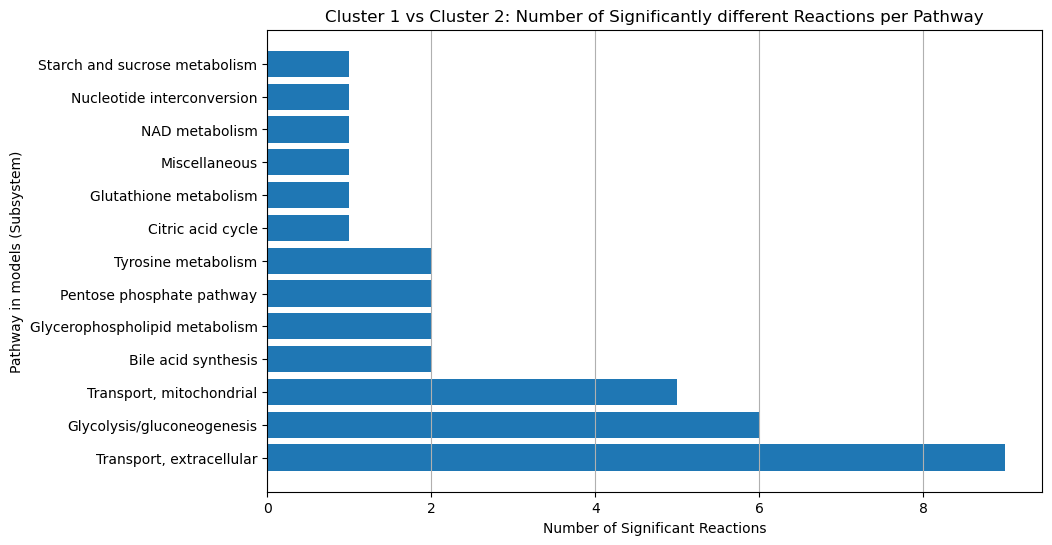

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_merged is the result of your merged data
# Step 1: Group by 'subsystem' and count the number of reactions in each pathway
pathway_counts = df_merged.groupby('subsystem').size().reset_index(name='Number of Significant Reactions')

# Step 2: Sort the values by the number of significant reactions (optional, for better visualization)
plot_df = pathway_counts.sort_values(by='Number of Significant Reactions', ascending=False)

# Step 3: Plot the Results
plt.figure(figsize=(10, 6))
plt.barh(plot_df['subsystem'], plot_df['Number of Significant Reactions'])
plt.xlabel('Number of Significant Reactions')
plt.ylabel('Pathway in models (Subsystem)')
plt.title('Cluster 1 vs Cluster 2: Number of Significant Reactions per Pathway')
plt.grid(True, axis='x')
plt.show()


# Function 6, analyze_cluster_and_flux
input: Function 5 generated csv. file 
ouput: incomplete but it will check significanlyt different reactions and generate a plot with the pathways 

In [251]:
import pandas as pd
from scipy import stats

def analyze_cluster_and_flux(cluster_file_name):
    # Load the cluster data
    cluster_data = pd.read_csv(cluster_file_name)
    name_ID=cluster_file_name.split('-')[0]
    # Extract the flux data file name from the cluster file name
    flx_file_name = 'flx_df_' + cluster_file_name.split('_')[0] + '_.csv'
    
    # Load the flux data
    flx = pd.read_csv(flx_file_name, index_col=0)
    flx = flx.fillna(0)  # replace nan with 0
    
    # Initialize lists to store indices for cluster 0 and cluster 1
    cluster_0_indices = []
    cluster_1_indices = []

    # Iterate through the rows of the cluster data to match model_ids to flx column headers
    for idx, row in cluster_data.iterrows():
        model_id = row['model_id']
        cluster = row['Cluster']

        # Find the matching column index in flx for this model_id
        try:
            flx_index = flx.columns.get_loc(model_id)
            if cluster == 0:
                cluster_0_indices.append(flx_index)
            elif cluster == 1:
                cluster_1_indices.append(flx_index)
        except KeyError:
            print(f"Model ID {model_id} not found in flx columns.")
    
    # Perform discriminative reactions analysis using the two cluster indices
    def discr_rxns_analysis(flx, label):
        p = []
        s = []
        flx = flx.fillna(0)

        for reaction in range(flx.values[:, 0].size):
            flx_0 = flx.values[reaction, label[0]]
            flx_1 = flx.values[reaction, label[1]]
            try:
                stat, pval = stats.mstats.kruskalwallis(flx_0, flx_1)
                p.append(pval)
                s.append(stat)
            except ValueError:
                p.append(1)
                pass
        return p, s  # Return both p-values and statistics for further analysis

    # Example p-values and statistics (these would come from your discr_rxns_analysis function)
    p_values, statistics = discr_rxns_analysis(flx, [cluster_0_indices, cluster_1_indices])

    # Create a list to store the original indices, the non-1 p-values, reaction names, and statistics
    filtered_p_values = []
    filtered_indices = []
    reaction_names = []
    filtered_statistics = []

    # Create a counter for the statistics list
    stat_counter = 0

    # Iterate over the p_values and collect non-1 values along with their original indices, reaction names, and statistics
    for i, p in enumerate(p_values):
        if p != 1:
            filtered_p_values.append(p)
            filtered_indices.append(i)
            reaction_names.append(flx.index[i])  # Assuming the index of flx_trimmed has reaction names
            filtered_statistics.append(statistics[stat_counter])  # Append statistics in sequence
            stat_counter += 1  # Increment the counter for the statistics list

    # Create a DataFrame with the original row index, reaction names, p-values, and statistics
    df_filteredOG = pd.DataFrame({
        'flx Row Index': filtered_indices,
        'Reaction Name': reaction_names,
        'P-Value': filtered_p_values,
        'Statistic': filtered_statistics
    })
    print(name_ID)

    # Return the DataFrame
    return df_filteredOG,name_ID

# Example usage:
df_result,name_ID = analyze_cluster_and_flux('W5D3T120__ICAM1-AVG_kmean2_PC1v2_cluster_output.csv')
print(df_result)
print(name_ID)

W5D3T120__ICAM1
     flx Row Index Reaction Name   P-Value  Statistic
0               28       34HPLFM  0.248213   1.333333
1               96        ACONTm  0.425337   0.635521
2              100         ACt2r  0.126673   2.332810
3              102          ADK3  0.386476   0.750000
4              122      AKGMALtm  0.425337   0.635521
5              130      ALCD21_D  0.665764   0.186597
6              131      ALCD22_D  0.386476   0.750000
7              139          ALR2  0.884685   0.021035
8              140          ALR3  0.884685   0.021035
9              145         AMPDA  0.386476   0.750000
10             167         ASCBt  0.044608   4.033385
11             235          CATm  0.469657   0.522784
12             266         CO2tm  0.172212   1.863583
13             319        CYTK14  0.248213   1.333333
14             322         CYTK3  0.248213   1.333333
15             323         CYTK4  0.248213   1.333333
16             327         CYTK7  0.248213   1.333333
17          

# Function 7 , multiple analysis
input: function 6 output, select method of multiple analysis of ractions

ouput: sifnificant results in clusters between reactions, plot to show significant pathways

Significant Reactions after Bonferroni Correction:
Merged DataFrame:
   flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000003  21.729075      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           3727        DXTRNt  0.000003  21.729075       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
2           3733          PGMT  0.000003  21.729075         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
3           4114        GLCNte  0.000026  17.702411       GLCNte  Assumed Passive Diffusion into Extracellular Space       Transport, extracellular


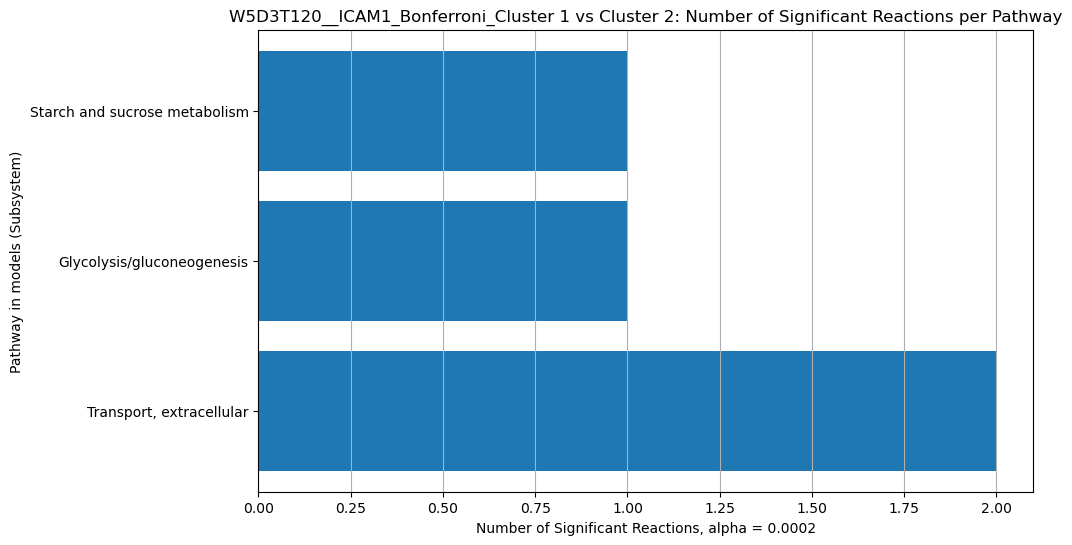

In [263]:
import pandas as pd
from scipy.stats import false_discovery_control
import matplotlib.pyplot as plt

def filter_and_visualize_significant_reactions(df_filteredOG, method,name_ID):
    """
    Filters and visualizes significant reactions based on the selected method.
    
    Parameters:
    df_filteredOG (DataFrame): Input DataFrame with reactions and P-Values.
    method (int): Integer value representing the significance testing method.
                  1: Standard p-value
                  2: Bonferroni correction
                  3: Benjamini-Hochberg (BH) correction
                  4: Benjamini-Yekutieli (BY) correction
    """
    # Define the significance level
    alpha = 0.05
    
    if method == 1:
        df_filteredOG1 = df_filteredOG
        # Standard p-value threshold
        significant_df = df_filteredOG1[df_filteredOG1['P-Value'] < alpha]
        method_name = f'p value'
        print("Significant Reactions (Standard p-value):")

    elif method == 2:
        # Bonferroni correction
        df_filteredOG2 = df_filteredOG
        alpha = alpha / len(df_filteredOG2)  # Adjusted significance level
        significant_bonferroni_df = df_filteredOG2[df_filteredOG2['P-Value'] < alpha]
        method_name='Bonferroni'
        print("Significant Reactions after Bonferroni Correction:")
        significant_df = significant_bonferroni_df

    elif method == 3:
        # Benjamini-Hochberg (BH) correction
        df_filteredOG3 = df_filteredOG
        bh_adjusted_p_values = false_discovery_control(df_filteredOG3['P-Value'], method='bh')
        df_filteredOG3['BH Adjusted P-Value'] = bh_adjusted_p_values
        significant_bh_df = df_filteredOG3[df_filteredOG3['BH Adjusted P-Value'] < alpha]
        method_name = "BH Correction"
        print("Significant Reactions after BH Correction:")
        significant_df = significant_bh_df

    elif method == 4:
        # Benjamini-Yekutieli (BY) correction
        df_filteredOG4 = df_filteredOG
        by_adjusted_p_values = false_discovery_control(df_filteredOG4['P-Value'], method='by')
        df_filteredOG4['BY Adjusted P-Value'] = by_adjusted_p_values
        significant_by_df = df_filteredOG4[df_filteredOG4['BY Adjusted P-Value'] < alpha]
        method_name = "BY Correction"
        print("Significant Reactions after BY Correction:")
        significant_df = significant_by_df

    else:
        print("Invalid choice. Please select a valid option (1-4).")
        return None

    # Step 2: Process and visualize the significant reactions
    tsv_file_name = 'recon-store-reactions-1.tsv'
    selected_columns = ['abbreviation', 'description', 'subsystem']  # Columns to load from TSV
    reaction_data_selected = pd.read_csv(tsv_file_name, sep='\t', usecols=selected_columns)
    
    # Merge df_significant with the selected columns from reaction_data_selected
    df_merged = pd.merge(significant_df, reaction_data_selected, left_on='Reaction Name', right_on='abbreviation', how='left')
    
    # Display the merged DataFrame (optional)
    print("Merged DataFrame:")
    print(df_merged)

    # Group by 'subsystem' and count the number of reactions in each pathway
    pathway_counts = df_merged.groupby('subsystem').size().reset_index(name='Number of Significant Reactions')

    # Sort the values by the number of significant reactions (optional, for better visualization)
    plot_df = pathway_counts.sort_values(by='Number of Significant Reactions', ascending=False)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.barh(plot_df['subsystem'], plot_df['Number of Significant Reactions'])
    plt.xlabel(f'Number of Significant Reactions, alpha = {alpha}')
    plt.ylabel('Pathway in models (Subsystem)')
    plt.title(f'{name_ID}_{method_name}_Cluster 1 vs Cluster 2: Number of Significant Reactions per Pathway')
    plt.grid(True, axis='x')
    plt.show()

    # Return the merged DataFrame and the pathway counts for further analysis if needed
    return df_merged, plot_df

# Example usage:
df_merged_result, plot_result = filter_and_visualize_significant_reactions(df_result, 2,name_ID)  # Pass method as an argument


# FINAL analysis, process all cluster files, with method 1 significance < 0.05, save plots to list for easy view


function 7 V2, modified to make a list for viewing all plots

W5D3T240__IL18
     flx Row Index Reaction Name       P-Value  Statistic
0               28       34HPLFM  3.814843e-01   0.765913
1               96        ACONTm  1.337097e-03  10.290598
2              100         ACt2r  1.855051e-04  13.972491
3              122      AKGMALtm  1.337097e-03  10.290598
4              130      ALCD21_D  1.835228e-01   1.768864
5              131      ALCD22_D  3.321859e-01   0.940357
6              135        ALDD2y  5.824281e-01   0.302326
7              139          ALR2  4.614156e-01   0.542459
8              140          ALR3  4.614156e-01   0.542459
9              172         ASNt4  5.824281e-01   0.302326
10             235          CATm  7.091401e-01   0.139137
11             266         CO2tm  5.880720e-03   7.586494
12             319        CYTK14  5.719454e-01   0.319438
13             322         CYTK3  6.895626e-02   3.307692
14             323         CYTK4  5.824281e-01   0.302326
15             329         CYTK8  5.824281e-01   0.302326

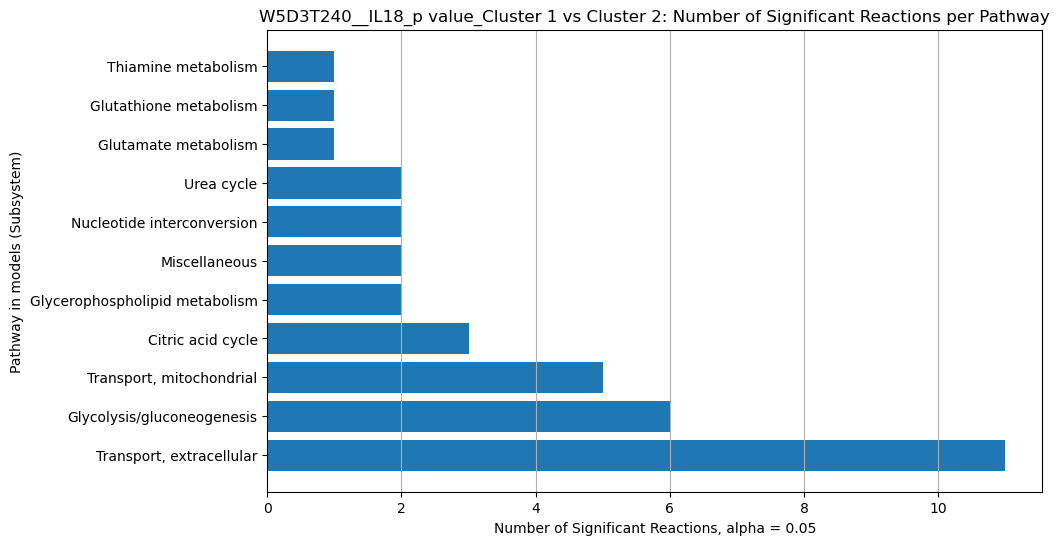

Merged result:
    flx Row Index Reaction Name       P-Value  Statistic abbreviation                                                  description                       subsystem
0              96        ACONTm  1.337097e-03  10.290598       ACONTm                                          Aconitate Hydratase               Citric acid cycle
1             100         ACt2r  1.855051e-04  13.972491        ACt2r              Acetate Reversible Transport via Proton Symport        Transport, extracellular
2             122      AKGMALtm  1.337097e-03  10.290598     AKGMALtm                       Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
3             266         CO2tm  5.880720e-03   7.586494        CO2tm                     CO2 Transport (Diffusion), Mitochondrial        Transport, mitochondrial
4             863         GTHPm  2.644580e-02   4.926633        GTHPm                         Glutathione Peroxidase, Mitochondria          Glutathione metabolism
5      

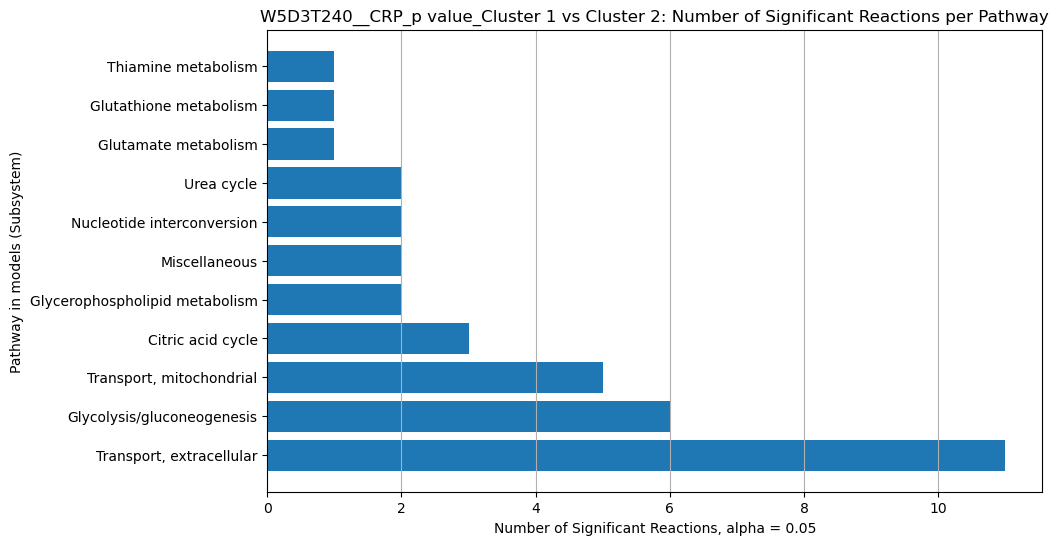

Merged result:
    flx Row Index Reaction Name       P-Value  Statistic abbreviation                                                  description                       subsystem
0              96        ACONTm  1.337097e-03  10.290598       ACONTm                                          Aconitate Hydratase               Citric acid cycle
1             100         ACt2r  1.855051e-04  13.972491        ACt2r              Acetate Reversible Transport via Proton Symport        Transport, extracellular
2             122      AKGMALtm  1.337097e-03  10.290598     AKGMALtm                       Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
3             266         CO2tm  5.880720e-03   7.586494        CO2tm                     CO2 Transport (Diffusion), Mitochondrial        Transport, mitochondrial
4             863         GTHPm  2.644580e-02   4.926633        GTHPm                         Glutathione Peroxidase, Mitochondria          Glutathione metabolism
5      

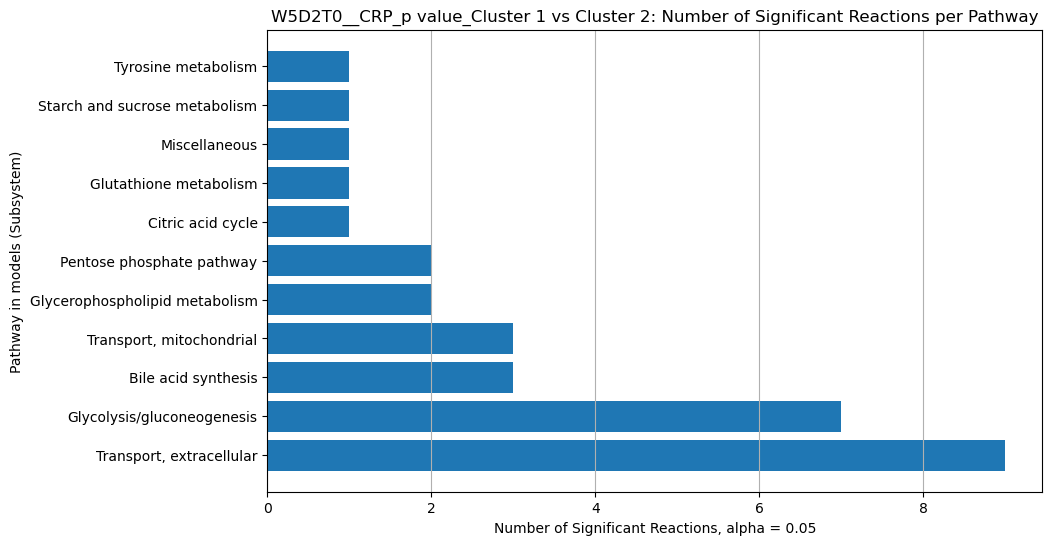

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                                         description                       subsystem
0              96        ACONTm  0.027003   4.890624       ACONTm                                                 Aconitate Hydratase               Citric acid cycle
1             122      AKGMALtm  0.027013   4.890008     AKGMALtm                              Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
2             831       GLPASE1  0.000006  20.405020      GLPASE1                            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
3             863         GTHPm  0.032661   4.563487        GTHPm                                Glutathione Peroxidase, Mitochondria          Glutathione metabolism
4            2394       RE3251C  0.004938   7.902183      RE3251C                                                             RE3251C             Bile acid

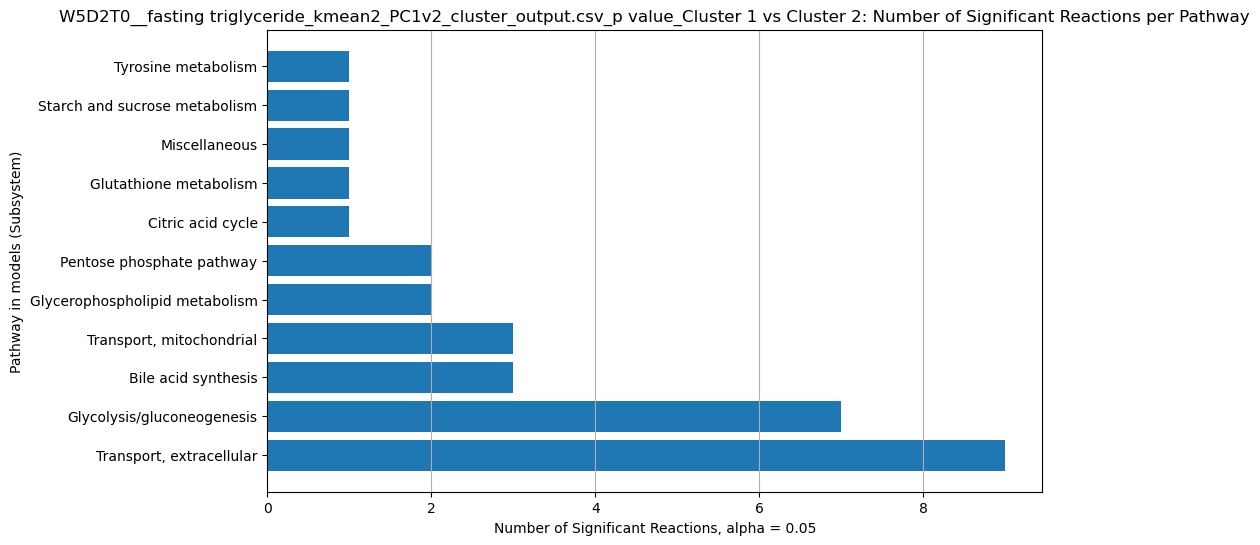

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                                         description                       subsystem
0              96        ACONTm  0.027003   4.890624       ACONTm                                                 Aconitate Hydratase               Citric acid cycle
1             122      AKGMALtm  0.027013   4.890008     AKGMALtm                              Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
2             831       GLPASE1  0.000006  20.405020      GLPASE1                            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
3             863         GTHPm  0.032661   4.563487        GTHPm                                Glutathione Peroxidase, Mitochondria          Glutathione metabolism
4            2394       RE3251C  0.004938   7.902183      RE3251C                                                             RE3251C             Bile acid

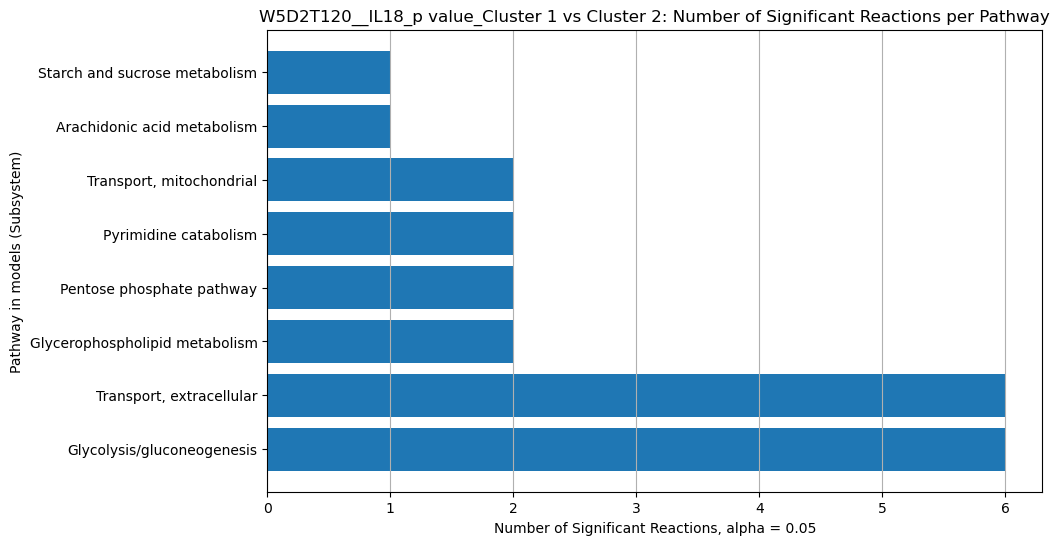

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                       subsystem
0             444        DURAD2  0.025545   4.986543       DURAD2                  Dihydrothymin Dehydrogenase (NADP)           Pyrimidine catabolism
1             831       GLPASE1  0.000013  18.947915      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
2            1688         r0921  0.025545   4.986543        r0921                       Postulated Transport Reaction        Transport, mitochondrial
3            1700         r0975  0.025545   4.986543        r0975                               Facilitated Diffusion        Transport, mitochondrial
4            2483      HCO3_NAt  0.000035  17.131113     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)        Transport, extracellular
5            2966      C04805td  0.016439   5.755260     C04805td                   T

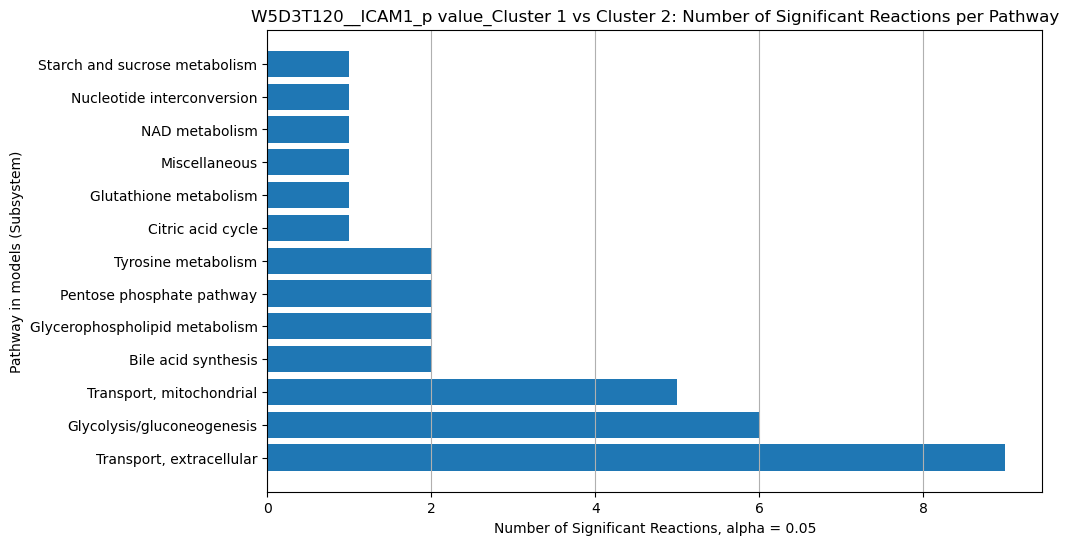

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                                         description                       subsystem
0             167         ASCBt  0.044608   4.033385        ASCBt                     L-Ascorbate Transport via Facilitated Diffusion        Transport, extracellular
1             831       GLPASE1  0.000003  21.729075      GLPASE1                            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
2             863         GTHPm  0.026210   4.942130        GTHPm                                Glutathione Peroxidase, Mitochondria          Glutathione metabolism
3             873        H2O2tm  0.011968   6.315585       H2O2tm                           Hydrogen Peroxide Mitochondrial Transport        Transport, mitochondrial
4            1414         THD1m  0.044564   4.035075        THD1m                                            NAD (P) Transhydrogenase                  NAD 

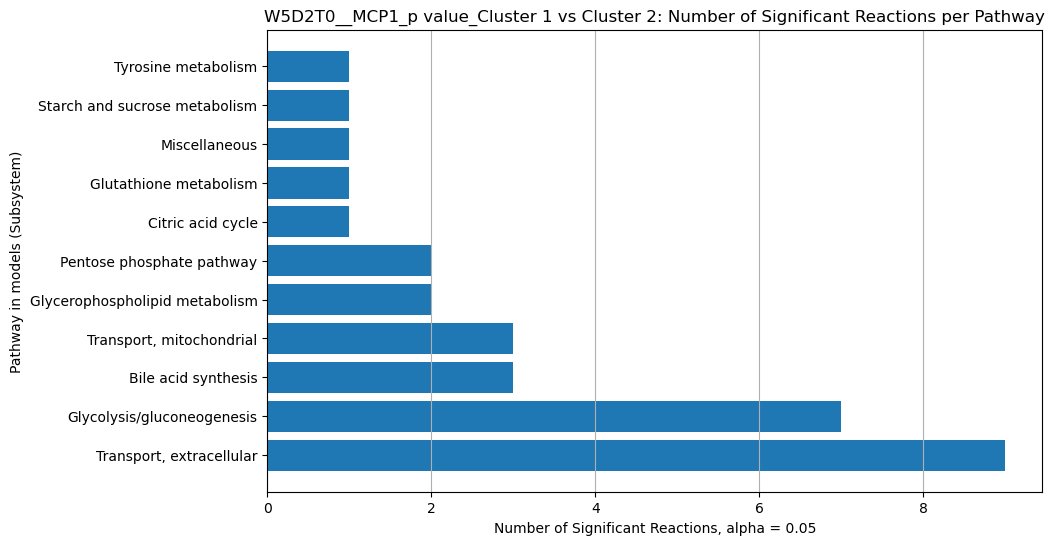

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic abbreviation                                                         description                       subsystem
0              96        ACONTm  0.027003   4.890624       ACONTm                                                 Aconitate Hydratase               Citric acid cycle
1             122      AKGMALtm  0.027013   4.890008     AKGMALtm                              Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
2             831       GLPASE1  0.000006  20.405020      GLPASE1                            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
3             863         GTHPm  0.032661   4.563487        GTHPm                                Glutathione Peroxidase, Mitochondria          Glutathione metabolism
4            2394       RE3251C  0.004938   7.902183      RE3251C                                                             RE3251C             Bile acid

In [295]:
import pandas as pd
from scipy.stats import false_discovery_control
import matplotlib.pyplot as plt
import os

# Initialize a list to store the plot file paths
plot_file_list = []

def filter_and_visualize_significant_reactions(df_filteredOG, method, name_ID):
    """
    Filters and visualizes significant reactions based on the selected method.
    
    Parameters:
    df_filteredOG (DataFrame): Input DataFrame with reactions and P-Values.
    method (int): Integer value representing the significance testing method.
                  1: Standard p-value
                  2: Bonferroni correction
                  3: Benjamini-Hochberg (BH) correction
                  4: Benjamini-Yekutieli (BY) correction
    """
    # Define the significance level
    alpha = 0.05
    
    if method == 1:
        df_filteredOG1 = df_filteredOG
        # Standard p-value threshold
        significant_df = df_filteredOG1[df_filteredOG1['P-Value'] < alpha]
        method_name = f'p value'
        print("Significant Reactions (Standard p-value):")

    elif method == 2:
        # Bonferroni correction
        df_filteredOG2 = df_filteredOG
        alpha = alpha / len(df_filteredOG2)  # Adjusted significance level
        significant_bonferroni_df = df_filteredOG2[df_filteredOG2['P-Value'] < alpha]
        method_name = 'Bonferroni'
        print("Significant Reactions after Bonferroni Correction:")
        significant_df = significant_bonferroni_df

    elif method == 3:
        # Benjamini-Hochberg (BH) correction
        df_filteredOG3 = df_filteredOG
        bh_adjusted_p_values = false_discovery_control(df_filteredOG3['P-Value'], method='bh')
        df_filteredOG3['BH Adjusted P-Value'] = bh_adjusted_p_values
        significant_bh_df = df_filteredOG3[df_filteredOG3['BH Adjusted P-Value'] < alpha]
        method_name = "BH Correction"
        print("Significant Reactions after BH Correction:")
        significant_df = significant_bh_df

    elif method == 4:
        # Benjamini-Yekutieli (BY) correction
        df_filteredOG4 = df_filteredOG
        by_adjusted_p_values = false_discovery_control(df_filteredOG4['P-Value'], method='by')
        df_filteredOG4['BY Adjusted P-Value'] = by_adjusted_p_values
        significant_by_df = df_filteredOG4[df_filteredOG4['BY Adjusted P-Value'] < alpha]
        method_name = "BY Correction"
        print("Significant Reactions after BY Correction:")
        significant_df = significant_by_df

    else:
        print("Invalid choice. Please select a valid option (1-4).")
        return None

    # Step 2: Process and visualize the significant reactions
    tsv_file_name = 'recon-store-reactions-1.tsv'
    selected_columns = ['abbreviation', 'description', 'subsystem']  # Columns to load from TSV
    reaction_data_selected = pd.read_csv(tsv_file_name, sep='\t', usecols=selected_columns)
    
    # Merge df_significant with the selected columns from reaction_data_selected
    df_merged = pd.merge(significant_df, reaction_data_selected, left_on='Reaction Name', right_on='abbreviation', how='left')
    
    # Display the merged DataFrame (optional)
    print("Merged DataFrame:")
    print(df_merged)

    # Group by 'subsystem' and count the number of reactions in each pathway
    pathway_counts = df_merged.groupby('subsystem').size().reset_index(name='Number of Significant Reactions')

    # Sort the values by the number of significant reactions (optional, for better visualization)
    plot_df = pathway_counts.sort_values(by='Number of Significant Reactions', ascending=False)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.barh(plot_df['subsystem'], plot_df['Number of Significant Reactions'])
    plt.xlabel(f'Number of Significant Reactions, alpha = {alpha}')
    plt.ylabel('Pathway in models (Subsystem)')
    title = f'{name_ID}_{method_name}_Cluster 1 vs Cluster 2: Number of Significant Reactions per Pathway'
    plt.title(title)
    plt.grid(True, axis='x')

    # Save the plot with a file name matching its title
    plot_filename = f'{name_ID}_{method_name}_Cluster 1 vs Cluster 2, Number of Significant Reactions per Pathway.png' # Create file name 
    plt.savefig(plot_filename, bbox_inches='tight')  # Save the plot
    plot_file_list.append(plot_filename)  # Add the plot file to the list
    # After creating and saving the plot, save the plot_file_list to a CSV file
    plot_file_list_df = pd.DataFrame(plot_file_list, columns=['Plot File'])
    plot_file_list_df.to_csv(f'{method_name}_plot_file_list.csv', index=False)


    plt.show()
    

    # Return the merged DataFrame and the pathway counts for further analysis if needed
    return df_merged, plot_df

# Example usage of adding plots to the list and saving them:
def process_all_files4():
    # Step 1: Iterate through all files in the current directory
    for filename in os.listdir('.'):
        # '.' represents the current directory
        # Check if the file ends with 'kmean2_PC1v2_cluster_output.csv'
        if filename.endswith('kmean2_PC1v2_cluster_output.csv'):
            # Step 3: Apply the analyze_cluster_and_flux function
            df_result, name_ID = analyze_cluster_and_flux(filename)
            print(df_result)
            # Step 4: Apply the filter_and_visualize_significant_reactions function
            df_merged_result, plot_result = filter_and_visualize_significant_reactions(df_result, 1, name_ID)  # Pass method as an argument
            # Optionally: Print or store results if needed
            print("Merged result:")
            print(df_merged_result)
            print("Plot data result:")
            print(plot_result)

# Example usage:
process_all_files4()

W5D3T240__IL18
     flx Row Index Reaction Name       P-Value  Statistic
0               28       34HPLFM  3.814843e-01   0.765913
1               96        ACONTm  1.337097e-03  10.290598
2              100         ACt2r  1.855051e-04  13.972491
3              122      AKGMALtm  1.337097e-03  10.290598
4              130      ALCD21_D  1.835228e-01   1.768864
5              131      ALCD22_D  3.321859e-01   0.940357
6              135        ALDD2y  5.824281e-01   0.302326
7              139          ALR2  4.614156e-01   0.542459
8              140          ALR3  4.614156e-01   0.542459
9              172         ASNt4  5.824281e-01   0.302326
10             235          CATm  7.091401e-01   0.139137
11             266         CO2tm  5.880720e-03   7.586494
12             319        CYTK14  5.719454e-01   0.319438
13             322         CYTK3  6.895626e-02   3.307692
14             323         CYTK4  5.824281e-01   0.302326
15             329         CYTK8  5.824281e-01   0.302326

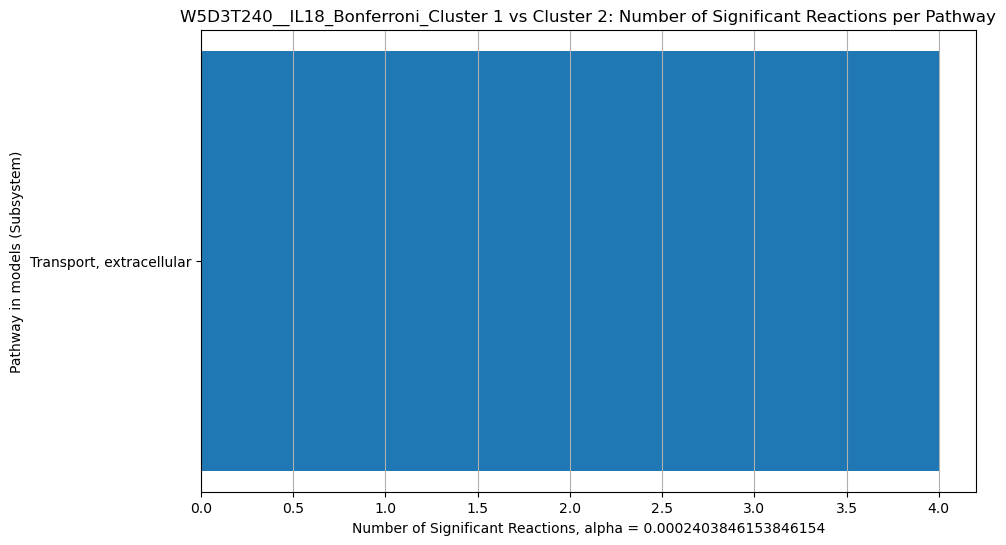

Merged result:
   flx Row Index Reaction Name       P-Value  Statistic abbreviation                                      description                 subsystem
0            100         ACt2r  1.855051e-04  13.972491        ACt2r  Acetate Reversible Transport via Proton Symport  Transport, extracellular
1           2483      HCO3_NAt  3.588996e-07   0.941202     HCO3_NAt          Bicarbonate Transport (Na/Hco3 Symport)  Transport, extracellular
2           3004    H2OGLYAQPt  2.329034e-05   0.009619   H2OGLYAQPt              Water And Glycerol Transport by Aqp  Transport, extracellular
3           7220          CO2t  1.905193e-05   0.355716         CO2t                    CO2 Transporter via Diffusion  Transport, extracellular
Plot data result:
                  subsystem  Number of Significant Reactions
0  Transport, extracellular                                4
W5D3T240__CRP
     flx Row Index Reaction Name       P-Value  Statistic
0               28       34HPLFM  3.814843e-01   0.76

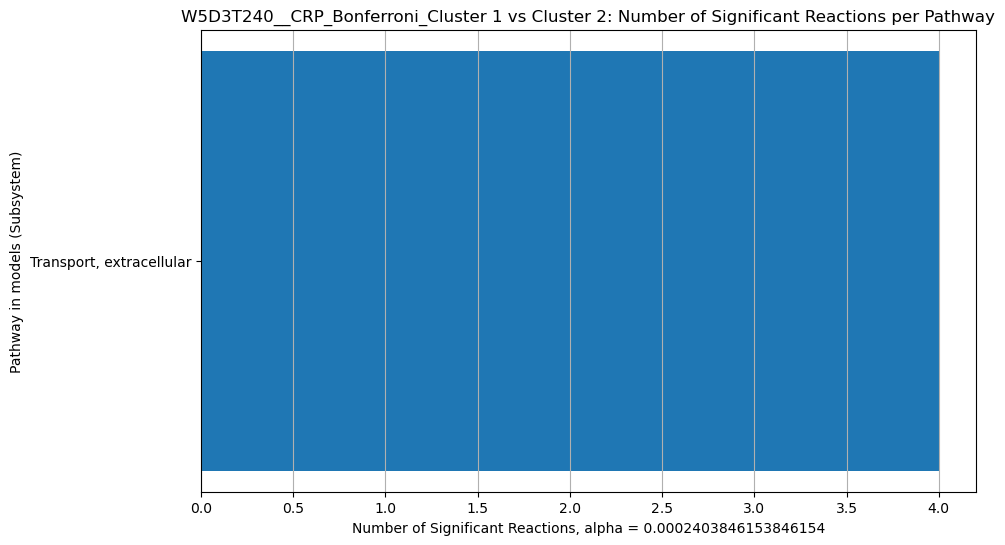

Merged result:
   flx Row Index Reaction Name       P-Value  Statistic abbreviation                                      description                 subsystem
0            100         ACt2r  1.855051e-04  13.972491        ACt2r  Acetate Reversible Transport via Proton Symport  Transport, extracellular
1           2483      HCO3_NAt  3.588996e-07   0.941202     HCO3_NAt          Bicarbonate Transport (Na/Hco3 Symport)  Transport, extracellular
2           3004    H2OGLYAQPt  2.329034e-05   0.009619   H2OGLYAQPt              Water And Glycerol Transport by Aqp  Transport, extracellular
3           7220          CO2t  1.905193e-05   0.355716         CO2t                    CO2 Transporter via Diffusion  Transport, extracellular
Plot data result:
                  subsystem  Number of Significant Reactions
0  Transport, extracellular                                4
W5D2T0__CRP
     flx Row Index  Reaction Name   P-Value  Statistic
0               27  34DHXMANDACOX  0.354539   0.857143
1  

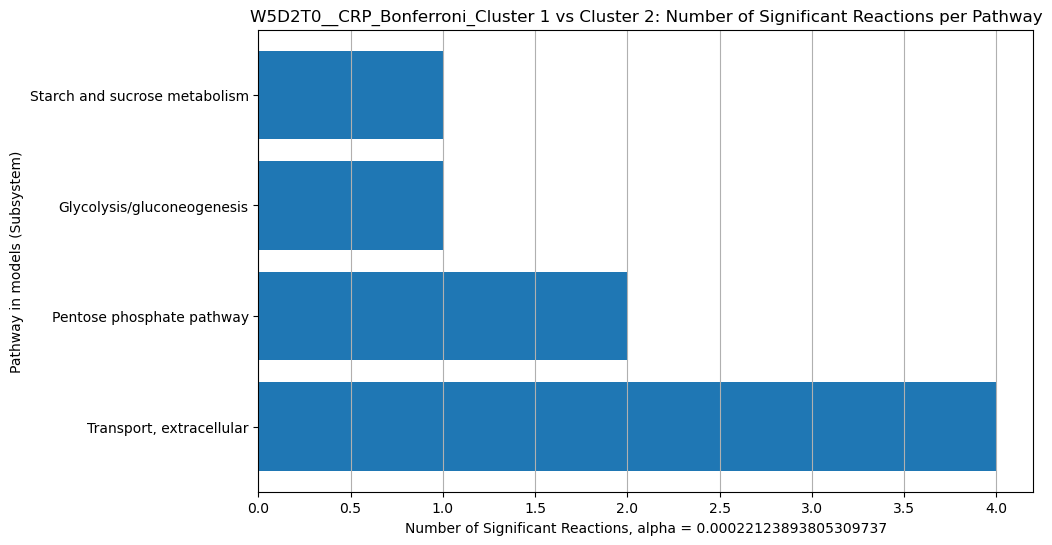

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000006  20.405020      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000003  22.019508     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000143  14.458113   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000006  20.405020       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000006  20.405020         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
5           4114        GLCNte  0.000006  20.405020       GLCNte  Assumed Passive Diffusion into 

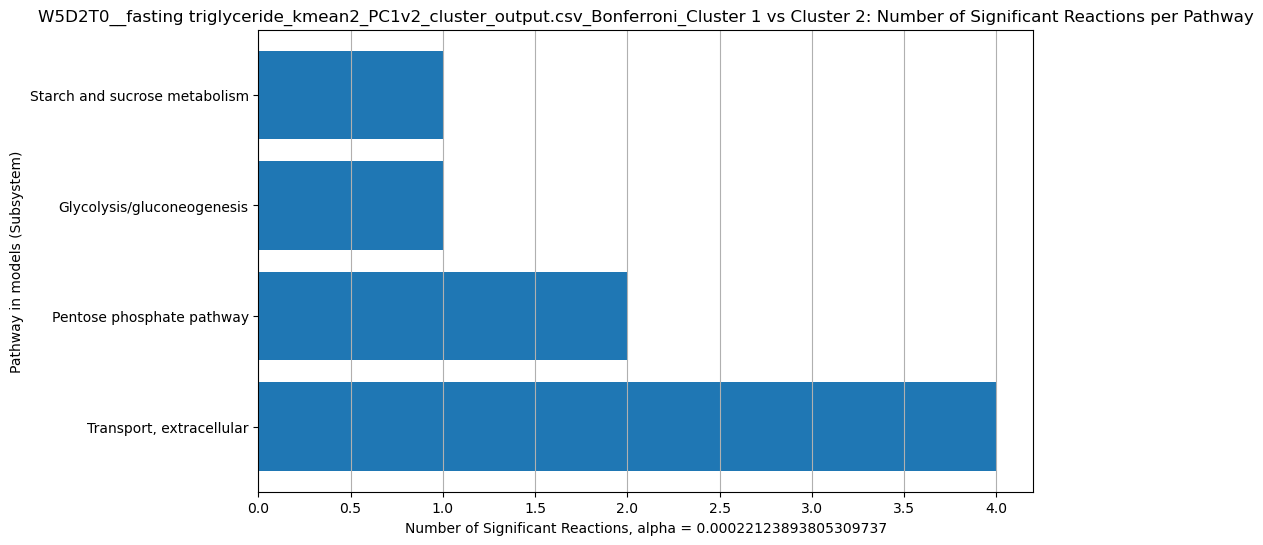

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000006  20.405020      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000003  22.019508     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000143  14.458113   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000006  20.405020       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000006  20.405020         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
5           4114        GLCNte  0.000006  20.405020       GLCNte  Assumed Passive Diffusion into 

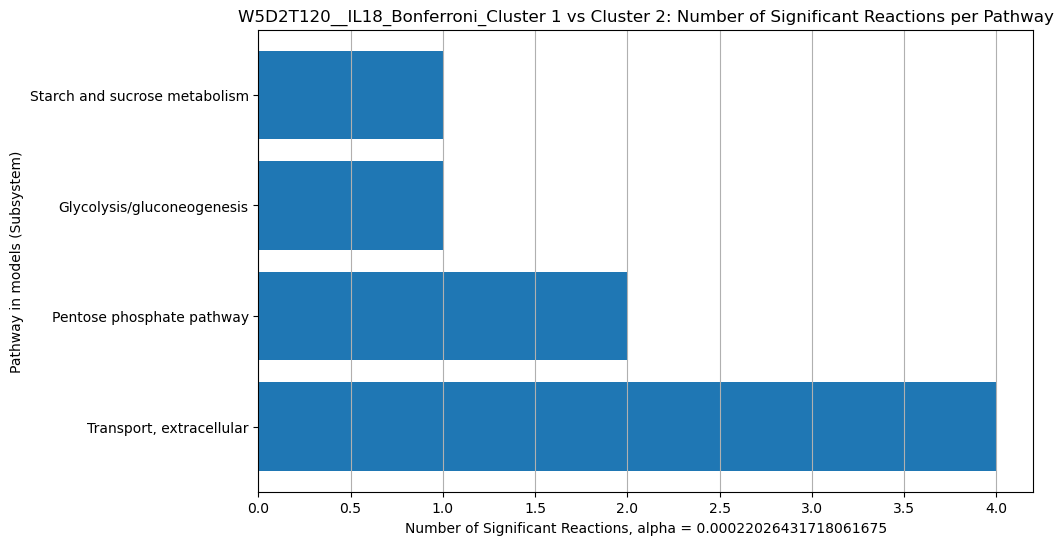

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000013  18.947915      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000035  17.131113     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000049  16.472359   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000013  18.947915       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000013  18.947915         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
5           4114        GLCNte  0.000013  18.947915       GLCNte  Assumed Passive Diffusion into 

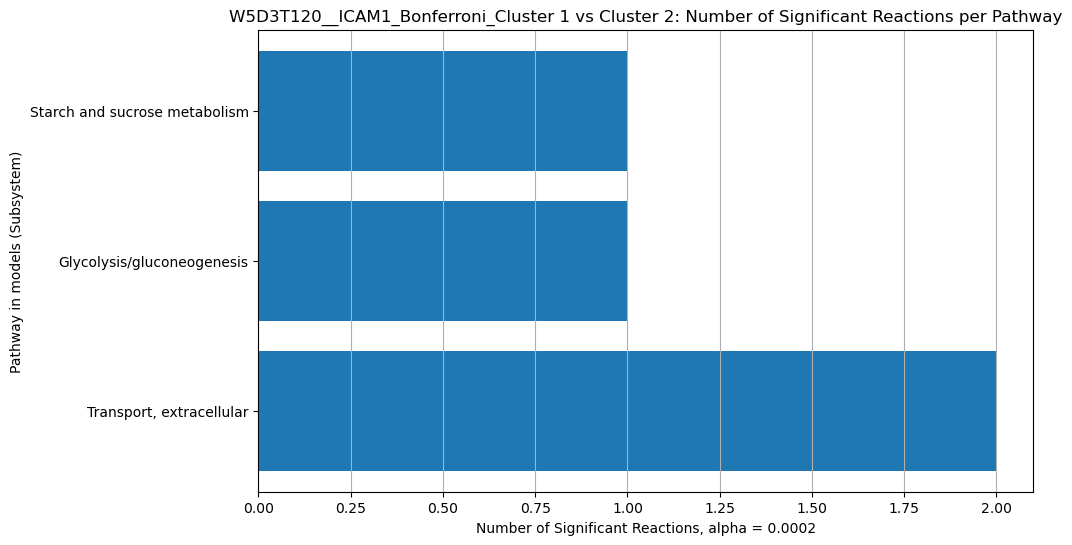

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000003  21.729075      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           3727        DXTRNt  0.000003  21.729075       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
2           3733          PGMT  0.000003  21.729075         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
3           4114        GLCNte  0.000026  17.702411       GLCNte  Assumed Passive Diffusion into Extracellular Space       Transport, extracellular
Plot data result:
                       subsystem  Number of Significant Reactions
2       Transport, extracellular                                2
0     Glycolysis/gluconeogenesis                                1
1  Starch and sucrose metabol

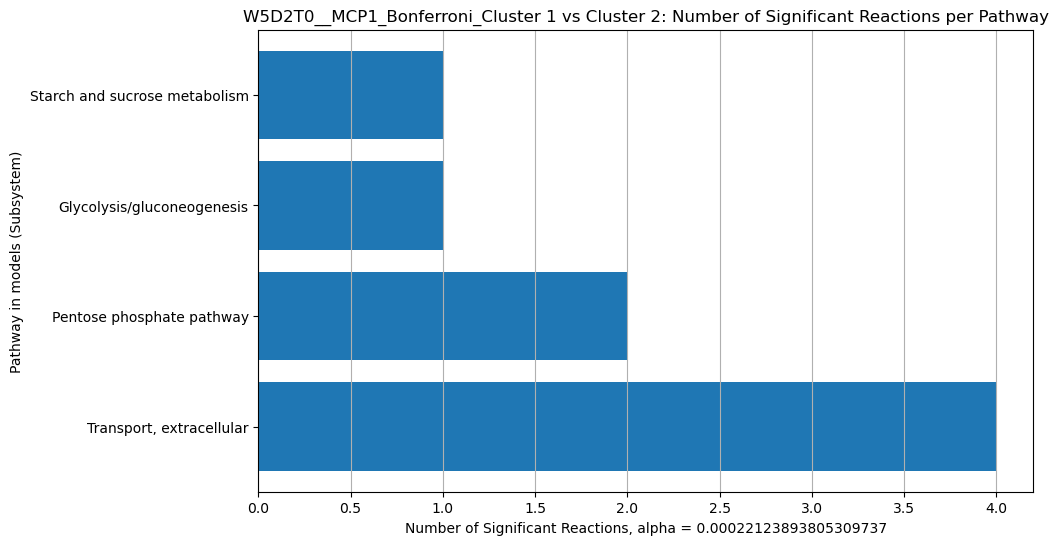

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000006  20.405020      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000003  22.019508     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000143  14.458113   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000006  20.405020       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000006  20.405020         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
5           4114        GLCNte  0.000006  20.405020       GLCNte  Assumed Passive Diffusion into 

In [279]:
# Example usage of adding plots to the list and saving them:
def process_all_files4():
    # Step 1: Iterate through all files in the current directory
    for filename in os.listdir('.'):
        # '.' represents the current directory
        # Check if the file ends with 'kmean2_PC1v2_cluster_output.csv'
        if filename.endswith('kmean2_PC1v2_cluster_output.csv'):
            # Step 3: Apply the analyze_cluster_and_flux function
            df_result, name_ID = analyze_cluster_and_flux(filename)
            print(df_result)
            # Step 4: Apply the filter_and_visualize_significant_reactions function
            df_merged_result, plot_result = filter_and_visualize_significant_reactions(df_result, 2, name_ID)  # Pass method as an argument
            # Optionally: Print or store results if needed
            print("Merged result:")
            print(df_merged_result)
            print("Plot data result:")
            print(plot_result)

# Example usage:
process_all_files4()

W5D3T240__IL18
     flx Row Index Reaction Name       P-Value  Statistic
0               28       34HPLFM  3.814843e-01   0.765913
1               96        ACONTm  1.337097e-03  10.290598
2              100         ACt2r  1.855051e-04  13.972491
3              122      AKGMALtm  1.337097e-03  10.290598
4              130      ALCD21_D  1.835228e-01   1.768864
5              131      ALCD22_D  3.321859e-01   0.940357
6              135        ALDD2y  5.824281e-01   0.302326
7              139          ALR2  4.614156e-01   0.542459
8              140          ALR3  4.614156e-01   0.542459
9              172         ASNt4  5.824281e-01   0.302326
10             235          CATm  7.091401e-01   0.139137
11             266         CO2tm  5.880720e-03   7.586494
12             319        CYTK14  5.719454e-01   0.319438
13             322         CYTK3  6.895626e-02   3.307692
14             323         CYTK4  5.824281e-01   0.302326
15             329         CYTK8  5.824281e-01   0.302326

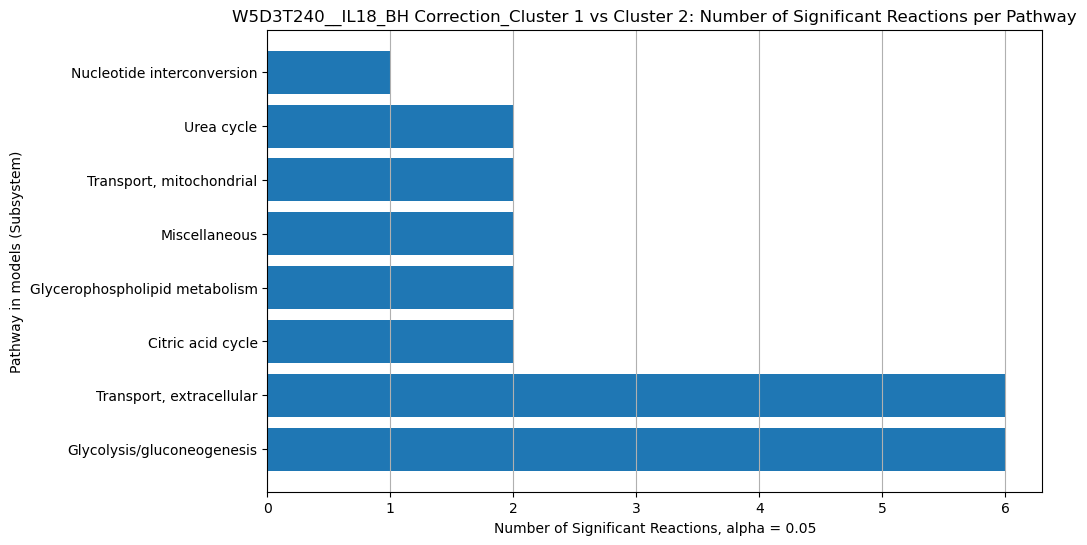

Merged result:
    flx Row Index Reaction Name       P-Value  Statistic  BH Adjusted P-Value abbreviation                                               description                       subsystem
0              96        ACONTm  1.337097e-03  10.290598             0.013244       ACONTm                                       Aconitate Hydratase               Citric acid cycle
1             100         ACt2r  1.855051e-04  13.972491             0.009646        ACt2r           Acetate Reversible Transport via Proton Symport        Transport, extracellular
2             122      AKGMALtm  1.337097e-03  10.290598             0.013244     AKGMALtm                    Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
3            1481         UMPK4  4.387397e-03   8.116095             0.039677        UMPK4                                          UMP Kinase (GTP)      Nucleotide interconversion
4            1550         r0156  1.337097e-03  10.290598             0.013244   

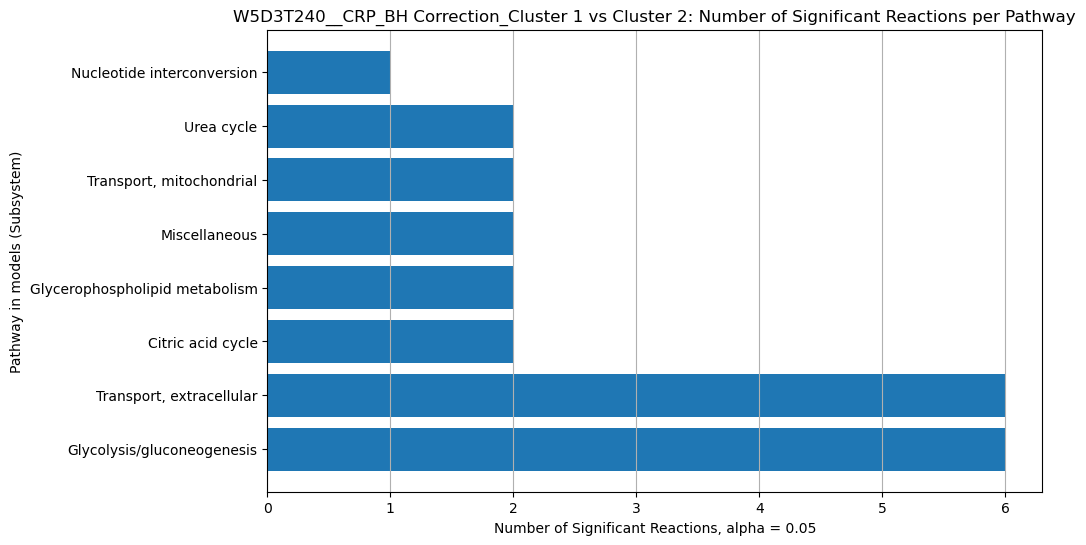

Merged result:
    flx Row Index Reaction Name       P-Value  Statistic  BH Adjusted P-Value abbreviation                                               description                       subsystem
0              96        ACONTm  1.337097e-03  10.290598             0.013244       ACONTm                                       Aconitate Hydratase               Citric acid cycle
1             100         ACt2r  1.855051e-04  13.972491             0.009646        ACt2r           Acetate Reversible Transport via Proton Symport        Transport, extracellular
2             122      AKGMALtm  1.337097e-03  10.290598             0.013244     AKGMALtm                    Alpha-Ketoglutarate/Malate Transporter        Transport, mitochondrial
3            1481         UMPK4  4.387397e-03   8.116095             0.039677        UMPK4                                          UMP Kinase (GTP)      Nucleotide interconversion
4            1550         r0156  1.337097e-03  10.290598             0.013244   

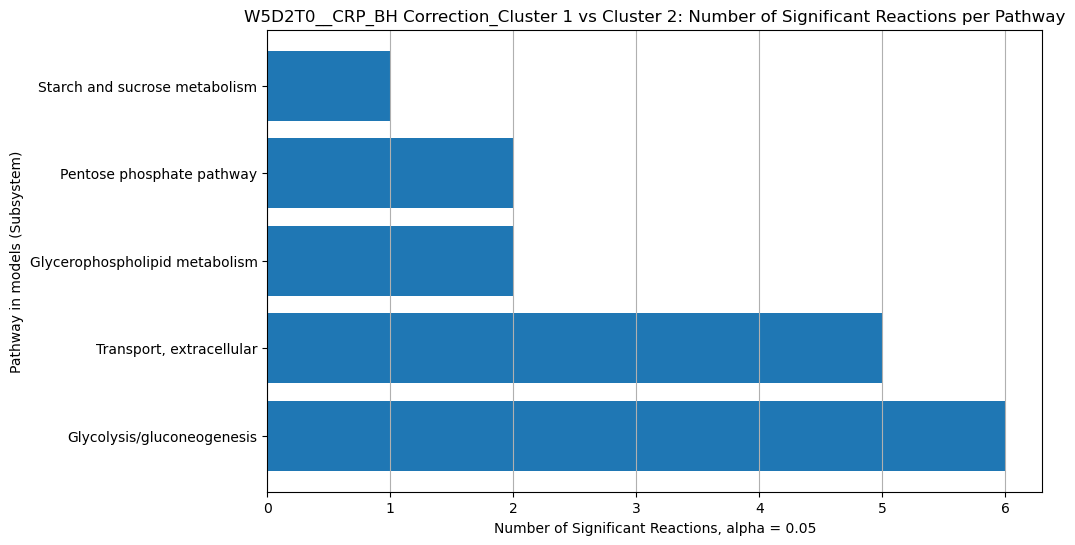

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value abbreviation                                         description                       subsystem
0             831       GLPASE1  0.000006  20.405020             0.000283      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
1            2483      HCO3_NAt  0.000003  22.019508             0.000283     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)        Transport, extracellular
2            3004    H2OGLYAQPt  0.000143  14.458113             0.004049   H2OGLYAQPt                 Water And Glycerol Transport by Aqp        Transport, extracellular
3            3727        DXTRNt  0.000006  20.405020             0.000283       DXTRNt            Transport of Phosphorylase-Limit Dextrin        Transport, extracellular
4            3731           PGM  0.002576   9.085632             0.036390          PGM                             Phosphoglycerat

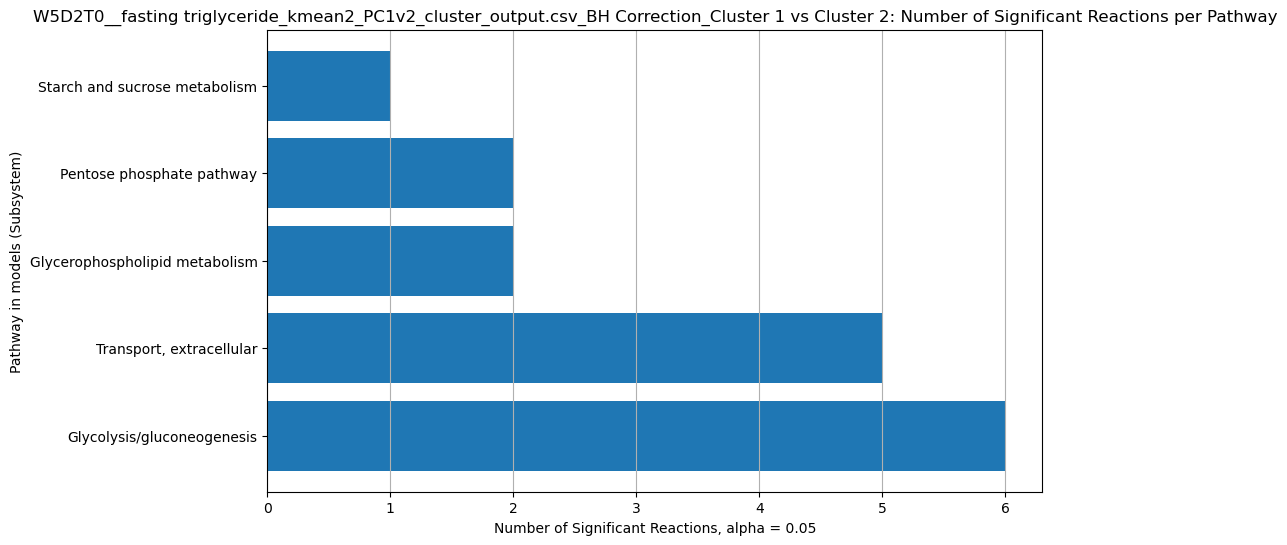

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value abbreviation                                         description                       subsystem
0             831       GLPASE1  0.000006  20.405020             0.000283      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
1            2483      HCO3_NAt  0.000003  22.019508             0.000283     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)        Transport, extracellular
2            3004    H2OGLYAQPt  0.000143  14.458113             0.004049   H2OGLYAQPt                 Water And Glycerol Transport by Aqp        Transport, extracellular
3            3727        DXTRNt  0.000006  20.405020             0.000283       DXTRNt            Transport of Phosphorylase-Limit Dextrin        Transport, extracellular
4            3731           PGM  0.002576   9.085632             0.036390          PGM                             Phosphoglycerat

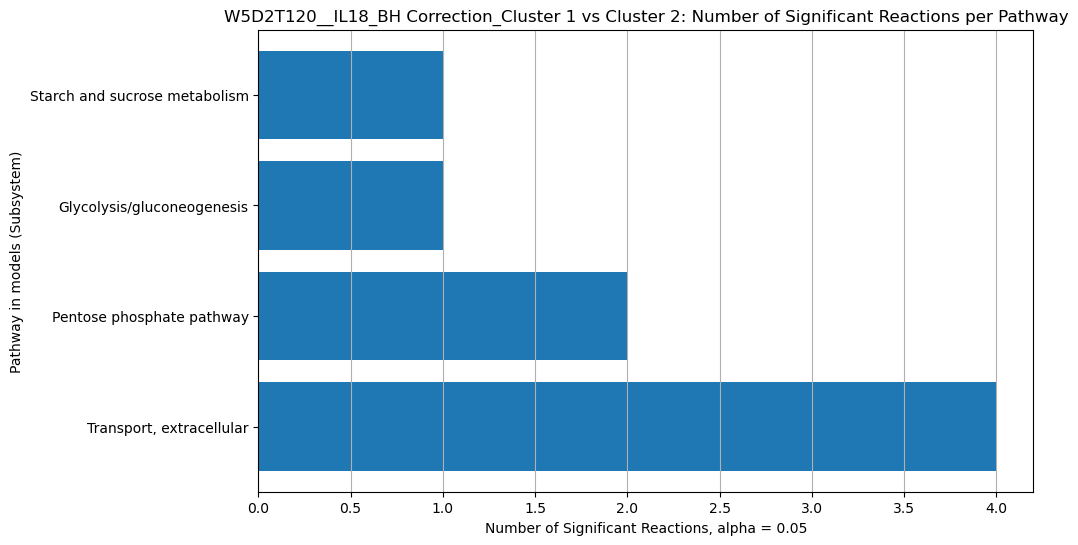

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000013  18.947915             0.000762      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000035  17.131113             0.001320     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000049  16.472359             0.001601   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000013  18.947915             0.000762       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000013  18.947915             0.000762         PGMT                                  Phosphoglucomutase   

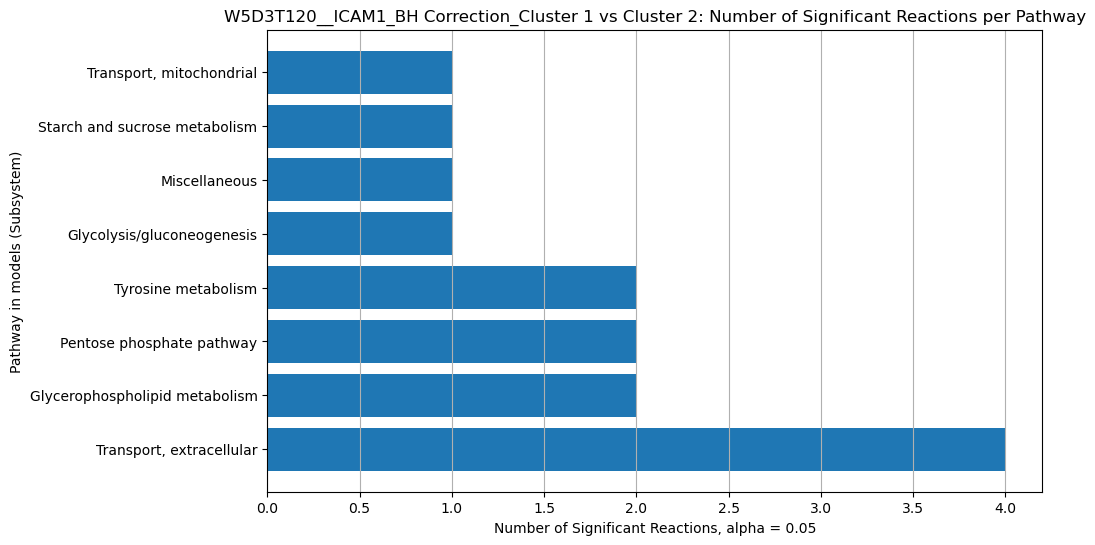

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value abbreviation                                                         description                       subsystem
0             831       GLPASE1  0.000003  21.729075             0.000262      GLPASE1                            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
1            2324       RE2526C  0.000886  11.051897             0.024610      RE2526C                                             NADPH:Quinone Reductase                   Miscellaneous
2            2483      HCO3_NAt  0.001556  10.011103             0.031091     HCO3_NAt                             Bicarbonate Transport (Na/Hco3 Symport)        Transport, extracellular
3            3727        DXTRNt  0.000003  21.729075             0.000262       DXTRNt                            Transport of Phosphorylase-Limit Dextrin        Transport, extracellular
4            3733          PGMT  0.000003  21.7290

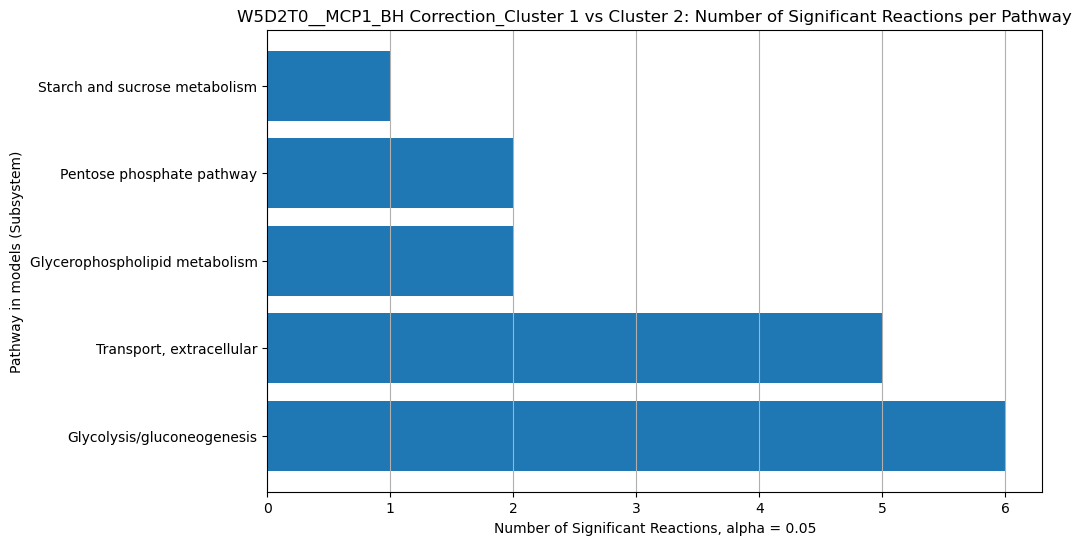

Merged result:
    flx Row Index Reaction Name   P-Value  Statistic  BH Adjusted P-Value abbreviation                                         description                       subsystem
0             831       GLPASE1  0.000006  20.405020             0.000283      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)   Starch and sucrose metabolism
1            2483      HCO3_NAt  0.000003  22.019508             0.000283     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)        Transport, extracellular
2            3004    H2OGLYAQPt  0.000143  14.458113             0.004049   H2OGLYAQPt                 Water And Glycerol Transport by Aqp        Transport, extracellular
3            3727        DXTRNt  0.000006  20.405020             0.000283       DXTRNt            Transport of Phosphorylase-Limit Dextrin        Transport, extracellular
4            3731           PGM  0.002576   9.085632             0.036390          PGM                             Phosphoglycerat

In [286]:
# Example usage of adding plots to the list and saving them:
def process_all_files4():
    # Step 1: Iterate through all files in the current directory
    for filename in os.listdir('.'):
        # '.' represents the current directory
        # Check if the file ends with 'kmean2_PC1v2_cluster_output.csv'
        if filename.endswith('kmean2_PC1v2_cluster_output.csv'):
            # Step 3: Apply the analyze_cluster_and_flux function
            df_result, name_ID = analyze_cluster_and_flux(filename)
            print(df_result)
            # Step 4: Apply the filter_and_visualize_significant_reactions function
            df_merged_result, plot_result = filter_and_visualize_significant_reactions(df_result, 3, name_ID)  # Pass method as an argument
            # Optionally: Print or store results if needed
            print("Merged result:")
            print(df_merged_result)
            print("Plot data result:")
            print(plot_result)

# Example usage:
process_all_files4()

W5D3T240__IL18
     flx Row Index Reaction Name       P-Value  Statistic
0               28       34HPLFM  3.814843e-01   0.765913
1               96        ACONTm  1.337097e-03  10.290598
2              100         ACt2r  1.855051e-04  13.972491
3              122      AKGMALtm  1.337097e-03  10.290598
4              130      ALCD21_D  1.835228e-01   1.768864
5              131      ALCD22_D  3.321859e-01   0.940357
6              135        ALDD2y  5.824281e-01   0.302326
7              139          ALR2  4.614156e-01   0.542459
8              140          ALR3  4.614156e-01   0.542459
9              172         ASNt4  5.824281e-01   0.302326
10             235          CATm  7.091401e-01   0.139137
11             266         CO2tm  5.880720e-03   7.586494
12             319        CYTK14  5.719454e-01   0.319438
13             322         CYTK3  6.895626e-02   3.307692
14             323         CYTK4  5.824281e-01   0.302326
15             329         CYTK8  5.824281e-01   0.302326

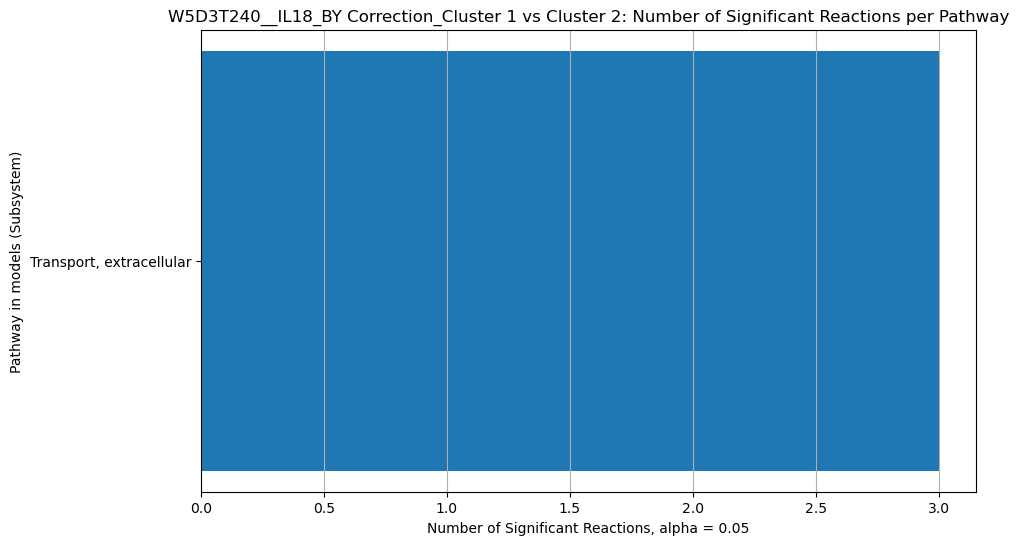

Merged result:
   flx Row Index Reaction Name       P-Value  Statistic  BY Adjusted P-Value abbreviation                              description                 subsystem
0           2483      HCO3_NAt  3.588996e-07   0.941202             0.000442     HCO3_NAt  Bicarbonate Transport (Na/Hco3 Symport)  Transport, extracellular
1           3004    H2OGLYAQPt  2.329034e-05   0.009619             0.009555   H2OGLYAQPt      Water And Glycerol Transport by Aqp  Transport, extracellular
2           7220          CO2t  1.905193e-05   0.355716             0.009555         CO2t            CO2 Transporter via Diffusion  Transport, extracellular
Plot data result:
                  subsystem  Number of Significant Reactions
0  Transport, extracellular                                3
W5D3T240__CRP
     flx Row Index Reaction Name       P-Value  Statistic
0               28       34HPLFM  3.814843e-01   0.765913
1               96        ACONTm  1.337097e-03  10.290598
2              100         AC

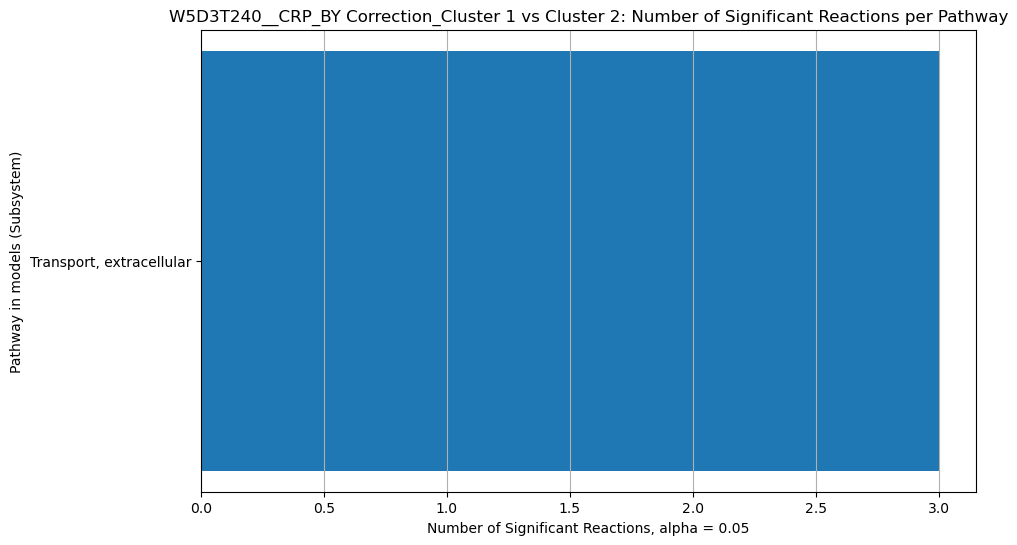

Merged result:
   flx Row Index Reaction Name       P-Value  Statistic  BY Adjusted P-Value abbreviation                              description                 subsystem
0           2483      HCO3_NAt  3.588996e-07   0.941202             0.000442     HCO3_NAt  Bicarbonate Transport (Na/Hco3 Symport)  Transport, extracellular
1           3004    H2OGLYAQPt  2.329034e-05   0.009619             0.009555   H2OGLYAQPt      Water And Glycerol Transport by Aqp  Transport, extracellular
2           7220          CO2t  1.905193e-05   0.355716             0.009555         CO2t            CO2 Transporter via Diffusion  Transport, extracellular
Plot data result:
                  subsystem  Number of Significant Reactions
0  Transport, extracellular                                3
W5D2T0__CRP
     flx Row Index  Reaction Name   P-Value  Statistic
0               27  34DHXMANDACOX  0.354539   0.857143
1               28        34HPLFM  0.862055   0.030192
2               96         ACONTm  0.027

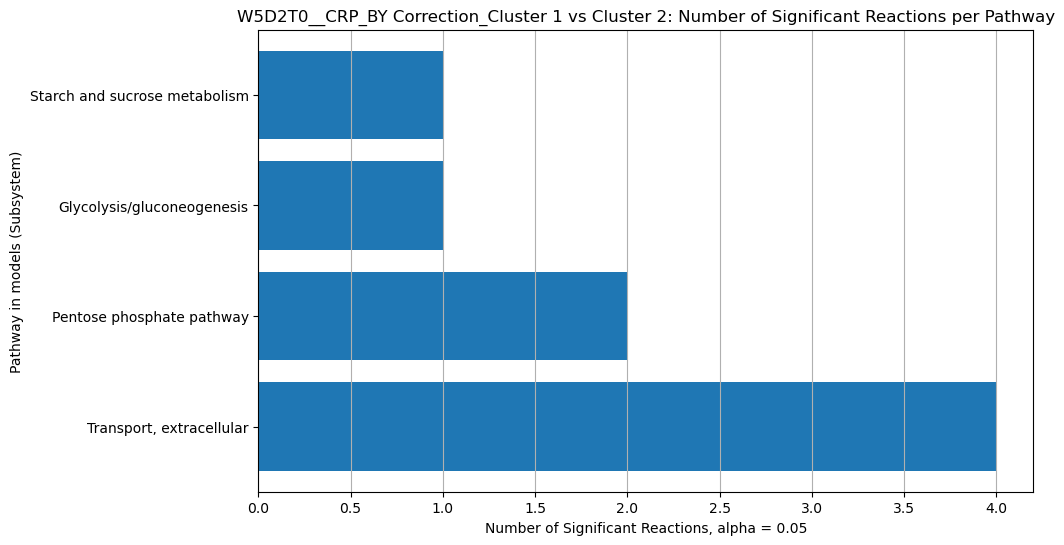

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic  BY Adjusted P-Value abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000006  20.405020             0.001699      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000003  22.019508             0.001699     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000143  14.458113             0.024291   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000006  20.405020             0.001699       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000006  20.405020             0.001699         PGMT                                  Phosphoglucomutase   

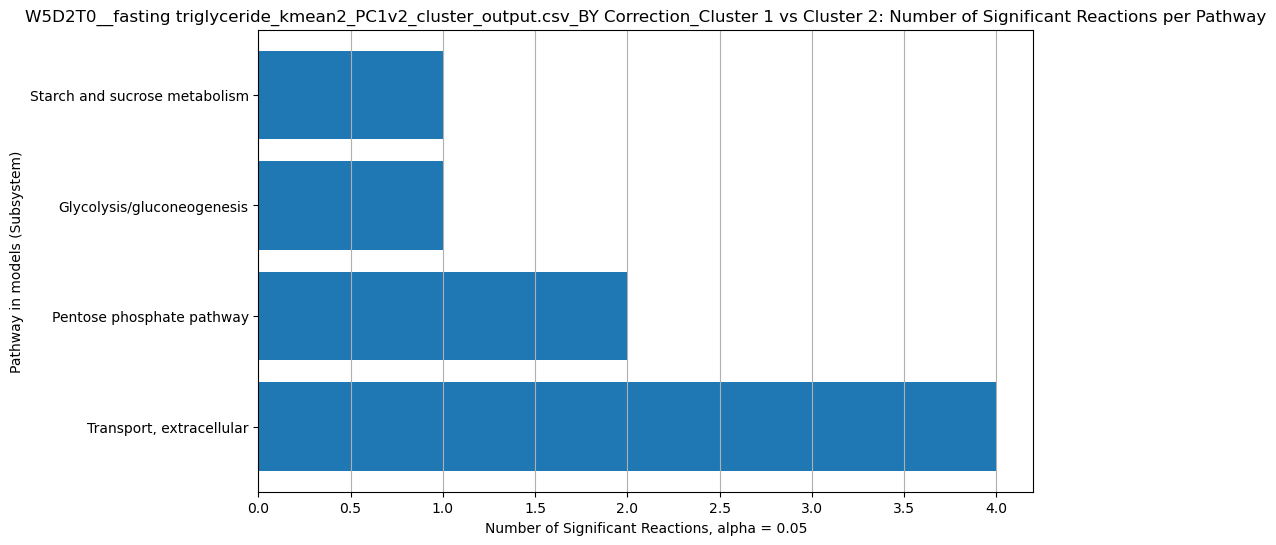

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic  BY Adjusted P-Value abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000006  20.405020             0.001699      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000003  22.019508             0.001699     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000143  14.458113             0.024291   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000006  20.405020             0.001699       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000006  20.405020             0.001699         PGMT                                  Phosphoglucomutase   

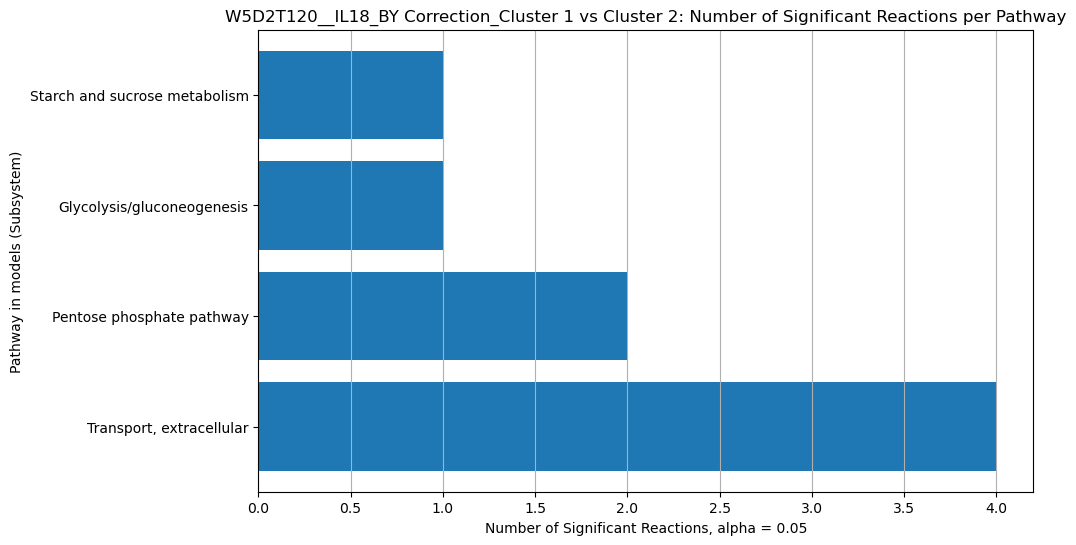

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic  BY Adjusted P-Value abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000013  18.947915             0.004577      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000035  17.131113             0.007925     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000049  16.472359             0.009612   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000013  18.947915             0.004577       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000013  18.947915             0.004577         PGMT                                  Phosphoglucomutase   

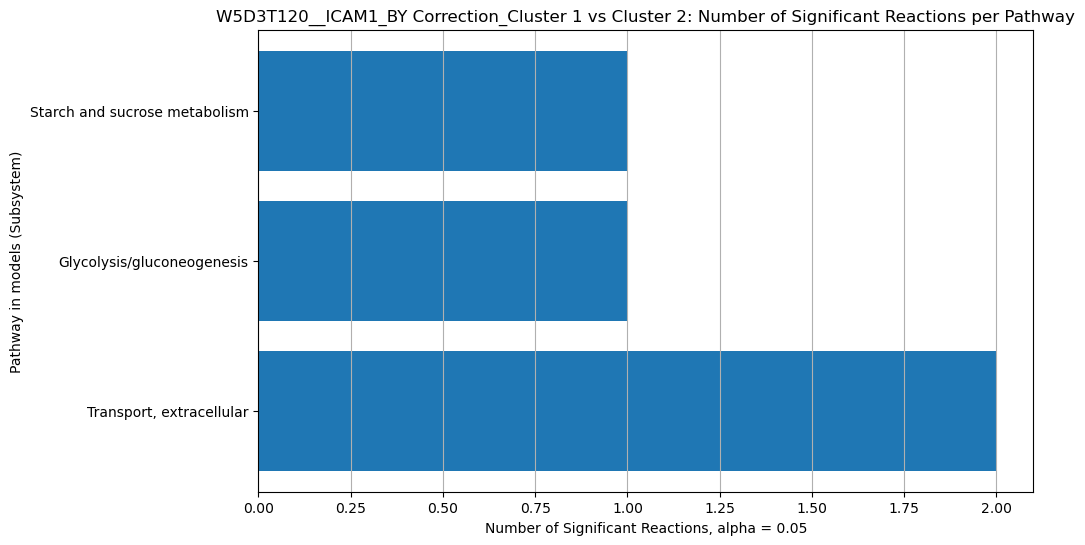

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic  BY Adjusted P-Value abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000003  21.729075             0.001596      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           3727        DXTRNt  0.000003  21.729075             0.001596       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
2           3733          PGMT  0.000003  21.729075             0.001596         PGMT                                  Phosphoglucomutase     Glycolysis/gluconeogenesis
3           4114        GLCNte  0.000026  17.702411             0.009849       GLCNte  Assumed Passive Diffusion into Extracellular Space       Transport, extracellular
Plot data result:
                       subsystem  Number of Significant Reactions
2       Transport, extracellular                        

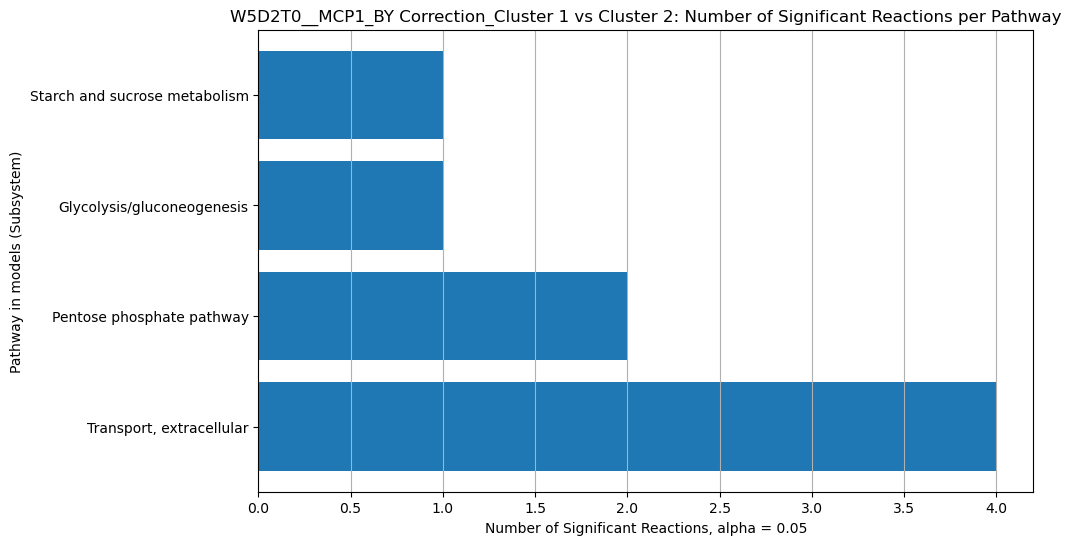

Merged result:
   flx Row Index Reaction Name   P-Value  Statistic  BY Adjusted P-Value abbreviation                                         description                      subsystem
0            831       GLPASE1  0.000006  20.405020             0.001699      GLPASE1            Glycogen Phosphorylase (Glygn2 -> Dxtrn)  Starch and sucrose metabolism
1           2483      HCO3_NAt  0.000003  22.019508             0.001699     HCO3_NAt             Bicarbonate Transport (Na/Hco3 Symport)       Transport, extracellular
2           3004    H2OGLYAQPt  0.000143  14.458113             0.024291   H2OGLYAQPt                 Water And Glycerol Transport by Aqp       Transport, extracellular
3           3727        DXTRNt  0.000006  20.405020             0.001699       DXTRNt            Transport of Phosphorylase-Limit Dextrin       Transport, extracellular
4           3733          PGMT  0.000006  20.405020             0.001699         PGMT                                  Phosphoglucomutase   

In [287]:
# Example usage of adding plots to the list and saving them:
def process_all_files4():
    # Step 1: Iterate through all files in the current directory
    for filename in os.listdir('.'):
        # '.' represents the current directory
        # Check if the file ends with 'kmean2_PC1v2_cluster_output.csv'
        if filename.endswith('kmean2_PC1v2_cluster_output.csv'):
            # Step 3: Apply the analyze_cluster_and_flux function
            df_result, name_ID = analyze_cluster_and_flux(filename)
            print(df_result)
            # Step 4: Apply the filter_and_visualize_significant_reactions function
            df_merged_result, plot_result = filter_and_visualize_significant_reactions(df_result, 4, name_ID)  # Pass method as an argument
            # Optionally: Print or store results if needed
            print("Merged result:")
            print(df_merged_result)
            print("Plot data result:")
            print(plot_result)

# Example usage:
process_all_files4()

In [293]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # For opening the saved plot images
from IPython.display import display  # To display images in Jupyter notebooks

# Function to display the saved plots from a CSV file in alphabetical order
def view_saved_plots_from_csv(csv_file_name):
    """
    View the saved plots from the CSV file containing file paths in alphabetical order.
    
    Parameters:
    csv_file_name (str): The name of the CSV file containing plot file paths.
    """
    # Read the CSV file to get the list of plot files
    plot_file_df = pd.read_csv(csv_file_name)
    
    # Extract the list of file paths and sort them alphabetically
    plot_file_list = plot_file_df['Plot File'].tolist()
    plot_file_list.sort()  # Sort the list alphabetically

    for plot_file in plot_file_list:
        # Open the image using PIL
        img = Image.open(plot_file)
        
        # Display the plot image
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis to focus on the plot
        plt.title(f"Viewing Plot: {plot_file}")
        plt.show()

# Example usage:
# view_saved_plots_from_csv('p_value_plot_file_list.csv')



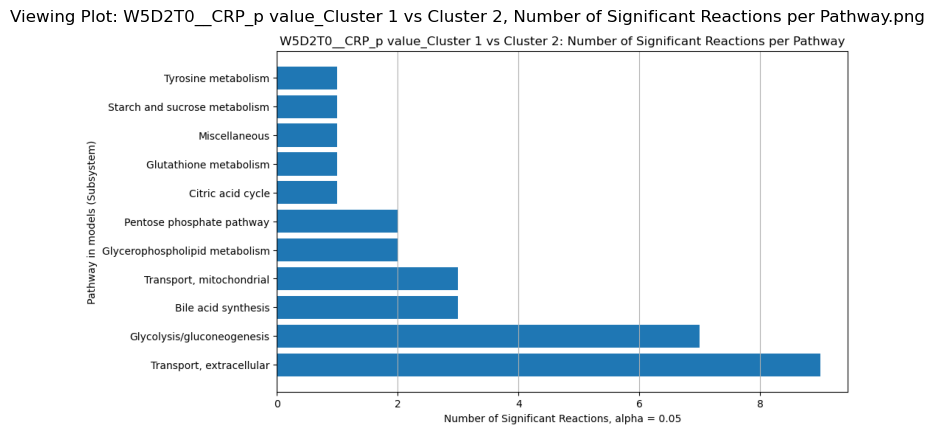

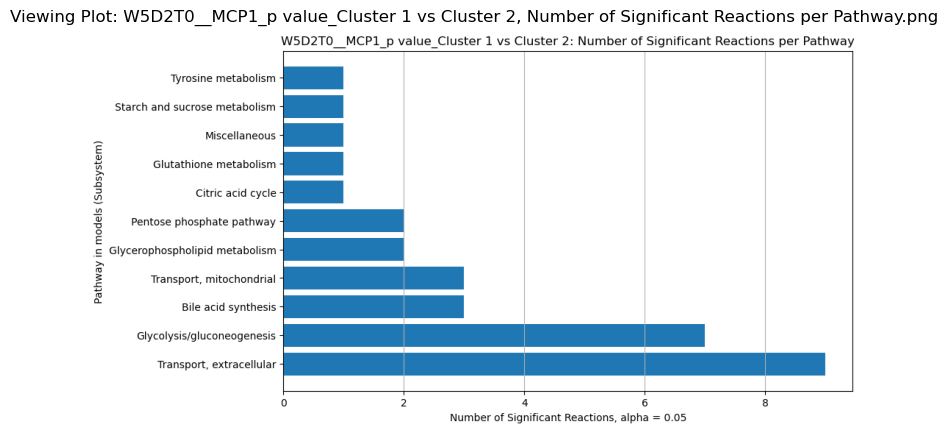

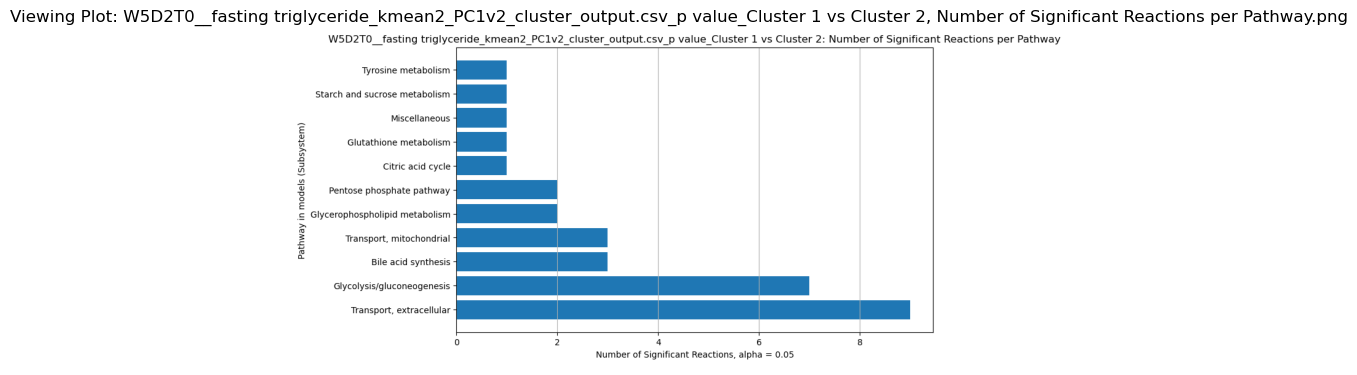

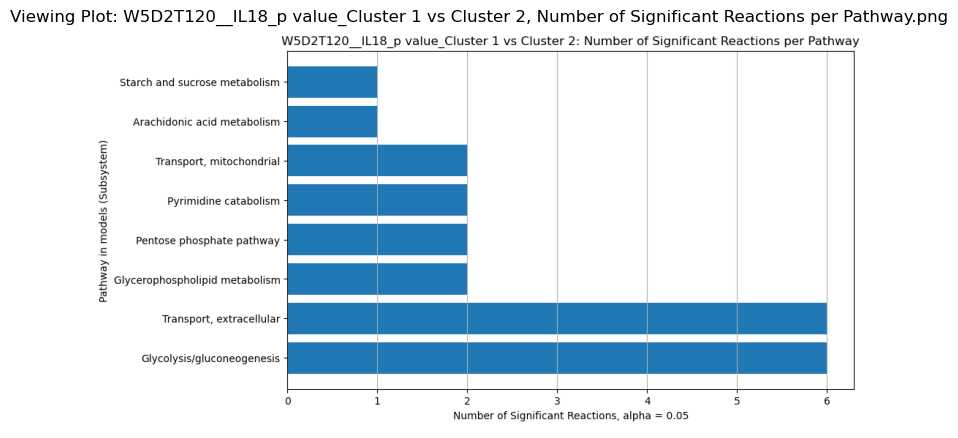

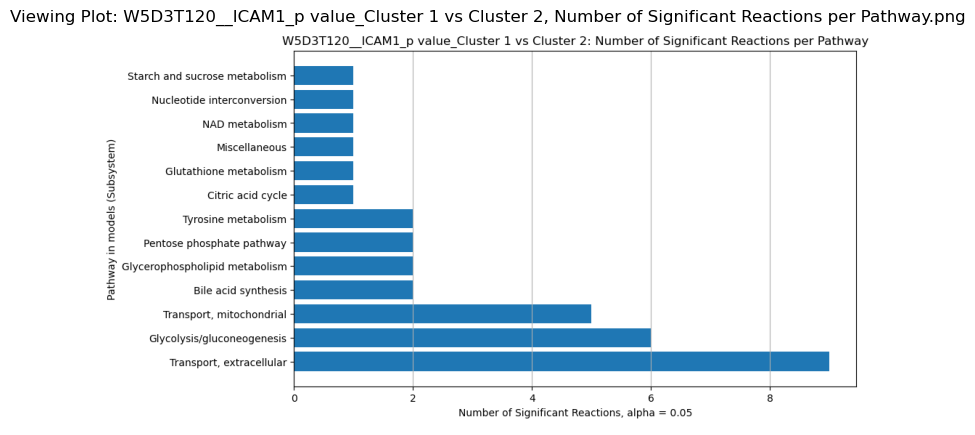

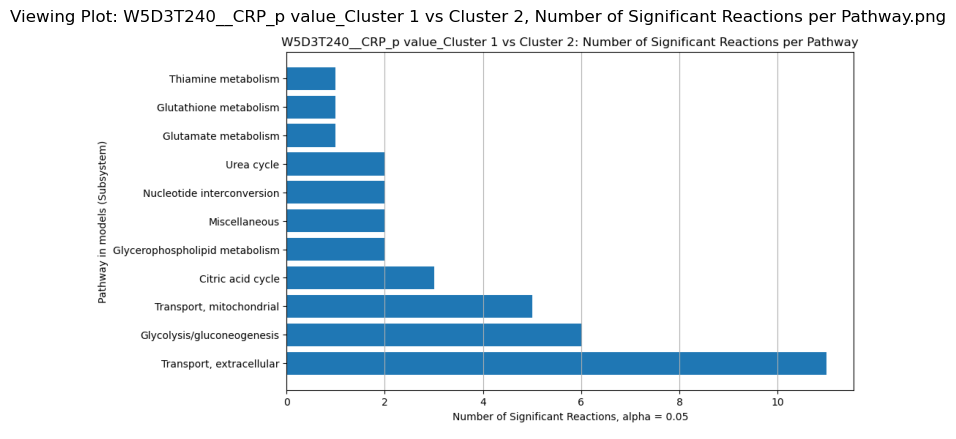

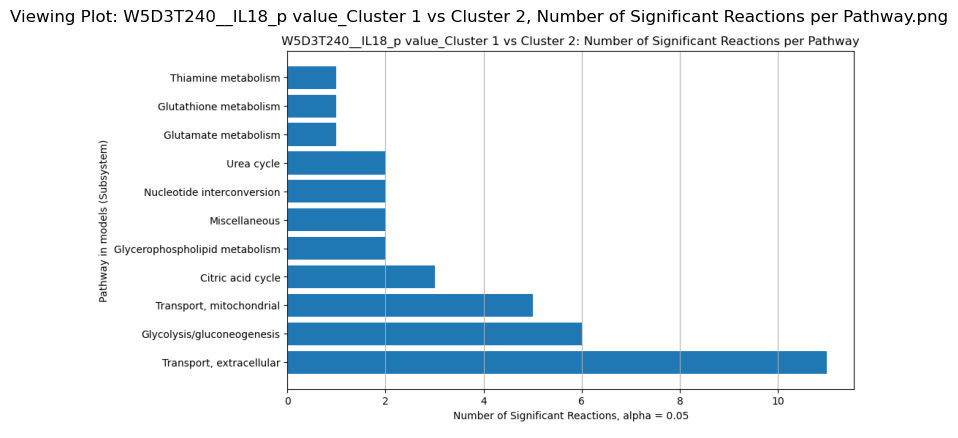

####################################################################################################################################################################################################################


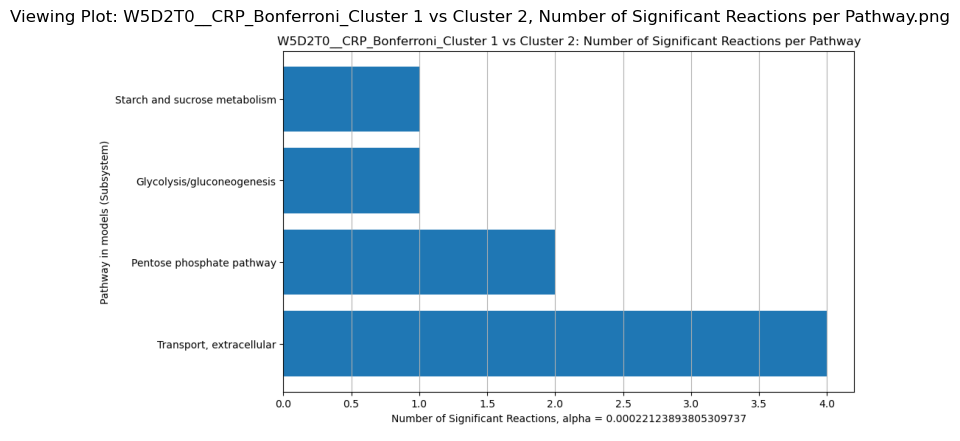

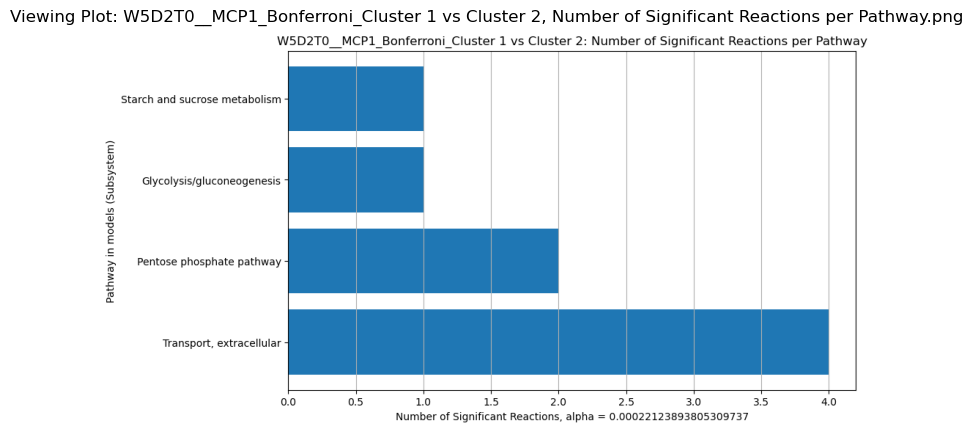

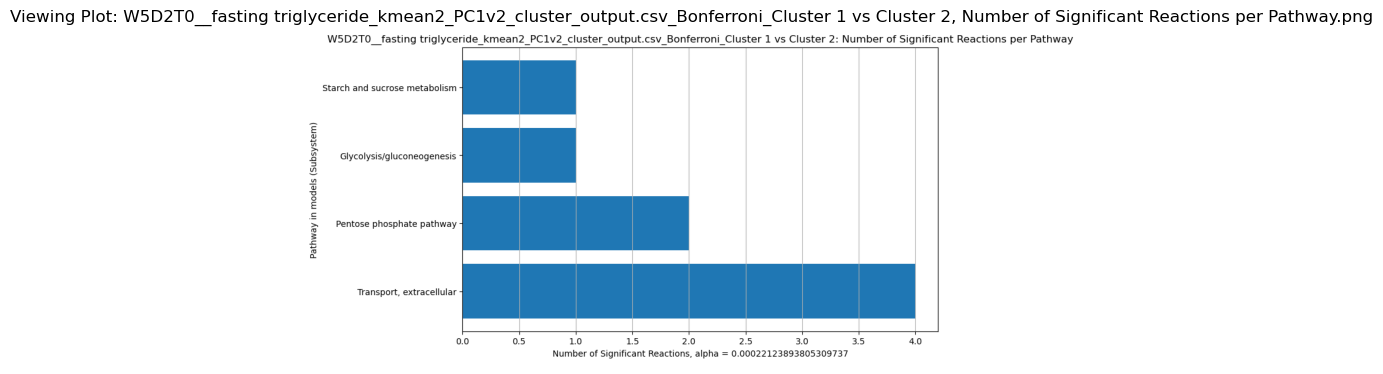

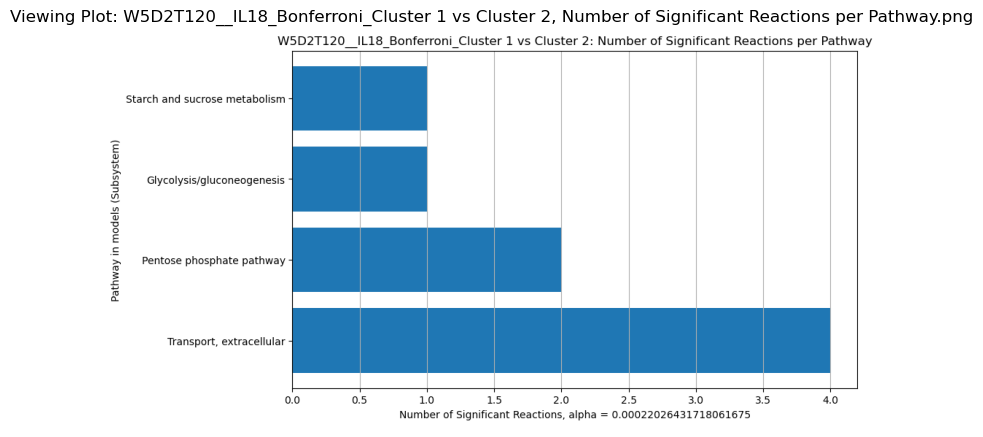

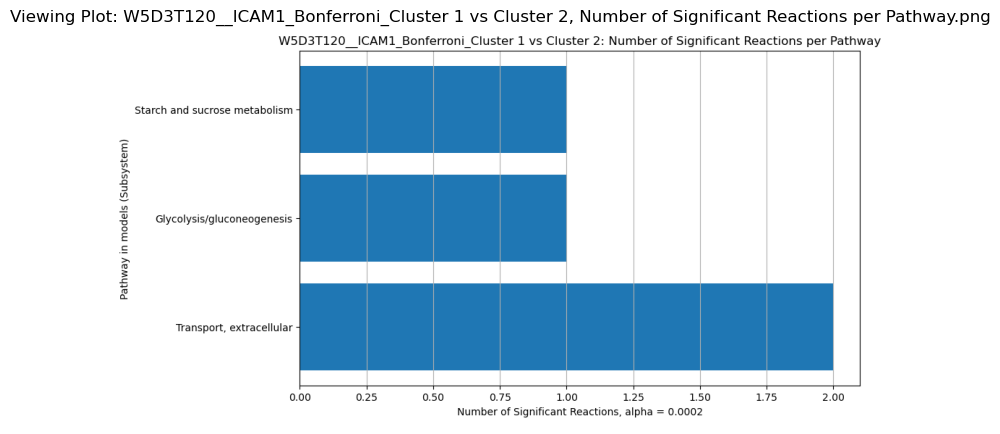

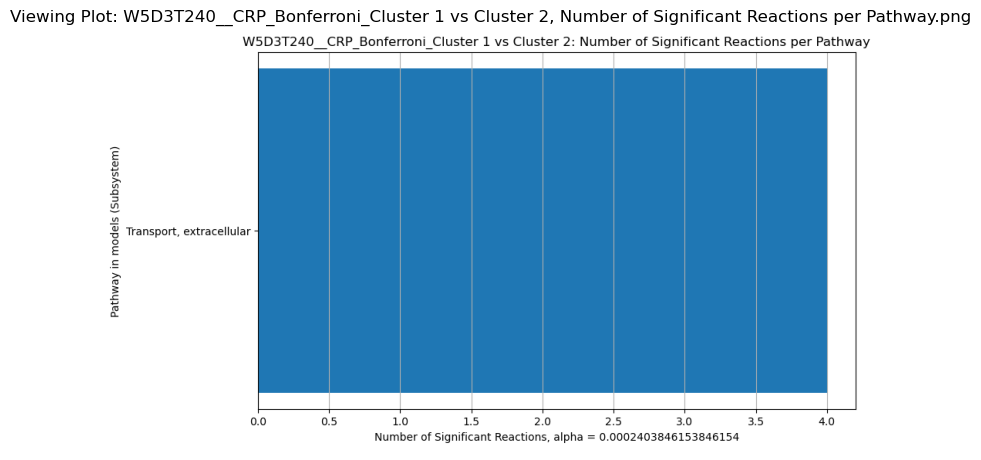

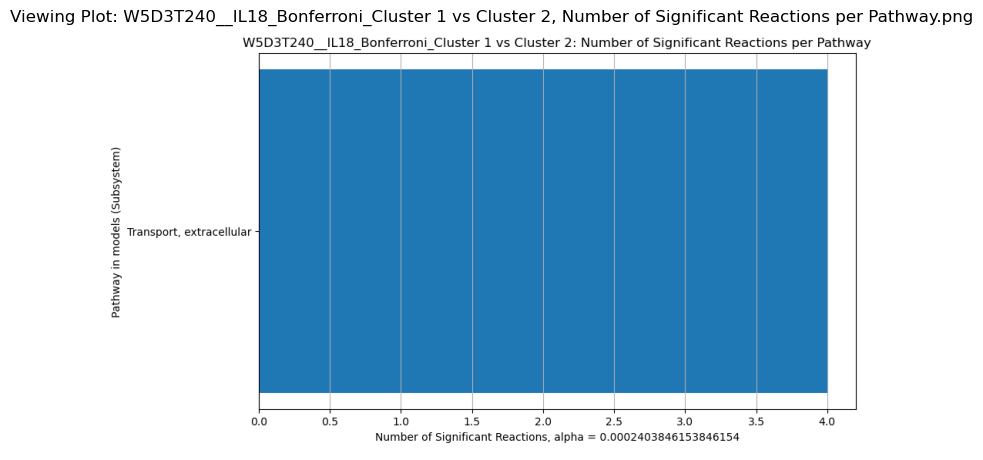

####################################################################################################################################################################################################################


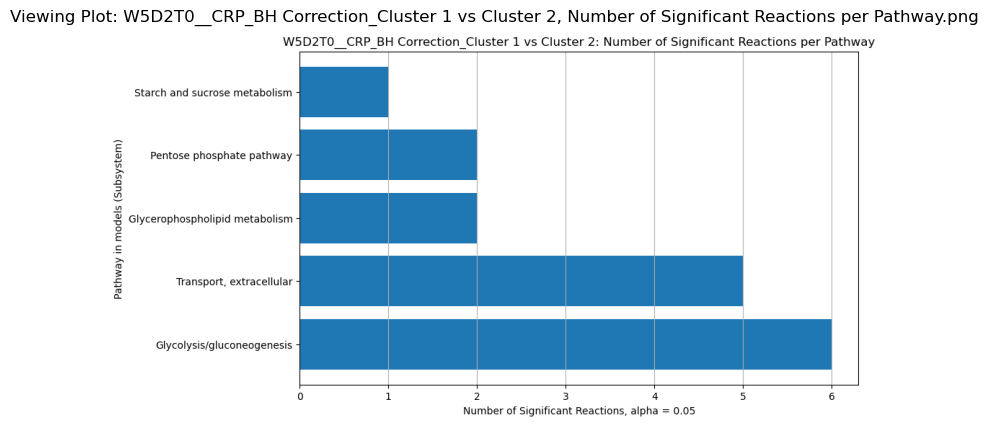

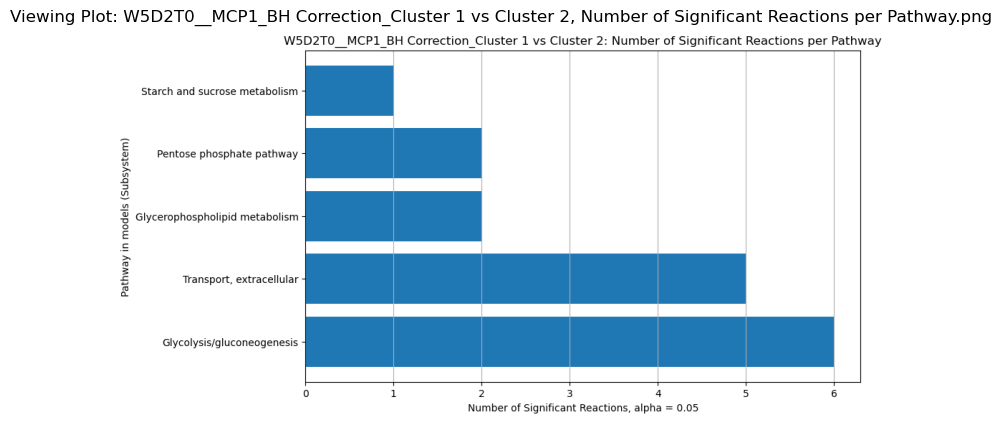

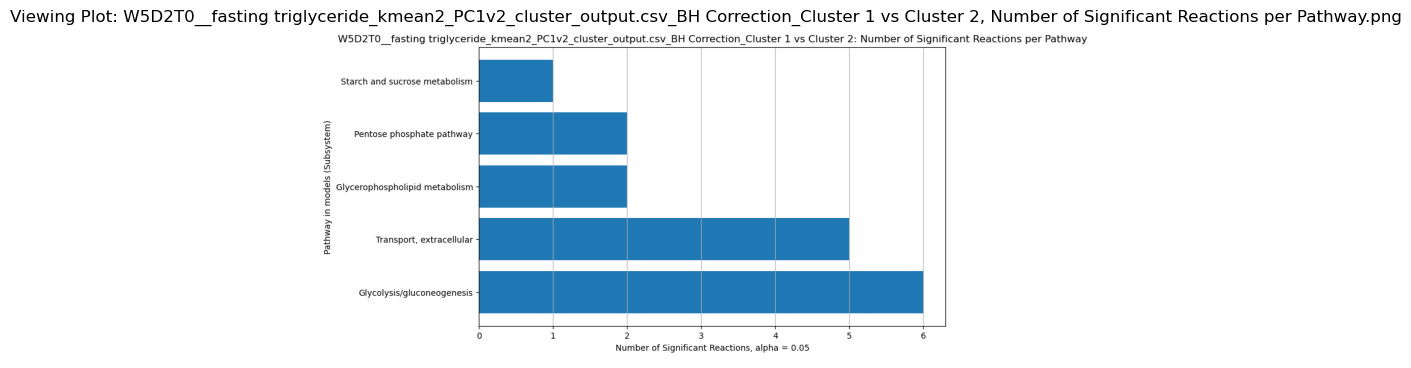

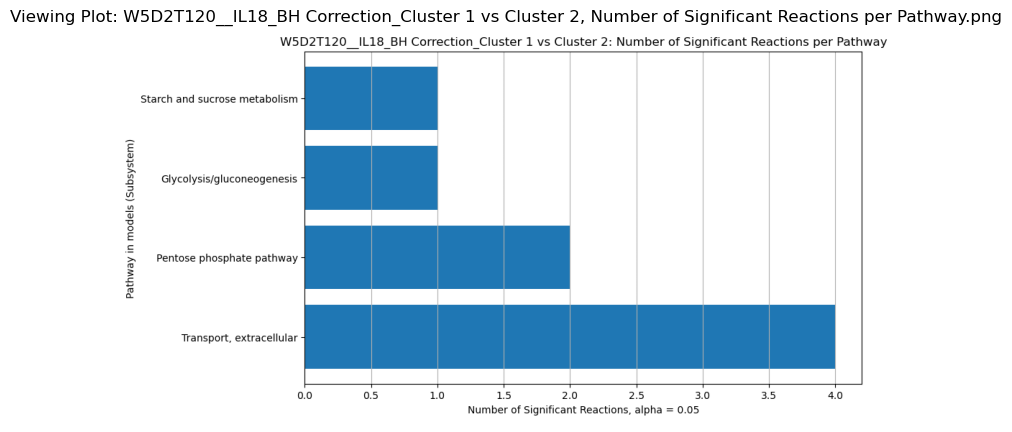

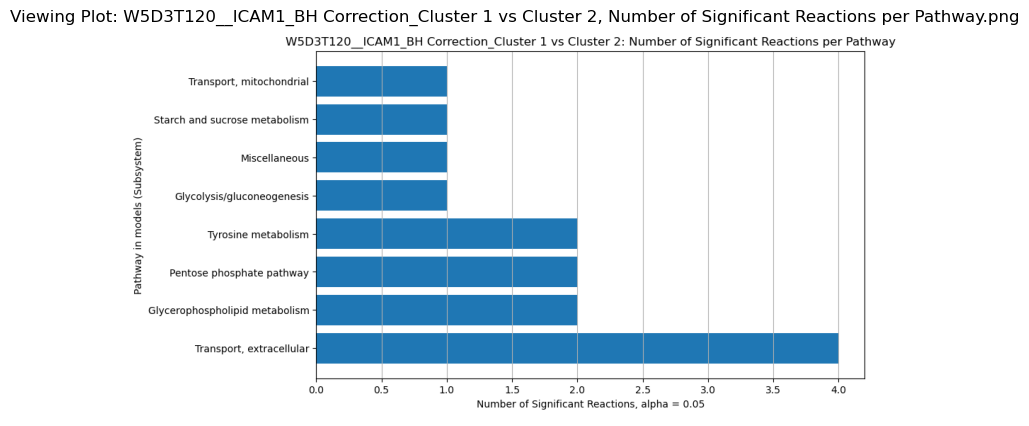

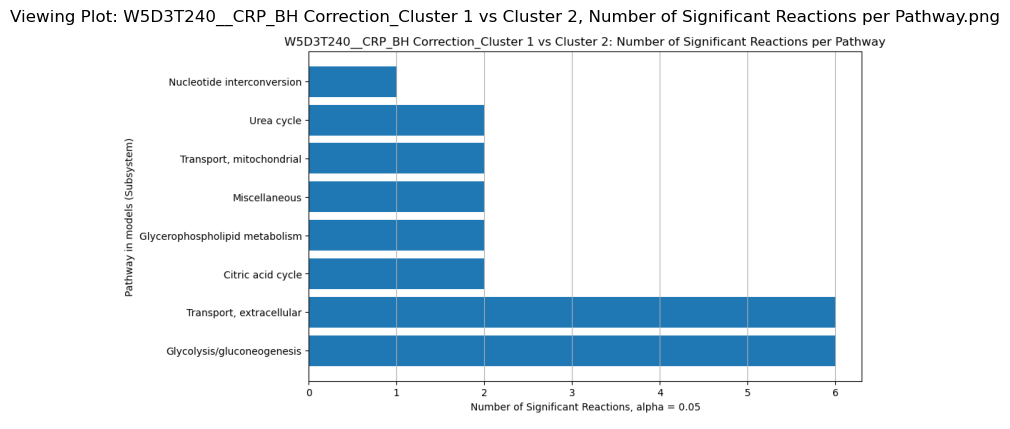

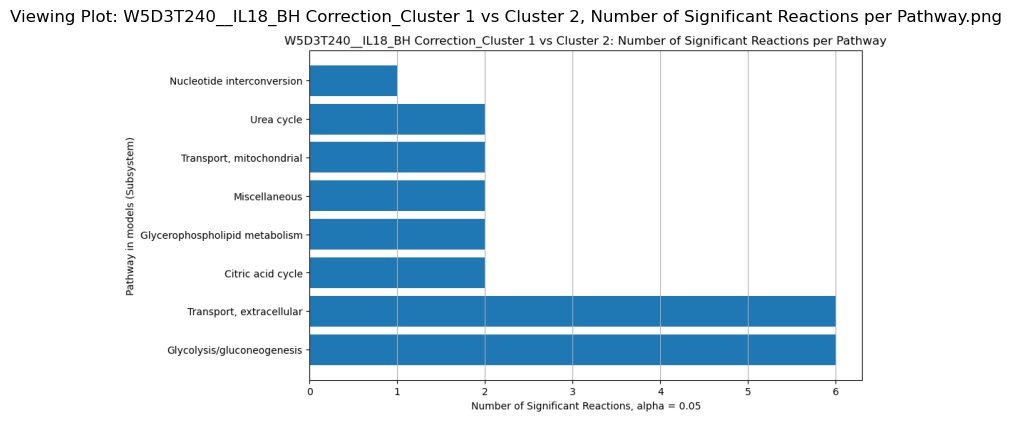

####################################################################################################################################################################################################################


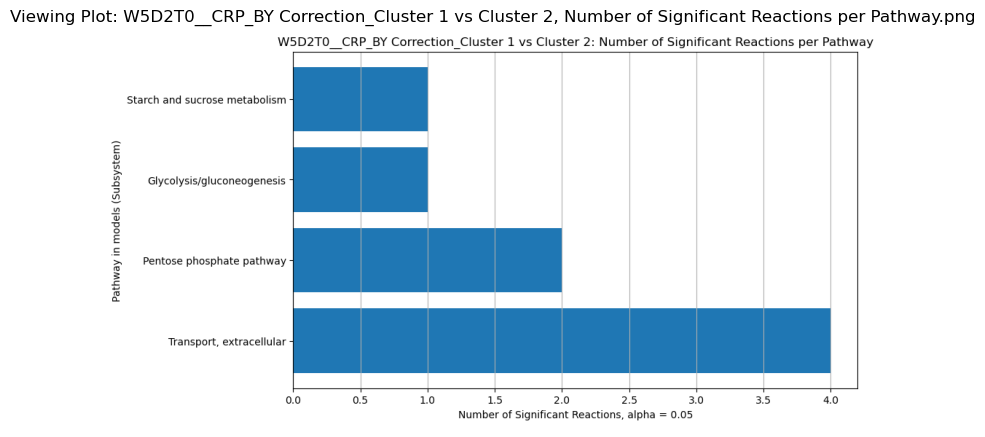

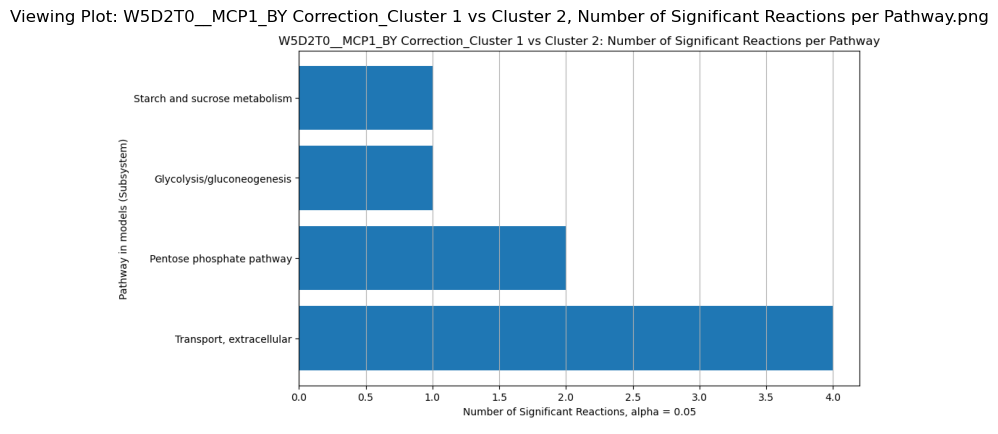

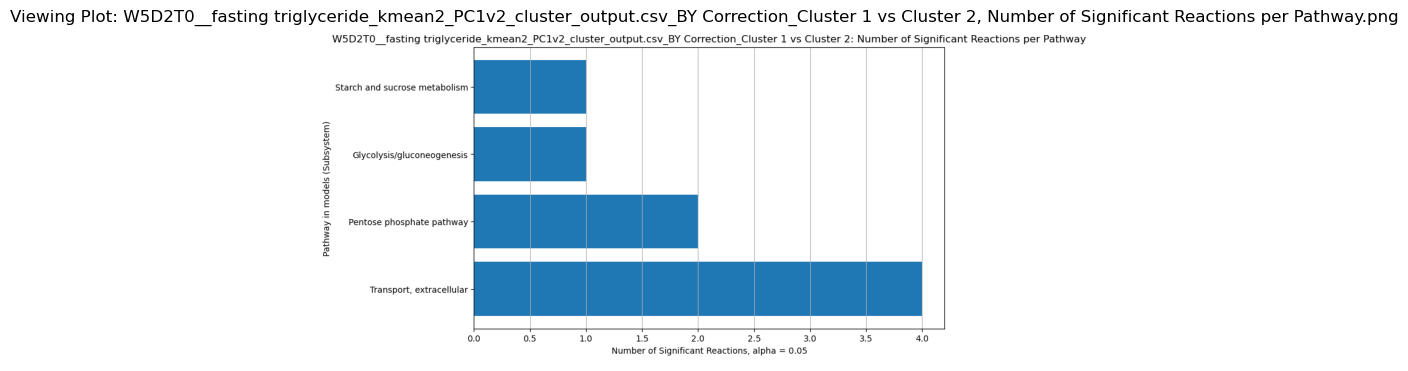

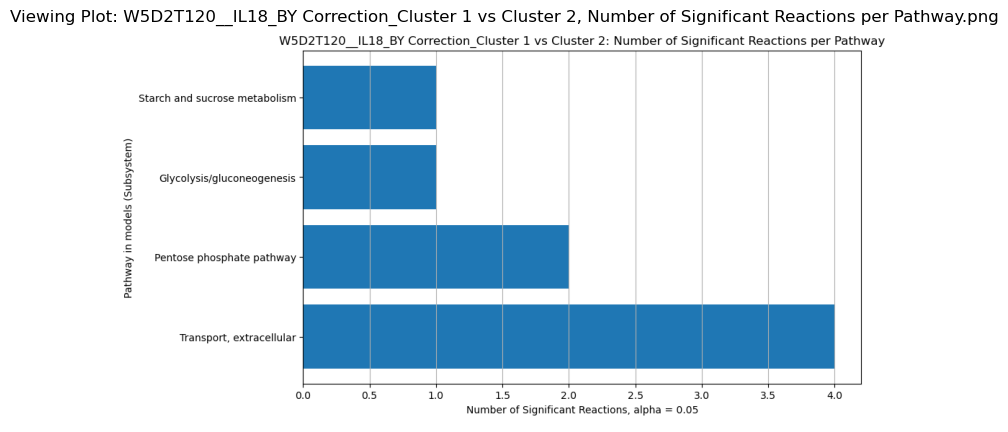

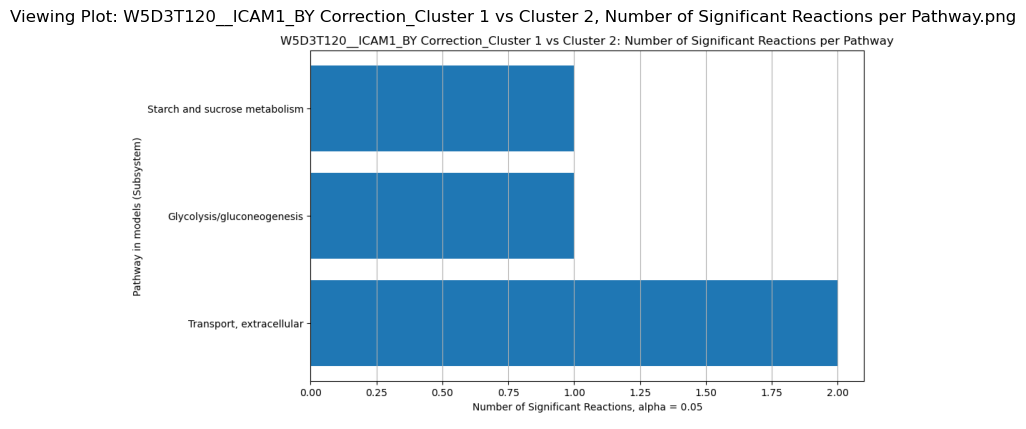

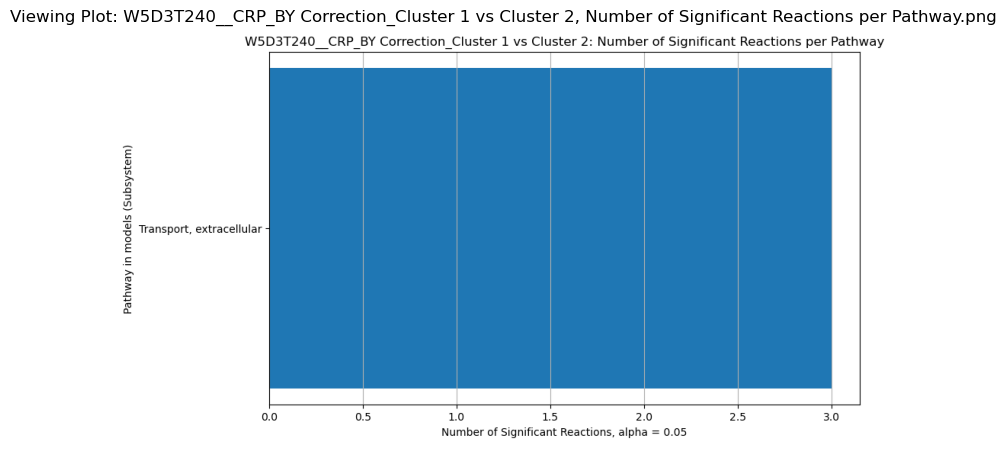

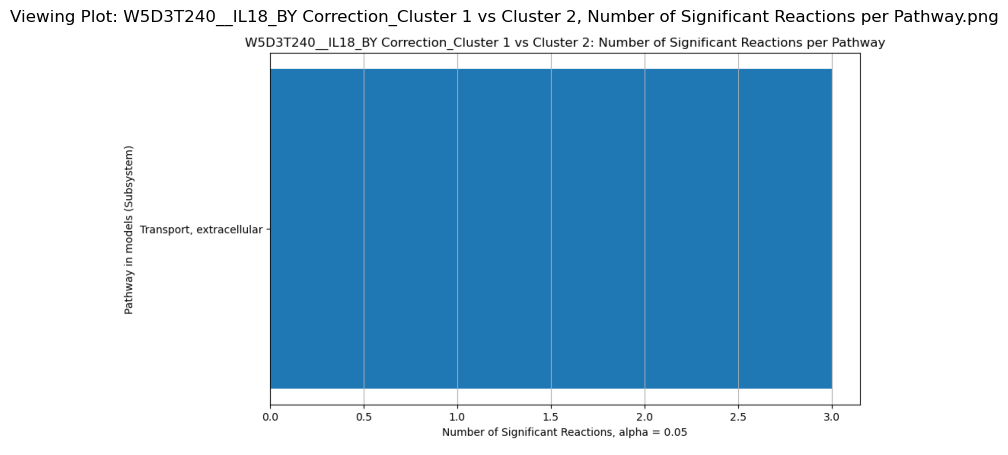

In [306]:
view_saved_plots_from_csv('p value_plot_file_list.csv')
print ('####################################################################################################################################################################################################################')
view_saved_plots_from_csv('Bonferroni_plot_file_list.csv')
print ('####################################################################################################################################################################################################################')
view_saved_plots_from_csv('filtered_BH Correction_plot_file_list.csv')
print ('####################################################################################################################################################################################################################')
view_saved_plots_from_csv('filtered_filtered_BY Correction_plot_file_list.csv')


In [304]:
#fix list files
import pandas as pd

# Load the CSV file
csv_file_name = 'filtered_BY Correction_plot_file_list.csv'  # Replace with your file name
df = pd.read_csv(csv_file_name)

# Filter out rows that contain 'p value' in the 'Plot File' column
df_filtered = df[~df['Plot File'].str.contains('BH')]

# Save the filtered DataFrame back to a new CSV file (optional)
df_filtered.to_csv('filtered_' + csv_file_name, index=False)

# Display the filtered DataFrame (optional)
print(df_filtered)


                                                                                                                                             Plot File
7                                                 W5D3T240__IL18_BY Correction_Cluster 1 vs Cluster 2, Number of Significant Reactions per Pathway.png
8                                                  W5D3T240__CRP_BY Correction_Cluster 1 vs Cluster 2, Number of Significant Reactions per Pathway.png
9                                                    W5D2T0__CRP_BY Correction_Cluster 1 vs Cluster 2, Number of Significant Reactions per Pathway.png
10  W5D2T0__fasting triglyceride_kmean2_PC1v2_cluster_output.csv_BY Correction_Cluster 1 vs Cluster 2, Number of Significant Reactions per Pathway.png
11                                                W5D2T120__IL18_BY Correction_Cluster 1 vs Cluster 2, Number of Significant Reactions per Pathway.png
12                                               W5D3T120__ICAM1_BY Correction_Cluster 1 vs Cl